In [1]:
#All libraries import here
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import json
import pandas as pd
import datetime as dt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ray
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, normaltest, jarque_bera
from hurst import compute_Hc
from functools import partial
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import normaltest

## 1. Data loading

In [4]:
df = pd.read_csv('BTCUSDT_daily.csv')
df.head(14)

,Date,Open,High,Low,Close,Volume
0,2018-01-01 11:00:00,13715.65,13818.55,12750.00,13380.00,8609.915844
1,2018-01-02 11:00:00,13382.16,15473.49,12890.02,14675.11,20078.092111
2,2018-01-03 11:00:00,14690.00,15307.56,14150.00,14919.51,15905.667639
3,2018-01-04 11:00:00,14919.51,15280.00,13918.04,15059.54,21329.649574
4,2018-01-05 11:00:00,15059.56,17176.24,14600.00,16960.39,23251.491125
5,2018-01-06 11:00:00,16960.39,17143.13,16011.21,17069.79,18571.457508
6,2018-01-07 11:00:00,17069.79,17099.96,15610.00,16150.03,12493.125558
7,2018-01-08 11:00:00,16218.85,16322.30,12812.00,14902.54,26600.609912
8,2018-01-09 11:00:00,14902.54,15500.00,14011.05,14400.00,14315.004253
9,2018-01-10 11:00:00,14401.00,14955.66,13131.31,14907.09,17411.001655


In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import random
import json
import warnings
import time
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set All Seeds
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(2025)

# -------------------------
# 1. Data Preparation
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Split and convert to tensors
    X_train = torch.FloatTensor(X_all[:train_end]).to(device)
    y_train = torch.FloatTensor(y_all[:train_end]).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_all[train_end:val_end]).to(device)
    y_val = torch.FloatTensor(y_all[train_end:val_end]).unsqueeze(1).to(device)
    X_test = torch.FloatTensor(X_all[val_end:]).to(device)
    y_test = torch.FloatTensor(y_all[val_end:]).unsqueeze(1).to(device)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 2. Quantile to Expectile Mapping
# -------------------------
def create_quantile_to_expectile_map():
    """Create mapping from quantile levels (alpha) to expectile levels (tau)"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
        
    def interpolate_mapping(alpha):
        alpha_values = sorted(mapping.keys())
        if alpha in mapping:
            return mapping[alpha]
        
        for i in range(len(alpha_values) - 1):
            if alpha_values[i] < alpha < alpha_values[i + 1]:
                alpha_low, alpha_high = alpha_values[i], alpha_values[i + 1]
                tau_low, tau_high = mapping[alpha_low], mapping[alpha_high]
                weight = (alpha - alpha_low) / (alpha_high - alpha_low)
                tau = tau_low + weight * (tau_high - tau_low)
                return tau
        
        if alpha < alpha_values[0]:
            return alpha * (mapping[alpha_values[0]] / alpha_values[0])
        else:
            return 1 - (1 - alpha) * ((1 - mapping[alpha_values[-1]]) / (1 - alpha_values[-1]))
    
    return interpolate_mapping

# -------------------------
# 3. Model Definition
# -------------------------
class ALDAGDMixtureSameArch(nn.Module):
    def __init__(self, config, quantile_to_expectile_map):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        self.target_quantile = config.get("tau", 0.5)
        self.alpha_ald = self.target_quantile
        self.tau_agd = quantile_to_expectile_map(self.target_quantile)
        self.pi = config.get("pi", 0.5)  # Tunable mixing weight
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (always on, except for last layer)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Two output layers for mixture components
        self.mu1_layer = nn.Linear(prev_dim, 1)
        self.mu2_layer = nn.Linear(prev_dim, 1)
        
        # Sigma parameter from config
        self.sigma_fixed = config.get("sigma", 0.5)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        # Process through hidden layers
        hidden = self.fc(last_hidden)
        
        # Get predictions for both components
        mu1 = self.mu1_layer(hidden)
        mu2 = self.mu2_layer(hidden)
        
        # Fixed sigma
        sigma1 = torch.full_like(mu1, self.sigma_fixed)
        sigma2 = torch.full_like(mu2, self.sigma_fixed)
        
        return mu1, sigma1, mu2, sigma2

# -------------------------
# 4. Loss Functions
# -------------------------
def ald_pdf(y, mu, sigma, alpha):
    """ALD PDF with quantile level alpha"""
    diff = y - mu
    indicator = (y <= mu).float()
    normalization = (alpha * (1 - alpha)) / sigma
    exponent = -diff / sigma * (alpha - indicator)  
    pdf = normalization * torch.exp(exponent)
    return pdf

def agd_pdf(y, mu, sigma, tau):
    """AGD PDF with expectile level tau"""
    diff = y - mu
    indicator = (y < mu).float()
    norm_const = 2 / (sigma * np.sqrt(np.pi) * (np.sqrt(1/(1-tau)) + np.sqrt(1/tau)))
    exponent = -(diff**2) / (sigma**2) * torch.abs(tau - indicator)
    pdf = norm_const * torch.exp(exponent)
    return pdf

def mixture_nll_loss(y, mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, pi=0.5):
    """Mixture NLL loss with tunable pi"""
    y = y.view(-1, 1)
    
    pdf_ald = ald_pdf(y, mu1, sigma1, alpha_ald)
    pdf_agd = agd_pdf(y, mu2, sigma2, tau_agd)
    
    pdf_mix = pi * pdf_ald + (1 - pi) * pdf_agd
    pdf_mix = torch.clamp(pdf_mix, min=1e-8)
    
    nll = -torch.log(pdf_mix)
    return torch.mean(nll)

# -------------------------
# 5. Coverage Evaluation Functions (FIXED)
# -------------------------
def calculate_coverage_ratio(y_true, predictions, quantile_level):
    """
    Calculate Coverage Ratio (CR) focusing on the relevant tail
    For lower levels (α ≤ 0.5): CR = P(y ≤ ŷ) / α
    For upper levels (α > 0.5): CR = P(y > ŷ) / (1-α)
    """
    y_true = y_true.cpu().numpy().flatten()
    predictions = predictions.cpu().numpy().flatten()
    
    if quantile_level <= 0.5:
        # Lower tail: fraction below prediction divided by expected fraction
        empirical_prob = np.mean(y_true <= predictions)
        expected_prob = quantile_level
    else:
        # Upper tail: fraction above prediction divided by expected fraction
        empirical_prob = np.mean(y_true > predictions)
        expected_prob = 1 - quantile_level
    
    # Avoid division by zero
    if expected_prob == 0:
        return float('inf')
    
    return empirical_prob / expected_prob

def coverage_ratio_penalty(coverage_ratio):
    """
    Calculate Coverage Ratio Penalty (CRP)
    CRP = min(|1 - CR| / 2, 1)
    """
    deviation = abs(1 - coverage_ratio)
    # Scale by 2 and cap at 1
    return min(deviation / 2, 1.0)

def normalize_loss(nll, y_train):
    """
    Normalize NLL using data-based scaling approach
    LossNorm = min(NLL / (data_scale × 10), 1)
    where data_scale = max(std(y_train), 10^-3)
    """
    # Calculate data scale with minimum threshold
    data_scale = max(torch.std(y_train).item(), 1e-3)
    
    # Normalize and cap at 1
    normalized = nll / (data_scale * 10)
    return min(normalized, 1.0)

def composite_score(nll, crp, y_train_std=1.0, nll_weight=0.4, crp_weight=0.6):
    """
    Combine normalized NLL and CRP into a single score
    Note: In HP tuning we only use validation set, so simplified weights
    """
    # Normalize NLL using the data scale
    data_scale = max(y_train_std, 1e-3)
    normalized_nll = min(nll / (data_scale * 10), 1.0)
    
    # Both metrics already in [0,1], so direct combination
    return nll_weight * normalized_nll + crp_weight * crp

# -------------------------
# 6. Training Function with Coverage Evaluation
# -------------------------
def train_single_seed_with_coverage(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, seed, max_epochs=150):
    """Train model with a specific seed and return both NLL and coverage metrics"""
    set_all_seeds(seed)
    
    model = ALDAGDMixtureSameArch(config, quantile_to_expectile_map).to(X_train.device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    if config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=20,
        factor=0.5,
        min_lr=1e-6
    )
    
    # Training setup
    batch_size = config.get('batch_size', 64)
    patience = 15
    best_val_nll = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Get target quantile
    target_quantile = config.get('tau', 0.5)
    
    # Calculate y_train standard deviation for normalization
    y_train_std = torch.std(y_train).item()
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    generator = torch.Generator().manual_seed(seed)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
    
    # Validation check frequency
    val_check_interval = 3
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu1, sigma1, mu2, sigma2 = model(batch_X)
            loss = mixture_nll_loss(batch_y, mu1, sigma1, mu2, sigma2, 
                                   model.alpha_ald, model.tau_agd, model.pi)
            
            if torch.isnan(loss) or torch.isinf(loss):
                return {'val_nll': float('inf'), 'coverage': 0.0, 'crp': float('inf'), 'composite_score': float('inf')}
            
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        if epoch % val_check_interval == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val)
                val_nll = mixture_nll_loss(y_val, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                          model.alpha_ald, model.tau_agd, model.pi)
            
            # Update learning rate
            scheduler.step(val_nll)
            
            # Early stopping based on NLL
            if val_nll < best_val_nll:
                best_val_nll = val_nll
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience // val_check_interval:
                    break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final evaluation with coverage
    model.eval()
    with torch.no_grad():
        val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val)
        val_nll = mixture_nll_loss(y_val, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                  model.alpha_ald, model.tau_agd, model.pi)
        
        # Calculate mixture predictions
        mixture_predictions = model.pi * val_mu1 + (1 - model.pi) * val_mu2
        
        # Calculate coverage ratio and CRP
        coverage_ratio = calculate_coverage_ratio(y_val, mixture_predictions, target_quantile)
        crp = coverage_ratio_penalty(coverage_ratio)
        score = composite_score(val_nll.item(), crp, y_train_std)
    
    return {
        'val_nll': val_nll.item(),
        'coverage_ratio': coverage_ratio,
        'crp': crp,
        'composite_score': score,
        'y_train_std': y_train_std
    }

def train_for_hp_search_with_coverage(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, trial=None):
    """Train with 2 seeds and return mean composite score"""
    seeds = [2025, 2125]
    all_metrics = []
    
    for i, seed in enumerate(seeds):
        try:
            metrics = train_single_seed_with_coverage(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, seed)
            all_metrics.append(metrics)
            
            if trial and i < len(seeds) - 1:
                # Report composite score for pruning
                avg_score = np.mean([m['composite_score'] for m in all_metrics])
                trial.report(avg_score, i)
                if trial.should_prune():
                    raise optuna.TrialPruned()
        except Exception as e:
            print(f"Failed with seed {seed}: {e}")
            continue
    
    if all_metrics:
        # Average all metrics
        avg_metrics = {
            'val_nll': np.mean([m['val_nll'] for m in all_metrics]),
            'coverage_ratio': np.mean([m['coverage_ratio'] for m in all_metrics]),
            'crp': np.mean([m['crp'] for m in all_metrics]),
            'composite_score': np.mean([m['composite_score'] for m in all_metrics]),
            'y_train_std': all_metrics[0]['y_train_std']  # Same for all seeds
        }
        return avg_metrics
    else:
        return {'val_nll': float('inf'), 'coverage_ratio': 0.0, 'crp': float('inf'), 
                'composite_score': float('inf'), 'y_train_std': 1.0}
# -------------------------
# 7. Hyperparameter Search Space
# -------------------------
def get_hp_space(tau, trial):
    base = {'tau': tau}
    is_extreme = (tau <= 0.05) or (tau >= 0.95)

    if is_extreme:
        # Extremes: smaller-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 16, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 16, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 16, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu','gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 1e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
            'pi':              trial.suggest_float('pi', 0.2, 0.8),  # CONSTRAINED to [0.2, 0.8]
        })
    else:
        # Central: higher-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 48, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 48, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 48, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu', 'gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 3e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 2e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
            'pi':              trial.suggest_float('pi', 0.2, 0.8),  # CONSTRAINED to [0.2, 0.8]
        })

    # Optional gradient clipping
    use_gc = trial.suggest_categorical('use_gradient_clip', [False, True])
    base['gradient_clip'] = trial.suggest_float('gradient_clip_value', 0.5, 8.0) if use_gc else None

    return base

# -------------------------
# 8. Hyperparameter Tuning with Coverage
# -------------------------
def tune_hyperparameters_with_coverage(X_train, y_train, X_val, y_val, tau, quantile_to_expectile_map, n_trials=20):
    """Tune hyperparameters using composite score (NLL + Coverage)"""
    print(f"\n{'='*60}")
    print(f"Tuning Hyperparameters for τ={tau:.3f}")
    print(f"Architecture: Same as AGD (LSTM -> Hidden Layers -> Output)")
    print(f"Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)")
    print(f"Scoring: Composite Score (40% NLL + 60% CRP) | Seeds: 2 | Trials: {n_trials}")
    print(f"Target Coverage Ratio: 1.000 (for all quantiles)")
    print(f"Constraint: π ∈ [0.2, 0.8]")
    print(f"{'='*60}")
    
    input_dim = X_train.shape[2]
    
    def objective(trial):
        config = get_hp_space(tau, trial)
        config['input_dim'] = input_dim
        
        # Store config for retrieval
        for key, value in config.items():
            trial.set_user_attr(f'config_{key}', value)
        
        start_time = time.time()
        metrics = train_for_hp_search_with_coverage(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, trial)
        
        # Store all metrics
        trial.set_user_attr('val_nll', metrics['val_nll'])
        trial.set_user_attr('coverage_ratio', metrics['coverage_ratio'])
        trial.set_user_attr('crp', metrics['crp'])
        trial.set_user_attr('composite_score', metrics['composite_score'])
        trial.set_user_attr('training_time', time.time() - start_time)
        
        return metrics['composite_score']  # Optimize composite score
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=2025),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Reconstruct best config
    best_config = {}
    for attr_name, attr_value in study.best_trial.user_attrs.items():
        if attr_name.startswith('config_'):
            param_name = attr_name.replace('config_', '')
            best_config[param_name] = attr_value
    
    best_config['tau'] = tau
    
    # Get best trial metrics
    best_trial = study.best_trial
    # REMOVED THE PROBLEMATIC LINE: target_cov = best_trial.user_attrs['target_coverage']
    
    print(f"\nBest Composite Score: {study.best_value:.4f}")
    print(f"  - NLL: {best_trial.user_attrs['val_nll']:.4f}")
    print(f"  - Coverage Ratio: {best_trial.user_attrs['coverage_ratio']:.3f} (target: 1.000)")
    print(f"  - CRP: {best_trial.user_attrs['crp']:.3f}")
    
    avg_time = np.mean([t.user_attrs.get('training_time', 0) for t in study.trials if 'training_time' in t.user_attrs])
    print(f"Average trial time: {avg_time:.1f}s")
    print("Best parameters:")
    for k, v in sorted(best_config.items()):
        if k not in ['input_dim', 'tau']:
            print(f"  {k}: {v}")
    
    # Store metrics in config for later use
    best_config['best_val_nll'] = best_trial.user_attrs['val_nll']
    best_config['best_coverage_ratio'] = best_trial.user_attrs['coverage_ratio']
    best_config['best_crp'] = best_trial.user_attrs['crp']
    best_config['best_composite_score'] = best_trial.user_attrs['composite_score']
    
    return best_config

# -------------------------
# 9. Main Pipeline
# -------------------------
def main(X_all, y_all, tau_list=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], n_trials=20):
    """Main hyperparameter tuning pipeline with coverage-based evaluation"""
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    quantile_to_expectile_map = create_quantile_to_expectile_map()
    
    print(f"\nALD-AGD MIXTURE MODEL HYPERPARAMETER TUNING - WITH COVERAGE-BASED EVALUATION")
    print(f"="*80)
    print(f"Data: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}")
    print(f"Settings: 2 seeds per trial | {n_trials} trials per quantile")
    print(f"Architecture: LSTM -> Hidden Layers -> Dual Output")
    print(f"Built-in features: LayerNorm (always on) | LR Scheduler (always on)")
    print(f"Tunable: All hyperparameters including π (constrained to [0.2, 0.8])")
    print(f"Evaluation: Composite Score = 0.4×NLL + 0.6×CRP")
    print(f"Coverage: For α-quantile, we expect α fraction of observations below prediction")
    print(f"Quantile-Expectile Mapping: Using empirical values from Bitcoin data")
    print(f"{'='*80}")
    
    best_hyperparams = {}
    total_start = time.time()
    
    for tau in tau_list:
        tau_start = time.time()
        best_hyperparams[tau] = tune_hyperparameters_with_coverage(
            X_train, y_train, X_val, y_val, tau, quantile_to_expectile_map, n_trials
        )
        print(f"Time for τ={tau:.3f}: {(time.time() - tau_start)/60:.1f} minutes")
    
    print(f"\nTotal tuning time: {(time.time() - total_start)/60:.1f} minutes")
    
    # Display results
    display_results_with_coverage(best_hyperparams, quantile_to_expectile_map)
    
    # Save results
    with open('best_hyperparams_mixture_coverage_based.json', 'w') as f:
        json.dump(best_hyperparams, f, indent=2)
    
    # Output best architectures in BEST_CONFIGS format
    print("\n" + "="*80)
    print("BEST ARCHITECTURES FOR MIXTURE MODEL (Copy this to your code)")
    print("="*80)
    print("BEST_CONFIGS = {")
    for tau in sorted(best_hyperparams.keys()):
        hp = best_hyperparams[tau]
        # Extract relevant parameters
        config_dict = {
            "lstm_hidden_dim": hp.get("lstm_hidden_dim"),
            "lstm_layers": hp.get("lstm_layers"),
            "n_hidden_layers": hp.get("n_hidden_layers"),
            "n_hidden1": hp.get("n_hidden1"),
            "n_hidden2": hp.get("n_hidden2"),
            "activation": hp.get("activation"),
            "dropout": hp.get("dropout"),
            "lr": hp.get("lr"),
            "batch_size": hp.get("batch_size"),
            "weight_init": hp.get("weight_init"),
            "sigma": hp.get("sigma"),
            "pi": hp.get("pi"),
            "gradient_clip": hp.get("gradient_clip"),
            "optimizer": hp.get("optimizer"),
            "weight_decay": hp.get("weight_decay")
        }
        
        # Format the output nicely
        print(f'    {tau}: {{"lstm_hidden_dim": {config_dict["lstm_hidden_dim"]}, '
              f'"lstm_layers": {config_dict["lstm_layers"]}, '
              f'"n_hidden_layers": {config_dict["n_hidden_layers"]},')
        print(f'            "n_hidden1": {config_dict["n_hidden1"]}, '
              f'"n_hidden2": {config_dict["n_hidden2"]}, '
              f'"activation": "{config_dict["activation"]}",')
        print(f'            "dropout": {config_dict["dropout"]:.3f}, '
              f'"lr": {config_dict["lr"]:.4f}, '
              f'"batch_size": {config_dict["batch_size"]},')
        print(f'            "weight_init": "{config_dict["weight_init"]}", '
              f'"sigma": {config_dict["sigma"]:.3f}, '
              f'"pi": {config_dict["pi"]:.3f},')
        print(f'            "gradient_clip": {config_dict["gradient_clip"]}, '
              f'"optimizer": "{config_dict["optimizer"]}", '
              f'"weight_decay": {config_dict["weight_decay"]}}}{"," if tau != sorted(best_hyperparams.keys())[-1] else ""}')
    print("}")
    print("="*80)
    
    return best_hyperparams
    
def display_results_with_coverage(best_hyperparams, quantile_to_expectile_map):
    """Display results including coverage metrics"""
    param_data = []
    
    for tau in sorted(best_hyperparams.keys()):
        hp = best_hyperparams[tau]
        
        # Handle variable hidden layers
        n_layers = hp.get('n_hidden_layers', 2)
        hidden_dims = '-'.join([str(hp.get(f'n_hidden{i}', 'N/A')) for i in range(1, n_layers + 1)])
        
        # Get mapped expectile value
        mapped_expectile = quantile_to_expectile_map(tau)
        
        param_data.append({
            'α': f"{tau:.3f}",
            'τ_map': f"{mapped_expectile:.4f}",
            'π': f"{hp.get('pi', 0.5):.3f}",
            'NLL': f"{hp.get('best_val_nll', 'N/A'):.4f}",
            'CR': f"{hp.get('best_coverage_ratio', 'N/A'):.3f}",
            'CRP': f"{hp.get('best_crp', 'N/A'):.3f}",
            'Score': f"{hp.get('best_composite_score', 'N/A'):.3f}",
            'LSTM': f"{hp.get('lstm_hidden_dim')}×{hp.get('lstm_layers', 1)}",
            'Hidden': hidden_dims,
            'Act': hp.get('activation', 'relu')[:4],
            'LR': f"{hp.get('lr'):.4f}",
            'σ': f"{hp.get('sigma'):.3f}"
        })
    
    df = pd.DataFrame(param_data)
    
    print("\n" + "="*140)
    print("ALD-AGD MIXTURE MODEL HYPERPARAMETER TUNING RESULTS - WITH COVERAGE-BASED EVALUATION")
    print("="*140)
    print(df.to_string(index=False))
    print("="*140)
    print("α = quantile level, τ_map = empirically mapped expectile level")
    print("π = mixing weight (constrained to [0.2, 0.8] to ensure balanced mixture)")
    print("Score = Composite Score = 0.4×NLL + 0.6×CRP (lower is better)")
    print("CRP = Coverage Ratio Penalty = min(|1 - CR|/2, 1) where CR = Coverage Ratio")
    print("CR = P(y≤ŷ)/α for α≤0.5, P(y>ŷ)/(1-α) for α>0.5")
    print("Model selection based on lowest composite score")
    print("="*140)
    
    df.to_csv('mixture_hp_results_coverage_based.csv', index=False)
    
    # Create coverage analysis table
    print("\n" + "="*80)
    print("COVERAGE ANALYSIS")
    print("="*80)
    comparison_data = []
    
    for tau in sorted(best_hyperparams.keys()):
        hp = best_hyperparams[tau]
        coverage_ratio = hp.get('best_coverage_ratio', 1.0)
        crp = hp.get('best_crp', 'N/A')
        
        # Determine if this is lower or upper tail
        tail_type = "Lower" if tau <= 0.5 else "Upper"
        tail_focus = f"P(y≤ŷ)/{tau:.3f}" if tau <= 0.5 else f"P(y>ŷ)/{(1-tau):.3f}"
        
        comparison_data.append({
            'Quantile': f"{tau:.3f}",
            'Tail': tail_type,
            'Focus': tail_focus,
            'Coverage Ratio': f"{coverage_ratio:.3f}",
            'Target CR': "1.000",
            'CRP': f"{crp:.3f}" if isinstance(crp, (int, float)) else crp,
            'Selected π': f"{hp.get('pi', 0.5):.3f}"
        })
    
    comp_df = pd.DataFrame(comparison_data)
    print(comp_df.to_string(index=False))
    print("="*80)
    print("Note: For all quantiles α, target coverage = α (fraction below prediction)")
    print("="*80)
    
    # Additional analysis for symmetric quantile pairs
    print("\n" + "="*60)
    print("SYMMETRIC QUANTILE PAIRS ANALYSIS")
    print("="*60)
    
    pairs = [(0.025, 0.975), (0.05, 0.95), (0.25, 0.75)]
    pair_data = []
    
    for lower, upper in pairs:
        if lower in best_hyperparams and upper in best_hyperparams:
            lower_pi = best_hyperparams[lower].get('pi', 0.5)
            upper_pi = best_hyperparams[upper].get('pi', 0.5)
            lower_cov = best_hyperparams[lower].get('best_coverage', 0)
            upper_cov = best_hyperparams[upper].get('best_coverage', 0)
            
            pair_data.append({
                'Pair': f"({lower:.3f}, {upper:.3f})",
                'Lower π': f"{lower_pi:.3f}",
                'Upper π': f"{upper_pi:.3f}",
                'π Diff': f"{upper_pi - lower_pi:+.3f}",
                'Lower Cov': f"{lower_cov:.3f}",
                'Upper Cov': f"{upper_cov:.3f}"
            })
    
    if pair_data:
        pair_df = pd.DataFrame(pair_data)
        print(pair_df.to_string(index=False))
        print("="*60)
    
    return df

# -------------------------
# 10. Usage
# -------------------------
if __name__ == "__main__":
    # Run with coverage-based evaluation
    best_hyperparams = main(X_all, y_all, n_trials=20)

[I 2025-09-30 12:51:40,660] A new study created in memory with name: no-name-6e900a9b-5af8-46f8-a3f8-14743f56f454


Using device: cpu

ALD-AGD MIXTURE MODEL HYPERPARAMETER TUNING - WITH COVERAGE-BASED EVALUATION
Data: Train 1840 | Val 394 | Test 396
Settings: 2 seeds per trial | 20 trials per quantile
Architecture: LSTM -> Hidden Layers -> Dual Output
Built-in features: LayerNorm (always on) | LR Scheduler (always on)
Tunable: All hyperparameters including π (constrained to [0.2, 0.8])
Evaluation: Composite Score = 0.4×NLL + 0.6×CRP
Coverage: For α-quantile, we expect α fraction of observations below prediction
Quantile-Expectile Mapping: Using empirical values from Bitcoin data

Tuning Hyperparameters for τ=0.025
Architecture: Same as AGD (LSTM -> Hidden Layers -> Output)
Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)
Scoring: Composite Score (40% NLL + 60% CRP) | Seeds: 2 | Trials: 20
Target Coverage Ratio: 1.000 (for all quantiles)
Constraint: π ∈ [0.2, 0.8]


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 12:51:51,715] Trial 0 finished with value: 0.6390862944162436 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.6390862944162436.
[I 2025-09-30 12:51:58,432] Trial 1 finished with value: 0.6543147208121827 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 0 with value: 0.6390862944162436.
[I 2025-09-30 

[I 2025-09-30 12:53:25,989] A new study created in memory with name: no-name-062f69ca-7eef-4de9-b36d-f28bb6c7404e


[I 2025-09-30 12:53:25,985] Trial 19 finished with value: 0.7 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 112, 'n_hidden2': 114, 'activation': 'gelu', 'dropout': 0.04781896805109674, 'weight_decay': 6.443767746564384e-05, 'optimizer': 'adamw', 'lr': 0.0009841313997647077, 'batch_size': 107, 'weight_init': 'he_normal', 'sigma': 0.5142928100492529, 'pi': 0.35854121836664193, 'use_gradient_clip': False}. Best is trial 13 with value: 0.46091370558375633.

Best Composite Score: 0.4609
  - NLL: 1.4168
  - Coverage Ratio: 1.015 (target: 1.000)
  - CRP: 0.102
Average trial time: 5.3s
Best parameters:
  activation: relu
  batch_size: 107
  dropout: 0.14665588499999652
  gradient_clip: None
  lr: 0.0015781035313094116
  lstm_hidden_dim: 108
  lstm_layers: 1
  n_hidden1: 52
  n_hidden2: 107
  n_hidden_layers: 2
  optimizer: adamw
  pi: 0.25286362698201936
  sigma: 0.6767645081252314
  weight_decay: 5.9437667762274566e-05
  weight_init: he_normal
Time for τ=0.025: 1.8 mi

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 12:53:33,558] Trial 0 finished with value: 0.6695431472081219 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.6695431472081219.
[I 2025-09-30 12:53:40,006] Trial 1 finished with value: 0.6695431472081218 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 0.6695431472081218.
[I 2025-09-30 

[I 2025-09-30 12:54:41,627] A new study created in memory with name: no-name-daf899b1-615f-4394-b9f2-5cc47bc71977


[I 2025-09-30 12:54:41,624] Trial 19 finished with value: 0.4868020304568528 and parameters: {'lstm_hidden_dim': 56, 'lstm_layers': 1, 'n_hidden1': 97, 'n_hidden2': 56, 'activation': 'relu', 'dropout': 0.059655323910787435, 'weight_decay': 8.150914312811592e-05, 'optimizer': 'adam', 'lr': 0.009774408759304552, 'batch_size': 99, 'weight_init': 'he_normal', 'sigma': 1.0222035567907755, 'pi': 0.2719043658710659, 'use_gradient_clip': False}. Best is trial 10 with value: 0.4563451776649746.

Best Composite Score: 0.4563
  - NLL: 1.0132
  - Coverage Ratio: 0.812 (target: 1.000)
  - CRP: 0.094
Average trial time: 3.8s
Best parameters:
  activation: relu
  batch_size: 111
  dropout: 0.004731372885194637
  gradient_clip: 0.5515641293578724
  lr: 0.0023021048077824175
  lstm_hidden_dim: 16
  lstm_layers: 1
  n_hidden1: 55
  n_hidden2: 45
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.20442158352723888
  sigma: 0.6188463569235089
  weight_decay: 6.630357903867908e-05
  weight_init: glorot_uniform

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 12:54:47,764] Trial 0 finished with value: 0.5111675126903553 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5111675126903553.
[I 2025-09-30 12:54:53,711] Trial 1 finished with value: 0.6436548223350254 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 85, 'n_hidden2': 57, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 4.6423499614932493e-05, 'optimizer': 'adamw', 'lr': 0.019058426000080116, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5111675126903553.
[I 2025-09-3

[I 2025-09-30 12:56:00,418] A new study created in memory with name: no-name-44ec6f87-9539-4498-b4e3-14e85b6896d3


[I 2025-09-30 12:56:00,415] Trial 19 finished with value: 0.4382744395045164 and parameters: {'lstm_hidden_dim': 115, 'lstm_layers': 1, 'n_hidden1': 67, 'n_hidden2': 112, 'activation': 'relu', 'dropout': 0.09104199283376602, 'weight_decay': 0.00015819699231166116, 'optimizer': 'adam', 'lr': 0.0004418550978661081, 'batch_size': 62, 'weight_init': 'he_normal', 'sigma': 0.43691078298406855, 'pi': 0.4265793740438973, 'use_gradient_clip': True, 'gradient_clip_value': 6.040648752120836}. Best is trial 16 with value: 0.08433060417265667.

Best Composite Score: 0.0843
  - NLL: 0.0155
  - Coverage Ratio: 0.772 (target: 1.000)
  - CRP: 0.114
Average trial time: 3.9s
Best parameters:
  activation: relu
  batch_size: 108
  dropout: 0.10798556461286654
  gradient_clip: 2.569940325162999
  lr: 0.00043605574161014246
  lstm_hidden_dim: 115
  lstm_layers: 1
  n_hidden1: 67
  n_hidden2: 51
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.4209315905515398
  sigma: 0.3023495388373492
  weight_decay: 0.0002

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 12:56:08,715] Trial 0 finished with value: 0.4769035532994924 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.4769035532994924.
[I 2025-09-30 12:56:14,806] Trial 1 finished with value: 0.5065989847715737 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 85, 'n_hidden2': 57, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 4.6423499614932493e-05, 'optimizer': 'adamw', 'lr': 0.019058426000080116, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 0 with value: 0.4769035532994924.
[I 2025-09-3

[I 2025-09-30 12:57:37,961] A new study created in memory with name: no-name-db6cd6ac-02b5-49c2-b806-b19c02be3434


[I 2025-09-30 12:57:37,958] Trial 19 finished with value: -0.052881052160111464 and parameters: {'lstm_hidden_dim': 123, 'lstm_layers': 2, 'n_hidden1': 49, 'n_hidden2': 118, 'activation': 'relu', 'dropout': 0.09330727342635528, 'weight_decay': 0.00014749277981009116, 'optimizer': 'adam', 'lr': 0.001181265058681838, 'batch_size': 101, 'weight_init': 'glorot_uniform', 'sigma': 0.3083369179833539, 'pi': 0.4207704229855026, 'use_gradient_clip': True, 'gradient_clip_value': 4.126758482822973}. Best is trial 19 with value: -0.052881052160111464.

Best Composite Score: -0.0529
  - NLL: -0.0764
  - Coverage Ratio: 1.084 (target: 1.000)
  - CRP: 0.042
Average trial time: 4.9s
Best parameters:
  activation: relu
  batch_size: 101
  dropout: 0.09330727342635528
  gradient_clip: 4.126758482822973
  lr: 0.001181265058681838
  lstm_hidden_dim: 123
  lstm_layers: 2
  n_hidden1: 49
  n_hidden2: 118
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.4207704229855026
  sigma: 0.3083369179833539
  weight_dec

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 12:57:44,196] Trial 0 finished with value: 0.5233502538071066 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5233502538071066.
[I 2025-09-30 12:57:51,173] Trial 1 finished with value: 0.5538071065989848 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 85, 'n_hidden2': 57, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 4.6423499614932493e-05, 'optimizer': 'adamw', 'lr': 0.019058426000080116, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5233502538071066.
[I 2025-09-3

[I 2025-09-30 12:58:55,701] A new study created in memory with name: no-name-9a48725b-a32e-45b4-9f59-cd091064b661


[I 2025-09-30 12:58:55,697] Trial 19 finished with value: 0.42064315715240874 and parameters: {'lstm_hidden_dim': 114, 'lstm_layers': 1, 'n_hidden1': 109, 'n_hidden2': 95, 'activation': 'relu', 'dropout': 0.09960021583566095, 'weight_decay': 0.0002472326437740054, 'optimizer': 'adam', 'lr': 0.019326790863321383, 'batch_size': 127, 'weight_init': 'he_normal', 'sigma': 0.48124534025606636, 'pi': 0.21622325380152208, 'use_gradient_clip': True, 'gradient_clip_value': 7.798984347739285}. Best is trial 18 with value: 0.0369732875015165.

Best Composite Score: 0.0370
  - NLL: -0.0309
  - Coverage Ratio: 0.772 (target: 1.000)
  - CRP: 0.114
Average trial time: 3.9s
Best parameters:
  activation: relu
  batch_size: 121
  dropout: 0.06660740134250744
  gradient_clip: 7.940188457974542
  lr: 0.019153526613143217
  lstm_hidden_dim: 113
  lstm_layers: 2
  n_hidden1: 108
  n_hidden2: 78
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.2670035726673031
  sigma: 0.3107645304057392
  weight_decay: 0.0002

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 12:59:05,770] Trial 0 finished with value: 0.5324873096446702 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5324873096446702.
[I 2025-09-30 12:59:12,089] Trial 1 finished with value: 0.5705583756345178 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5324873096446702.
[I 2025-09-30 

[I 2025-09-30 13:00:42,408] A new study created in memory with name: no-name-94094f44-02d9-4326-b6c2-f495becacd9e


[I 2025-09-30 13:00:42,403] Trial 19 finished with value: 0.44263959390862917 and parameters: {'lstm_hidden_dim': 110, 'lstm_layers': 1, 'n_hidden1': 59, 'n_hidden2': 72, 'activation': 'gelu', 'dropout': 0.1397422830880664, 'weight_decay': 5.485543772609307e-05, 'optimizer': 'adam', 'lr': 0.00032990321199930216, 'batch_size': 60, 'weight_init': 'he_normal', 'sigma': 0.5466109941666416, 'pi': 0.4125361717102396, 'use_gradient_clip': True, 'gradient_clip_value': 7.777429182697921}. Best is trial 12 with value: 0.4197969543147205.

Best Composite Score: 0.4198
  - NLL: 2.0037
  - Coverage Ratio: 1.066 (target: 1.000)
  - CRP: 0.033
Average trial time: 5.3s
Best parameters:
  activation: gelu
  batch_size: 118
  dropout: 0.0003849545722797061
  gradient_clip: 3.938852453357208
  lr: 0.002636171292992759
  lstm_hidden_dim: 62
  lstm_layers: 1
  n_hidden1: 52
  n_hidden2: 48
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.4025915911987645
  sigma: 1.0284880641617054
  weight_decay: 6.43452529

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-30 13:00:51,996] Trial 0 finished with value: 0.5477157360406093 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5477157360406093.
[I 2025-09-30 13:00:57,781] Trial 1 finished with value: 0.6847715736040609 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 0 with value: 0.5477157360406093.
[I 2025-09-30 

In [6]:
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# ---------- 1. Calculate Technical Indicators ----------

# Log Returns
df_copy['LogReturns'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

# Parkinson Volatility
df_copy['Volatility'] = (np.log(df_copy['High']) - np.log(df_copy['Low'])) ** 2 / (4 * np.log(2))

# back 14-day SMA and EMA
df_copy['SMA_14'] = df_copy['Close'].rolling(window=14).mean()
# 14-day RSI
delta = df_copy['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_copy['RSI_14'] = 100 - (100 / (1 + rs))

# OBV
obv = [0]
for i in range(1, len(df_copy)):
    if df_copy['Close'].iloc[i] > df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_copy['Volume'].iloc[i])
    elif df_copy['Close'].iloc[i] < df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_copy['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_copy['OBV'] = obv

# ATR (14-day)
high_low = df_copy['High'] - df_copy['Low']
high_close = np.abs(df_copy['High'] - df_copy['Close'].shift(1))
low_close = np.abs(df_copy['Low'] - df_copy['Close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_copy['ATR_14'] = tr.rolling(window=14).mean()

# Drop rows with NaNs from rolling windows
df_copy = df_copy.dropna()

# ---------- 2. Normalize All 8 Features ----------
features_to_scale = ['LogReturns', 'Volume', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']
scaler = MinMaxScaler(feature_range=(0, 1))

for feature in features_to_scale:
    df_copy.loc[:, f'{feature}_Norm'] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1)).flatten()

# ---------- 3. Create Sequences Using the Normalised Features ----------
def create_multifeature_sequences(data, feature_columns, seq_length=3):
    # Pre-allocate arrays
    n_samples = len(data) - seq_length
    n_features = len(feature_columns)
    X = np.zeros((n_samples, seq_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    for i in range(n_samples):
        # Build the sequence for each sample
        for j in range(seq_length):
            X[i, j, :] = data.iloc[i + j][feature_columns].values
        # Target is the next raw LogReturns value
        y[i] = data.iloc[i + seq_length]['LogReturns']
    
    return X, y

# Use all 8 normalized features
feature_columns = ['LogReturns_Norm', 'Volume_Norm', 'Volatility_Norm'
                   ,'SMA_14_Norm'
                   #, 'EMA_14_Norm'
                   , 'RSI_14_Norm'
                   , 'OBV_Norm'
                   , 'ATR_14_Norm'
                  ]
X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import random
import json
import warnings
import time
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set All Seeds
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(2025)

# -------------------------
# 1. Data Preparation
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Split and convert to tensors
    X_train = torch.FloatTensor(X_all[:train_end]).to(device)
    y_train = torch.FloatTensor(y_all[:train_end]).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_all[train_end:val_end]).to(device)
    y_val = torch.FloatTensor(y_all[train_end:val_end]).unsqueeze(1).to(device)
    X_test = torch.FloatTensor(X_all[val_end:]).to(device)
    y_test = torch.FloatTensor(y_all[val_end:]).unsqueeze(1).to(device)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 2. Quantile to Expectile Mapping (CORRECTED)
# -------------------------
def create_quantile_to_expectile_map():
    """Create mapping from quantile levels (alpha) to expectile levels (tau)"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
        
    def interpolate_mapping(alpha):
        alpha_values = sorted(mapping.keys())
        if alpha in mapping:
            return mapping[alpha]
        
        for i in range(len(alpha_values) - 1):
            if alpha_values[i] < alpha < alpha_values[i + 1]:
                alpha_low, alpha_high = alpha_values[i], alpha_values[i + 1]
                tau_low, tau_high = mapping[alpha_low], mapping[alpha_high]
                weight = (alpha - alpha_low) / (alpha_high - alpha_low)
                tau = tau_low + weight * (tau_high - tau_low)
                return tau
        
        if alpha < alpha_values[0]:
            return alpha * (mapping[alpha_values[0]] / alpha_values[0])
        else:
            return 1 - (1 - alpha) * ((1 - mapping[alpha_values[-1]]) / (1 - alpha_values[-1]))
    
    return interpolate_mapping

# -------------------------
# 3. Model Definition with Same Architecture as AGD
# -------------------------
class ALDAGDMixtureSameArch(nn.Module):
    def __init__(self, config, quantile_to_expectile_map):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        self.target_quantile = config.get("tau", 0.5)
        self.alpha_ald = self.target_quantile
        self.tau_agd = quantile_to_expectile_map(self.target_quantile)
        self.pi = config.get("pi", 0.5)  # Tunable mixing weight
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers (same as AGD)
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (always on, except for last layer)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Two output layers for mixture components
        self.mu1_layer = nn.Linear(prev_dim, 1)
        self.mu2_layer = nn.Linear(prev_dim, 1)
        
        # Sigma parameter from config
        self.sigma_fixed = config.get("sigma", 0.5)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        # Process through hidden layers
        hidden = self.fc(last_hidden)
        
        # Get predictions for both components
        mu1 = self.mu1_layer(hidden)
        mu2 = self.mu2_layer(hidden)
        
        # Fixed sigma
        sigma1 = torch.full_like(mu1, self.sigma_fixed)
        sigma2 = torch.full_like(mu2, self.sigma_fixed)
        
        return mu1, sigma1, mu2, sigma2

# -------------------------
# 4. Loss Functions
# -------------------------
def ald_pdf(y, mu, sigma, alpha):
    """ALD PDF with quantile level alpha"""
    diff = y - mu
    indicator = (y <= mu).float()
    normalization = (alpha * (1 - alpha)) / sigma
    exponent = -diff / sigma * (alpha - indicator)  
    pdf = normalization * torch.exp(exponent)
    return pdf

def agd_pdf(y, mu, sigma, tau):
    """AGD PDF with expectile level tau"""
    diff = y - mu
    indicator = (y < mu).float()
    norm_const = 2 / (sigma * np.sqrt(np.pi) * (np.sqrt(1/(1-tau)) + np.sqrt(1/tau)))
    exponent = -(diff**2) / (sigma**2) * torch.abs(tau - indicator)
    pdf = norm_const * torch.exp(exponent)
    return pdf

def mixture_nll_loss(y, mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, pi=0.5):
    """Mixture NLL loss with tunable pi"""
    y = y.view(-1, 1)
    
    pdf_ald = ald_pdf(y, mu1, sigma1, alpha_ald)
    pdf_agd = agd_pdf(y, mu2, sigma2, tau_agd)
    
    pdf_mix = pi * pdf_ald + (1 - pi) * pdf_agd
    pdf_mix = torch.clamp(pdf_mix, min=1e-8)
    
    nll = -torch.log(pdf_mix)
    return torch.mean(nll)

# -------------------------
# 5. Training Function with LR Scheduler
# -------------------------
def train_single_seed(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, seed, max_epochs=150):
    """Train model with a specific seed and return validation NLL"""
    set_all_seeds(seed)
    
    model = ALDAGDMixtureSameArch(config, quantile_to_expectile_map).to(X_train.device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    if config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler (always on)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=20,  # Fixed patience
        factor=0.5,   # Fixed factor
        min_lr=1e-6
    )
    
    # Training setup
    batch_size = config.get('batch_size', 64)
    patience = 15  # Early stopping patience
    best_val_nll = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    generator = torch.Generator().manual_seed(seed)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
    
    # Validation check frequency
    val_check_interval = 3  # Check validation every 3 epochs
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu1, sigma1, mu2, sigma2 = model(batch_X)
            loss = mixture_nll_loss(batch_y, mu1, sigma1, mu2, sigma2, 
                                   model.alpha_ald, model.tau_agd, model.pi)
            
            if torch.isnan(loss) or torch.isinf(loss):
                return float('inf')
            
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate (less frequently)
        if epoch % val_check_interval == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val)
                val_nll = mixture_nll_loss(y_val, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                          model.alpha_ald, model.tau_agd, model.pi)
            
            # Update learning rate
            scheduler.step(val_nll)
            
            # Early stopping
            if val_nll < best_val_nll:
                best_val_nll = val_nll
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience // val_check_interval:
                    break
    
    # Load best model if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return best_val_nll.item()

def train_for_hp_search(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, trial=None):
    """Train with 2 seeds and return mean NLL"""
    seeds = [2025, 2125]  # 2 seeds for balance between speed and robustness
    val_nlls = []
    
    for i, seed in enumerate(seeds):
        try:
            val_nll = train_single_seed(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, seed)
            val_nlls.append(val_nll)
            
            if trial and i < len(seeds) - 1:
                trial.report(np.mean(val_nlls), i)
                if trial.should_prune():
                    raise optuna.TrialPruned()
        except Exception as e:
            print(f"Failed with seed {seed}: {e}")
            continue
    
    return np.mean(val_nlls) if val_nlls else float('inf')

# -------------------------
# 6. Hyperparameter Search Space (with CONSTRAINED pi [0.2, 0.8])
# -------------------------
def get_hp_space(tau, trial):
    base = {'tau': tau}
    is_extreme = (tau <= 0.05) or (tau >= 0.95)

    if is_extreme:
        # Extremes: smaller-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 16, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 16, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 16, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu','gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 1e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
            'pi':              trial.suggest_float('pi', 0.2, 0.8),  # CONSTRAINED to [0.2, 0.8]
        })
    else:
        # Central: higher-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 48, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 48, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 48, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu', 'gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 3e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 2e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
            'pi':              trial.suggest_float('pi', 0.2, 0.8),  # CONSTRAINED to [0.2, 0.8]
        })

    # Optional gradient clipping
    use_gc = trial.suggest_categorical('use_gradient_clip', [False, True])
    base['gradient_clip'] = trial.suggest_float('gradient_clip_value', 0.5, 8.0) if use_gc else None

    return base

# -------------------------
# 7. Hyperparameter Tuning
# -------------------------
def tune_hyperparameters(X_train, y_train, X_val, y_val, tau, quantile_to_expectile_map, n_trials=20):
    """Tune hyperparameters for a specific quantile/expectile"""
    print(f"\n{'='*60}")
    print(f"Tuning Hyperparameters for τ={tau:.3f}")
    print(f"Architecture: Same as AGD (LSTM -> Hidden Layers -> Output)")
    print(f"Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)")
    print(f"Scoring: 100% Validation NLL | Seeds: 2 | Trials: {n_trials}")
    print(f"Constraint: π ∈ [0.2, 0.8]")  # Added constraint info
    print(f"{'='*60}")
    
    input_dim = X_train.shape[2]
    
    def objective(trial):
        config = get_hp_space(tau, trial)
        config['input_dim'] = input_dim
        
        # Store config for retrieval
        for key, value in config.items():
            trial.set_user_attr(f'config_{key}', value)
        
        start_time = time.time()
        mean_val_nll = train_for_hp_search(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, trial)
        
        trial.set_user_attr('mean_val_nll', mean_val_nll)
        trial.set_user_attr('training_time', time.time() - start_time)
        
        return mean_val_nll
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=2025),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Reconstruct best config
    best_config = {}
    for attr_name, attr_value in study.best_trial.user_attrs.items():
        if attr_name.startswith('config_'):
            param_name = attr_name.replace('config_', '')
            best_config[param_name] = attr_value
    
    best_config['tau'] = tau
    
    print(f"\nBest NLL: {study.best_value:.4f}")
    avg_time = np.mean([t.user_attrs.get('training_time', 0) for t in study.trials if 'training_time' in t.user_attrs])
    print(f"Average trial time: {avg_time:.1f}s")
    print("Best parameters:")
    for k, v in sorted(best_config.items()):
        if k not in ['input_dim', 'tau']:
            print(f"  {k}: {v}")
    
    return best_config

# -------------------------
# 8. Main Pipeline
# -------------------------
def main(X_all, y_all, tau_list=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], n_trials=20):
    """Main hyperparameter tuning pipeline"""
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    quantile_to_expectile_map = create_quantile_to_expectile_map()
    
    print(f"\nALD-AGD MIXTURE MODEL HYPERPARAMETER TUNING - WITH CONSTRAINED π")
    print(f"="*60)
    print(f"Data: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}")
    print(f"Settings: 2 seeds per trial | {n_trials} trials per quantile")
    print(f"Architecture: LSTM -> Hidden Layers -> Dual Output")
    print(f"Built-in features: LayerNorm (always on) | LR Scheduler (always on)")
    print(f"Tunable: π (mixing weight constrained to [0.2, 0.8])")
    print(f"Quantile-Expectile Mapping: Using empirical values from Bitcoin data")
    print(f"{'='*60}")
    
    best_hyperparams = {}
    total_start = time.time()
    
    for tau in tau_list:
        tau_start = time.time()
        best_hyperparams[tau] = tune_hyperparameters(X_train, y_train, X_val, y_val, tau, quantile_to_expectile_map, n_trials)
        print(f"Time for τ={tau:.3f}: {(time.time() - tau_start)/60:.1f} minutes")
    
    print(f"\nTotal tuning time: {(time.time() - total_start)/60:.1f} minutes")
    
    # Display results
    display_results(best_hyperparams, quantile_to_expectile_map)
    
    # Save results
    with open('best_hyperparams_mixture_constrained_pi.json', 'w') as f:
        json.dump(best_hyperparams, f, indent=2)
    
    return best_hyperparams

def display_results(best_hyperparams, quantile_to_expectile_map):
    """Display results in a clean table"""
    param_data = []
    
    for tau in sorted(best_hyperparams.keys()):
        hp = best_hyperparams[tau]
        
        # Handle variable hidden layers
        n_layers = hp.get('n_hidden_layers', 2)
        hidden_dims = '-'.join([str(hp.get(f'n_hidden{i}', 'N/A')) for i in range(1, n_layers + 1)])
        
        # Get mapped expectile value
        mapped_expectile = quantile_to_expectile_map(tau)
        
        param_data.append({
            'α': f"{tau:.3f}",
            'τ_map': f"{mapped_expectile:.4f}",
            'π': f"{hp.get('pi', 0.5):.3f}",  # Added pi column
            'LSTM': f"{hp.get('lstm_hidden_dim')}×{hp.get('lstm_layers', 1)}",
            'Hidden': hidden_dims,
            'Act': hp.get('activation', 'relu')[:4],
            'Opt': hp.get('optimizer', 'adam')[:4],
            'LR': f"{hp.get('lr'):.4f}",
            'Drop': f"{hp.get('dropout'):.3f}",
            'Batch': hp.get('batch_size'),
            'σ': f"{hp.get('sigma'):.3f}",
            'WD': f"{hp.get('weight_decay', 0):.0e}",
            'Clip': hp.get('gradient_clip', '-'),
            'Init': hp.get('weight_init', 'glorot')[:6]
        })
    
    df = pd.DataFrame(param_data)
    
    print("\n" + "="*130)
    print("ALD-AGD MIXTURE MODEL HYPERPARAMETER TUNING RESULTS - WITH CONSTRAINED π ∈ [0.2, 0.8]")
    print("="*130)
    print(df.to_string(index=False))
    print("="*130)
    print("Note: LayerNorm and LR Scheduler are always enabled (not tuned)")
    print("α = quantile level, τ_map = empirically mapped expectile level")
    print("π = mixing weight (constrained to [0.2, 0.8] to ensure balanced mixture)")
    print("Architecture: LSTM -> Hidden Layers -> Dual Output (same as AGD but with two output heads)")
    print("="*130)
    
    df.to_csv('mixture_hp_results_constrained_pi.csv', index=False)
    
    return df

# -------------------------
# 9. Usage
# -------------------------
if __name__ == "__main__":
    best_hyperparams = main(X_all, y_all, n_trials=50)

[I 2025-09-29 12:48:55,532] A new study created in memory with name: no-name-4a157cae-5209-4e7a-ab2b-8f0341597768


Using device: cpu

ALD-AGD MIXTURE MODEL HYPERPARAMETER TUNING - WITH CONSTRAINED π
Data: Train 1840 | Val 394 | Test 396
Settings: 2 seeds per trial | 50 trials per quantile
Architecture: LSTM -> Hidden Layers -> Dual Output
Built-in features: LayerNorm (always on) | LR Scheduler (always on)
Tunable: π (mixing weight constrained to [0.2, 0.8])
Quantile-Expectile Mapping: Using empirical values from Bitcoin data

Tuning Hyperparameters for τ=0.025
Architecture: Same as AGD (LSTM -> Hidden Layers -> Output)
Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)
Scoring: 100% Validation NLL | Seeds: 2 | Trials: 50
Constraint: π ∈ [0.2, 0.8]


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 12:49:06,328] Trial 0 finished with value: 2.4751665592193604 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 2.4751665592193604.
[I 2025-09-29 12:49:13,241] Trial 1 finished with value: 2.0992209911346436 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 2.0992209911346436.
[I 2025-09-29 

[I 2025-09-29 12:53:32,799] A new study created in memory with name: no-name-e3a7ba3e-40f3-4287-b3d4-cac69f57c8e5


[I 2025-09-29 12:53:32,785] Trial 49 finished with value: 0.6833665072917938 and parameters: {'lstm_hidden_dim': 112, 'lstm_layers': 1, 'n_hidden1': 120, 'n_hidden2': 35, 'activation': 'gelu', 'dropout': 0.11581941443635767, 'weight_decay': 2.928119186160439e-05, 'optimizer': 'adamw', 'lr': 0.007339734054956567, 'batch_size': 42, 'weight_init': 'glorot_normal', 'sigma': 0.33171968246008166, 'pi': 0.23398916168015077, 'use_gradient_clip': False}. Best is trial 49 with value: 0.6833665072917938.

Best NLL: 0.6834
Average trial time: 5.5s
Best parameters:
  activation: gelu
  batch_size: 42
  dropout: 0.11581941443635767
  gradient_clip: None
  lr: 0.007339734054956567
  lstm_hidden_dim: 112
  lstm_layers: 1
  n_hidden1: 120
  n_hidden2: 35
  n_hidden_layers: 2
  optimizer: adamw
  pi: 0.23398916168015077
  sigma: 0.33171968246008166
  weight_decay: 2.928119186160439e-05
  weight_init: glorot_normal
Time for τ=0.025: 4.6 minutes

Tuning Hyperparameters for τ=0.050
Architecture: Same as AG

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 12:53:40,327] Trial 0 finished with value: 2.1046674251556396 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 2.1046674251556396.
[I 2025-09-29 12:53:45,702] Trial 1 finished with value: 1.763520359992981 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 1.763520359992981.
[I 2025-09-29 12

[I 2025-09-29 12:58:02,585] A new study created in memory with name: no-name-000f11a2-1d79-4e0d-bdac-bccacb24fef6


[I 2025-09-29 12:58:02,578] Trial 49 finished with value: 0.5248925685882568 and parameters: {'lstm_hidden_dim': 33, 'lstm_layers': 1, 'n_hidden1': 109, 'n_hidden2': 109, 'activation': 'gelu', 'dropout': 0.027928956749230044, 'weight_decay': 7.86876112713741e-05, 'optimizer': 'adamw', 'lr': 0.0022487418525235546, 'batch_size': 36, 'weight_init': 'glorot_normal', 'sigma': 0.3453545837269609, 'pi': 0.2948209024794474, 'use_gradient_clip': False}. Best is trial 47 with value: 0.42061901092529297.

Best NLL: 0.4206
Average trial time: 5.4s
Best parameters:
  activation: gelu
  batch_size: 32
  dropout: 0.008945016358890556
  gradient_clip: None
  lr: 0.002129008479466968
  lstm_hidden_dim: 106
  lstm_layers: 1
  n_hidden1: 95
  n_hidden2: 109
  n_hidden_layers: 2
  optimizer: adamw
  pi: 0.22437370458500183
  sigma: 0.33504643290599445
  weight_decay: 7.828525322374807e-05
  weight_init: glorot_normal
Time for τ=0.050: 4.5 minutes

Tuning Hyperparameters for τ=0.250
Architecture: Same as A

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 12:58:09,088] Trial 0 finished with value: 1.283572793006897 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 1.283572793006897.
[I 2025-09-29 12:58:14,255] Trial 1 finished with value: 1.0491430759429932 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 85, 'n_hidden2': 57, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 4.6423499614932493e-05, 'optimizer': 'adamw', 'lr': 0.019058426000080116, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 1.0491430759429932.
[I 2025-09-29 

[I 2025-09-29 13:02:48,199] A new study created in memory with name: no-name-93693793-6aa0-4e24-aa66-ce8b22f47ec1


[I 2025-09-29 13:02:48,191] Trial 49 finished with value: 1.1692478656768799 and parameters: {'lstm_hidden_dim': 114, 'lstm_layers': 2, 'n_hidden1': 100, 'n_hidden2': 103, 'activation': 'elu', 'dropout': 0.06727283545490242, 'weight_decay': 2.853799673693729e-05, 'optimizer': 'adam', 'lr': 0.00016524375285801874, 'batch_size': 28, 'weight_init': 'he_normal', 'sigma': 1.011324150426847, 'pi': 0.3461832160799928, 'use_gradient_clip': False}. Best is trial 39 with value: -0.07973496988415718.

Best NLL: -0.0797
Average trial time: 5.7s
Best parameters:
  activation: elu
  batch_size: 26
  dropout: 0.07896472146325514
  gradient_clip: 2.2619128737808656
  lr: 0.001010729550186736
  lstm_hidden_dim: 118
  lstm_layers: 2
  n_hidden1: 54
  n_hidden2: 99
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.2809602500057337
  sigma: 0.3005066457095076
  weight_decay: 0.00011842398782402053
  weight_init: he_normal
Time for τ=0.250: 4.8 minutes

Tuning Hyperparameters for τ=0.500
Architecture: Same as

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 13:02:55,847] Trial 0 finished with value: 1.0899736285209656 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 1.0899736285209656.
[I 2025-09-29 13:03:02,020] Trial 1 finished with value: 0.8811379373073578 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 85, 'n_hidden2': 57, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 4.6423499614932493e-05, 'optimizer': 'adamw', 'lr': 0.019058426000080116, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 0.8811379373073578.
[I 2025-09-2

[I 2025-09-29 13:08:00,131] A new study created in memory with name: no-name-793fb3f3-e1a3-4046-94f5-7ec19b8ba8e8


[I 2025-09-29 13:08:00,124] Trial 49 finished with value: -0.13639408349990845 and parameters: {'lstm_hidden_dim': 118, 'lstm_layers': 2, 'n_hidden1': 71, 'n_hidden2': 112, 'activation': 'elu', 'dropout': 0.09074098490443089, 'weight_decay': 0.0001630730897175041, 'optimizer': 'adam', 'lr': 0.0012333904329189988, 'batch_size': 16, 'weight_init': 'he_normal', 'sigma': 0.3063627677234346, 'pi': 0.301299907137513, 'use_gradient_clip': False}. Best is trial 39 with value: -0.16451654583215714.

Best NLL: -0.1645
Average trial time: 6.2s
Best parameters:
  activation: elu
  batch_size: 26
  dropout: 0.07896472146325514
  gradient_clip: 2.2619128737808656
  lr: 0.001010729550186736
  lstm_hidden_dim: 118
  lstm_layers: 2
  n_hidden1: 54
  n_hidden2: 99
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.2809602500057337
  sigma: 0.3005066457095076
  weight_decay: 0.00011842398782402053
  weight_init: he_normal
Time for τ=0.500: 5.2 minutes

Tuning Hyperparameters for τ=0.750
Architecture: Same as

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 13:08:05,973] Trial 0 finished with value: 1.2952495217323303 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 1.2952495217323303.
[I 2025-09-29 13:08:12,264] Trial 1 finished with value: 1.0632118582725525 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 85, 'n_hidden2': 57, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 4.6423499614932493e-05, 'optimizer': 'adamw', 'lr': 0.019058426000080116, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 1.0632118582725525.
[I 2025-09-2

[I 2025-09-29 13:12:47,475] A new study created in memory with name: no-name-2326a4f7-5a37-441c-9cf6-39efdbfb34d3


[I 2025-09-29 13:12:47,461] Trial 49 finished with value: 1.1909933686256409 and parameters: {'lstm_hidden_dim': 114, 'lstm_layers': 2, 'n_hidden1': 100, 'n_hidden2': 103, 'activation': 'elu', 'dropout': 0.06727283545490242, 'weight_decay': 2.853799673693729e-05, 'optimizer': 'adam', 'lr': 0.00016524375285801874, 'batch_size': 28, 'weight_init': 'he_normal', 'sigma': 1.011324150426847, 'pi': 0.3461832160799928, 'use_gradient_clip': False}. Best is trial 39 with value: -0.056148065254092216.

Best NLL: -0.0561
Average trial time: 5.7s
Best parameters:
  activation: elu
  batch_size: 26
  dropout: 0.07896472146325514
  gradient_clip: 2.2619128737808656
  lr: 0.001010729550186736
  lstm_hidden_dim: 118
  lstm_layers: 2
  n_hidden1: 54
  n_hidden2: 99
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.2809602500057337
  sigma: 0.3005066457095076
  weight_decay: 0.00011842398782402053
  weight_init: he_normal
Time for τ=0.750: 4.8 minutes

Tuning Hyperparameters for τ=0.950
Architecture: Same a

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 13:12:57,227] Trial 0 finished with value: 2.292059540748596 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 2.292059540748596.
[I 2025-09-29 13:13:03,084] Trial 1 finished with value: 1.9795714020729065 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 1.9795714020729065.
[I 2025-09-29 13

[I 2025-09-29 13:18:45,704] A new study created in memory with name: no-name-2a189c0c-8f8b-46d3-b1e6-d5974783a360


[I 2025-09-29 13:18:45,698] Trial 49 finished with value: 0.8599081039428711 and parameters: {'lstm_hidden_dim': 101, 'lstm_layers': 2, 'n_hidden1': 47, 'n_hidden2': 36, 'activation': 'elu', 'dropout': 0.04026537054753002, 'weight_decay': 3.186138358014463e-05, 'optimizer': 'adam', 'lr': 0.00044191916738566835, 'batch_size': 45, 'weight_init': 'he_normal', 'sigma': 0.34725007536697544, 'pi': 0.3469486829280793, 'use_gradient_clip': False}. Best is trial 39 with value: 0.6492885649204254.

Best NLL: 0.6493
Average trial time: 7.1s
Best parameters:
  activation: elu
  batch_size: 26
  dropout: 0.07896472146325514
  gradient_clip: 2.2619128737808656
  lr: 0.0007468004620420905
  lstm_hidden_dim: 106
  lstm_layers: 2
  n_hidden1: 33
  n_hidden2: 63
  n_hidden_layers: 2
  optimizer: adam
  pi: 0.2809602500057337
  sigma: 0.3005066457095076
  weight_decay: 3.947466260800685e-05
  weight_init: he_normal
Time for τ=0.950: 6.0 minutes

Tuning Hyperparameters for τ=0.975
Architecture: Same as AG

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-29 13:18:54,784] Trial 0 finished with value: 2.9599099159240723 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'pi': 0.7478164348523878, 'use_gradient_clip': False}. Best is trial 0 with value: 2.9599099159240723.
[I 2025-09-29 13:19:00,222] Trial 1 finished with value: 2.647647738456726 and parameters: {'lstm_hidden_dim': 91, 'lstm_layers': 2, 'n_hidden1': 68, 'n_hidden2': 29, 'activation': 'elu', 'dropout': 0.07794805331369407, 'weight_decay': 1.5474499871644167e-05, 'optimizer': 'adamw', 'lr': 0.009589520181770766, 'batch_size': 73, 'weight_init': 'glorot_normal', 'sigma': 0.7220093411338464, 'pi': 0.6570639142741206, 'use_gradient_clip': False}. Best is trial 1 with value: 2.647647738456726.
[I 2025-09-29 13

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import random
import json
import warnings
import time
from itertools import product
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set All Seeds
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(2025)

# -------------------------
# 1. Fixed Configurations from Supervisor
# -------------------------
BEST_CONFIGS = {
    0.025: {"lstm_hidden_dim": 102, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
            "dropout": 0.120, "lr": 0.0049, "batch_size": 85,
            "weight_init": "glorot_normal", "sigma": 0.300,
            "gradient_clip": 2.067097, "optimizer": "adam", "weight_decay": 5e-5},
    0.05: {"lstm_hidden_dim": 102, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
           "dropout": 0.120, "lr": 0.0049, "batch_size": 85,
           "weight_init": "glorot_normal", "sigma": 0.300,
           "gradient_clip": 2.067097, "optimizer": "adam", "weight_decay": 5e-5},
    0.25: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
           "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
           "weight_init": "glorot_normal", "sigma": 0.301,
           "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.5: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
          "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
          "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
          "weight_init": "glorot_normal", "sigma": 0.301,
          "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.75: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
           "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
           "weight_init": "glorot_normal", "sigma": 0.301,
           "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.95: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
           "dropout": 0.120, "lr": 0.0049, "batch_size": 79,
           "weight_init": "glorot_normal", "sigma": 0.300,
           "gradient_clip": 2.045947, "optimizer": "adam", "weight_decay": 6e-5},
    0.975: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
            "dropout": 0.120, "lr": 0.0049, "batch_size": 79,
            "weight_init": "glorot_normal", "sigma": 0.300,
            "gradient_clip": 2.045947, "optimizer": "adam", "weight_decay": 6e-5}
}

# -------------------------
# 2. Data Preparation
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Split and convert to tensors
    X_train = torch.FloatTensor(X_all[:train_end]).to(device)
    y_train = torch.FloatTensor(y_all[:train_end]).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_all[train_end:val_end]).to(device)
    y_val = torch.FloatTensor(y_all[train_end:val_end]).unsqueeze(1).to(device)
    X_test = torch.FloatTensor(X_all[val_end:]).to(device)
    y_test = torch.FloatTensor(y_all[val_end:]).unsqueeze(1).to(device)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 3. Quantile to Expectile Mapping
# -------------------------
def create_quantile_to_expectile_map():
    """Create mapping from quantile levels (alpha) to expectile levels (tau)"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
        
    def interpolate_mapping(alpha):
        alpha_values = sorted(mapping.keys())
        if alpha in mapping:
            return mapping[alpha]
        
        for i in range(len(alpha_values) - 1):
            if alpha_values[i] < alpha < alpha_values[i + 1]:
                alpha_low, alpha_high = alpha_values[i], alpha_values[i + 1]
                tau_low, tau_high = mapping[alpha_low], mapping[alpha_high]
                weight = (alpha - alpha_low) / (alpha_high - alpha_low)
                tau = tau_low + weight * (tau_high - tau_low)
                return tau
        
        if alpha < alpha_values[0]:
            return alpha * (mapping[alpha_values[0]] / alpha_values[0])
        else:
            return 1 - (1 - alpha) * ((1 - mapping[alpha_values[-1]]) / (1 - alpha_values[-1]))
    
    return interpolate_mapping

# -------------------------
# 4. Model Definition
# -------------------------
class ALDAGDMixtureSameArch(nn.Module):
    def __init__(self, config, quantile_to_expectile_map):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        self.target_quantile = config.get("tau", 0.5)
        self.alpha_ald = self.target_quantile
        self.tau_agd = quantile_to_expectile_map(self.target_quantile)
        self.pi = config.get("pi", 0.5)  # Tunable mixing weight
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (always on, except for last layer)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Two output layers for mixture components
        self.mu1_layer = nn.Linear(prev_dim, 1)
        self.mu2_layer = nn.Linear(prev_dim, 1)
        
        # Sigma parameter from config
        self.sigma_fixed = config.get("sigma", 0.5)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        # Process through hidden layers
        hidden = self.fc(last_hidden)
        
        # Get predictions for both components
        mu1 = self.mu1_layer(hidden)
        mu2 = self.mu2_layer(hidden)
        
        # Fixed sigma
        sigma1 = torch.full_like(mu1, self.sigma_fixed)
        sigma2 = torch.full_like(mu2, self.sigma_fixed)
        
        return mu1, sigma1, mu2, sigma2

# -------------------------
# 5. Loss Functions
# -------------------------
def ald_pdf(y, mu, sigma, alpha):
    """ALD PDF with quantile level alpha"""
    diff = y - mu
    indicator = (y <= mu).float()
    normalization = (alpha * (1 - alpha)) / sigma
    exponent = -diff / sigma * (alpha - indicator)  
    pdf = normalization * torch.exp(exponent)
    return pdf

def agd_pdf(y, mu, sigma, tau):
    """AGD PDF with expectile level tau"""
    diff = y - mu
    indicator = (y < mu).float()
    norm_const = 2 / (sigma * np.sqrt(np.pi) * (np.sqrt(1/(1-tau)) + np.sqrt(1/tau)))
    exponent = -(diff**2) / (sigma**2) * torch.abs(tau - indicator)
    pdf = norm_const * torch.exp(exponent)
    return pdf

def mixture_nll_loss(y, mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, pi=0.5):
    """Mixture NLL loss with tunable pi"""
    y = y.view(-1, 1)
    
    pdf_ald = ald_pdf(y, mu1, sigma1, alpha_ald)
    pdf_agd = agd_pdf(y, mu2, sigma2, tau_agd)
    
    pdf_mix = pi * pdf_ald + (1 - pi) * pdf_agd
    pdf_mix = torch.clamp(pdf_mix, min=1e-8)
    
    nll = -torch.log(pdf_mix)
    return torch.mean(nll)

# -------------------------
# 6. Coverage Ratio Penalty (CRP) Calculation
# -------------------------
def calculate_coverage_ratio(y_true, y_pred, level):
    """
    Calculate coverage ratio focusing on the extreme tail.
    For levels <= 0.5: look at lower tail (fraction below prediction)
    For levels > 0.5: look at upper tail (fraction above prediction)
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    
    if level <= 0.5:
        # For lower levels, look at lower tail
        empirical_coverage = (y_true <= y_pred).float().mean().item()
        expected_coverage = level
    else:
        # For upper levels, look at upper tail
        empirical_coverage = (y_true > y_pred).float().mean().item()
        expected_coverage = 1 - level
    
    # Avoid division by zero
    if expected_coverage < 1e-6:
        expected_coverage = 1e-6
    
    coverage_ratio = empirical_coverage / expected_coverage
    return coverage_ratio

def calculate_crp(coverage_ratio):
    """Calculate Coverage Ratio Penalty from coverage ratio"""
    deviation = abs(1 - coverage_ratio)
    crp = min(deviation / 2, 1.0)
    return crp

# -------------------------
# 7. Training Function with Composite Score
# -------------------------
def train_single_seed(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, seed, max_epochs=150):
    """Train model with a specific seed and return validation composite score"""
    set_all_seeds(seed)
    
    model = ALDAGDMixtureSameArch(config, quantile_to_expectile_map).to(X_train.device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    if config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=20,
        factor=0.5,
        min_lr=1e-6
    )
    
    # Training setup
    batch_size = config.get('batch_size', 64)
    patience = 15  # Early stopping patience
    best_composite_score = float('inf')
    patience_counter = 0
    best_model_state = None
    best_metrics = {}
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    generator = torch.Generator().manual_seed(seed)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
    
    # Validation check frequency
    val_check_interval = 3
    
    # Calculate data scale for NLL normalization
    y_train_std = y_train.std().item()
    data_scale = max(y_train_std, 1e-3)
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu1, sigma1, mu2, sigma2 = model(batch_X)
            loss = mixture_nll_loss(batch_y, mu1, sigma1, mu2, sigma2, 
                                   model.alpha_ald, model.tau_agd, model.pi)
            
            if torch.isnan(loss) or torch.isinf(loss):
                return float('inf'), {}
            
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        if epoch % val_check_interval == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                # Get predictions
                val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val)
                
                # Calculate NLL
                val_nll = mixture_nll_loss(y_val, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                          model.alpha_ald, model.tau_agd, model.pi)
                
                # Get point predictions (weighted average of mixture components)
                val_pred = model.pi * val_mu1 + (1 - model.pi) * val_mu2
                
                # Calculate coverage ratio and CRP
                coverage_ratio = calculate_coverage_ratio(y_val, val_pred, config['tau'])
                crp = calculate_crp(coverage_ratio)
                
                # Normalize NLL
                nll_norm = min(val_nll.item() / (data_scale * 10), 1.0)
                
                # Calculate composite score: 40% NLL + 60% CRP
                composite_score = 0.4 * nll_norm + 0.6 * crp
            
            # Update learning rate based on composite score
            scheduler.step(composite_score)
            
            # Early stopping based on composite score
            if composite_score < best_composite_score:
                best_composite_score = composite_score
                patience_counter = 0
                best_model_state = model.state_dict().copy()
                best_metrics = {
                    'val_nll': val_nll.item(),
                    'val_crp': crp,
                    'coverage_ratio': coverage_ratio,
                    'composite_score': composite_score,
                    'nll_norm': nll_norm
                }
            else:
                patience_counter += 1
                if patience_counter >= patience // val_check_interval:
                    break
    
    # Load best model if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return best_composite_score, best_metrics

def evaluate_pi_with_seeds(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map, n_seeds=2):
    """Evaluate a specific pi value with multiple seeds"""
    composite_scores = []
    all_metrics = []
    
    seeds = [2025 + i*100 for i in range(n_seeds)]  # Different seeds
    
    for seed in seeds:
        try:
            composite_score, metrics = train_single_seed(X_train, y_train, X_val, y_val, 
                                                       config, quantile_to_expectile_map, seed)
            composite_scores.append(composite_score)
            all_metrics.append(metrics)
        except Exception as e:
            print(f"Failed with seed {seed}: {e}")
            continue
    
    return composite_scores, all_metrics

# -------------------------
# 8. Grid Search Function with Composite Score
# -------------------------
def grid_search_pi(X_train, y_train, X_val, y_val, tau, quantile_to_expectile_map, n_pi_values=20, n_seeds=2):
    """Perform grid search on pi for a specific tau using composite score"""
    print(f"\n{'='*60}")
    print(f"Grid Search on π for τ={tau:.3f}")
    print(f"Fixed architecture from supervisor")
    print(f"Pi values to test: {n_pi_values} | Seeds per pi: {n_seeds}")
    print(f"Composite Score: 40% NLL + 60% CRP (validation set)")
    print(f"{'='*60}")
    
    # Get the fixed config for this tau
    base_config = BEST_CONFIGS[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]
    
    # Generate pi values to test
    pi_values = np.linspace(0.1, 0.9, n_pi_values)
    
    results = []
    best_pi = None
    best_composite_score = float('inf')
    
    # Test each pi value
    for i, pi in enumerate(pi_values):
        print(f"\nTesting pi={pi:.3f} [{i+1}/{n_pi_values}]", end='', flush=True)
        
        # Create config with this pi value
        config = base_config.copy()
        config['pi'] = pi
        
        # Evaluate with multiple seeds
        start_time = time.time()
        composite_scores, all_metrics = evaluate_pi_with_seeds(X_train, y_train, X_val, y_val, 
                                                             config, quantile_to_expectile_map, n_seeds)
        
        if composite_scores:
            mean_composite = np.mean(composite_scores)
            std_composite = np.std(composite_scores) if len(composite_scores) > 1 else 0
            
            # Average metrics across seeds
            avg_metrics = {}
            if all_metrics:
                metric_keys = all_metrics[0].keys()
                for key in metric_keys:
                    values = [m[key] for m in all_metrics if key in m]
                    avg_metrics[f'avg_{key}'] = np.mean(values) if values else None
                    avg_metrics[f'std_{key}'] = np.std(values) if len(values) > 1 else 0
            
            results.append({
                'pi': pi,
                'mean_composite_score': mean_composite,
                'std_composite_score': std_composite,
                'composite_scores': composite_scores,
                **avg_metrics,
                'time': time.time() - start_time
            })
            
            print(f" -> Composite: {mean_composite:.4f} ± {std_composite:.4f} | "
                  f"NLL: {avg_metrics.get('avg_val_nll', 'N/A'):.4f} | "
                  f"CRP: {avg_metrics.get('avg_val_crp', 'N/A'):.4f} | "
                  f"Coverage Ratio: {avg_metrics.get('avg_coverage_ratio', 'N/A'):.3f}")
            
            # Track best
            if mean_composite < best_composite_score:
                best_composite_score = mean_composite
                best_pi = pi
        else:
            print(f" -> Failed")
    
    # Sort results by mean composite score
    results_df = pd.DataFrame(results).sort_values('mean_composite_score')
    
    print(f"\nBest π = {best_pi:.3f} with Composite Score = {best_composite_score:.4f}")
    print("\nTop 5 results:")
    display_cols = ['pi', 'mean_composite_score', 'avg_val_nll', 'avg_val_crp', 'avg_coverage_ratio']
    print(results_df[display_cols].head().to_string(index=False))
    
    return best_pi, results_df

# -------------------------
# 9. Main Pipeline
# -------------------------
def main(X_all, y_all, tau_list=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], n_pi_values=50, n_seeds=2):
    """Main grid search pipeline with composite score"""
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    quantile_to_expectile_map = create_quantile_to_expectile_map()
    
    print(f"\nALD-AGD MIXTURE MODEL - GRID SEARCH ON π WITH COMPOSITE SCORE")
    print(f"="*80)
    print(f"Data: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}")
    print(f"Settings: Grid search on π only | {n_pi_values} pi values | {n_seeds} seeds per pi")
    print(f"Architecture: Fixed from supervisor (see BEST_CONFIGS)")
    print(f"Composite Score: 40% NLL + 60% CRP (validation set)")
    print(f"Built-in features: LayerNorm (always on) | LR Scheduler (always on)")
    print(f"{'='*80}")
    
    best_pi_results = {}
    all_results = {}
    total_start = time.time()
    
    for tau in tau_list:
        tau_start = time.time()
        best_pi, results_df = grid_search_pi(X_train, y_train, X_val, y_val, tau, 
                                             quantile_to_expectile_map, n_pi_values, n_seeds)
        
        best_result_row = results_df.iloc[0]
        best_pi_results[tau] = {
            'best_pi': best_pi,
            'best_composite_score': best_result_row['mean_composite_score'],
            'best_val_nll': best_result_row.get('avg_val_nll', None),
            'best_val_crp': best_result_row.get('avg_val_crp', None),
            'best_coverage_ratio': best_result_row.get('avg_coverage_ratio', None),
            'config': BEST_CONFIGS[tau]
        }
        all_results[tau] = results_df
        
        print(f"\nTime for τ={tau:.3f}: {(time.time() - tau_start)/60:.1f} minutes")
    
    print(f"\nTotal grid search time: {(time.time() - total_start)/60:.1f} minutes")
    
    # Display final results
    display_final_results(best_pi_results, quantile_to_expectile_map)
    
    # Save results
    with open('grid_search_pi_composite_results.json', 'w') as f:
        # Convert numpy values to Python floats for JSON serialization
        json_safe_results = {}
        for tau, result in best_pi_results.items():
            json_safe_results[tau] = {
                'best_pi': float(result['best_pi']),
                'best_composite_score': float(result['best_composite_score']),
                'best_val_nll': float(result['best_val_nll']) if result['best_val_nll'] is not None else None,
                'best_val_crp': float(result['best_val_crp']) if result['best_val_crp'] is not None else None,
                'best_coverage_ratio': float(result['best_coverage_ratio']) if result['best_coverage_ratio'] is not None else None,
                'config': result['config']
            }
        json.dump(json_safe_results, f, indent=2)
    
    # Save detailed results for each tau
    for tau, df in all_results.items():
        df.to_csv(f'pi_grid_search_composite_tau_{tau:.3f}.csv', index=False)
    
    return best_pi_results, all_results

def display_final_results(best_pi_results, quantile_to_expectile_map):
    """Display final results in a clean table"""
    result_data = []
    
    for tau in sorted(best_pi_results.keys()):
        result = best_pi_results[tau]
        config = result['config']
        mapped_expectile = quantile_to_expectile_map(tau)
        
        # Handle hidden layer dimensions
        n_layers = config.get('n_hidden_layers', 2)
        hidden_dims = '-'.join([str(config.get(f'n_hidden{i+1}', 'N/A')) for i in range(n_layers)])
        
        result_data.append({
            'α': f"{tau:.3f}",
            'τ_map': f"{mapped_expectile:.4f}",
            'Best π': f"{result['best_pi']:.3f}",
            'Composite': f"{result['best_composite_score']:.4f}",
            'Val NLL': f"{result['best_val_nll']:.4f}" if result['best_val_nll'] is not None else 'N/A',
            'Val CRP': f"{result['best_val_crp']:.4f}" if result['best_val_crp'] is not None else 'N/A',
            'Coverage Ratio': f"{result['best_coverage_ratio']:.3f}" if result['best_coverage_ratio'] is not None else 'N/A',
            'σ': f"{config['sigma']:.3f}"
        })
    
    df = pd.DataFrame(result_data)
    
    print("\n" + "="*100)
    print("GRID SEARCH RESULTS - BEST π VALUES (COMPOSITE SCORE)")
    print("="*100)
    print(df.to_string(index=False))
    print("="*100)
    print("α = quantile level, τ_map = empirically mapped expectile level")
    print("Composite Score = 0.4 × NLL_norm + 0.6 × CRP (validation set)")
    print("Coverage Ratio: For α≤0.5, fraction below prediction / α; For α>0.5, fraction above prediction / (1-α)")
    print("Architecture fixed from supervisor, only π was tuned via grid search")
    print("="*100)
    
    # Save summary
    df.to_csv('grid_search_pi_composite_summary.csv', index=False)
    
    return df

# -------------------------
# 10. Usage
# -------------------------
if __name__ == "__main__":
    # Load your data here
    # X_all, y_all = load_your_data()
    
    # Run grid search with 20 pi values and 2 seeds per pi
    # Using composite score: 40% NLL + 60% CRP
    best_pi_results, all_results = main(X_all, y_all, n_pi_values=50, n_seeds=2)

Using device: cpu

ALD-AGD MIXTURE MODEL - GRID SEARCH ON π WITH COMPOSITE SCORE
Data: Train 1840 | Val 394 | Test 396
Settings: Grid search on π only | 50 pi values | 2 seeds per pi
Architecture: Fixed from supervisor (see BEST_CONFIGS)
Composite Score: 40% NLL + 60% CRP (validation set)
Built-in features: LayerNorm (always on) | LR Scheduler (always on)

Grid Search on π for τ=0.025
Fixed architecture from supervisor
Pi values to test: 50 | Seeds per pi: 2
Composite Score: 40% NLL + 60% CRP (validation set)

Testing pi=0.100 [1/50] -> Composite: 0.5020 ± 0.0457 | NLL: 0.4442 | CRP: 0.1701 | Coverage Ratio: 0.660

Testing pi=0.116 [2/50] -> Composite: 0.5020 ± 0.0457 | NLL: 0.4600 | CRP: 0.1701 | Coverage Ratio: 0.660

Testing pi=0.133 [3/50] -> Composite: 0.4761 ± 0.0716 | NLL: 0.4763 | CRP: 0.1269 | Coverage Ratio: 0.761

Testing pi=0.149 [4/50] -> Composite: 0.4868 ± 0.0609 | NLL: 0.4928 | CRP: 0.1447 | Coverage Ratio: 0.711

Testing pi=0.165 [5/50] -> Composite: 0.5020 ± 0.0457 | 

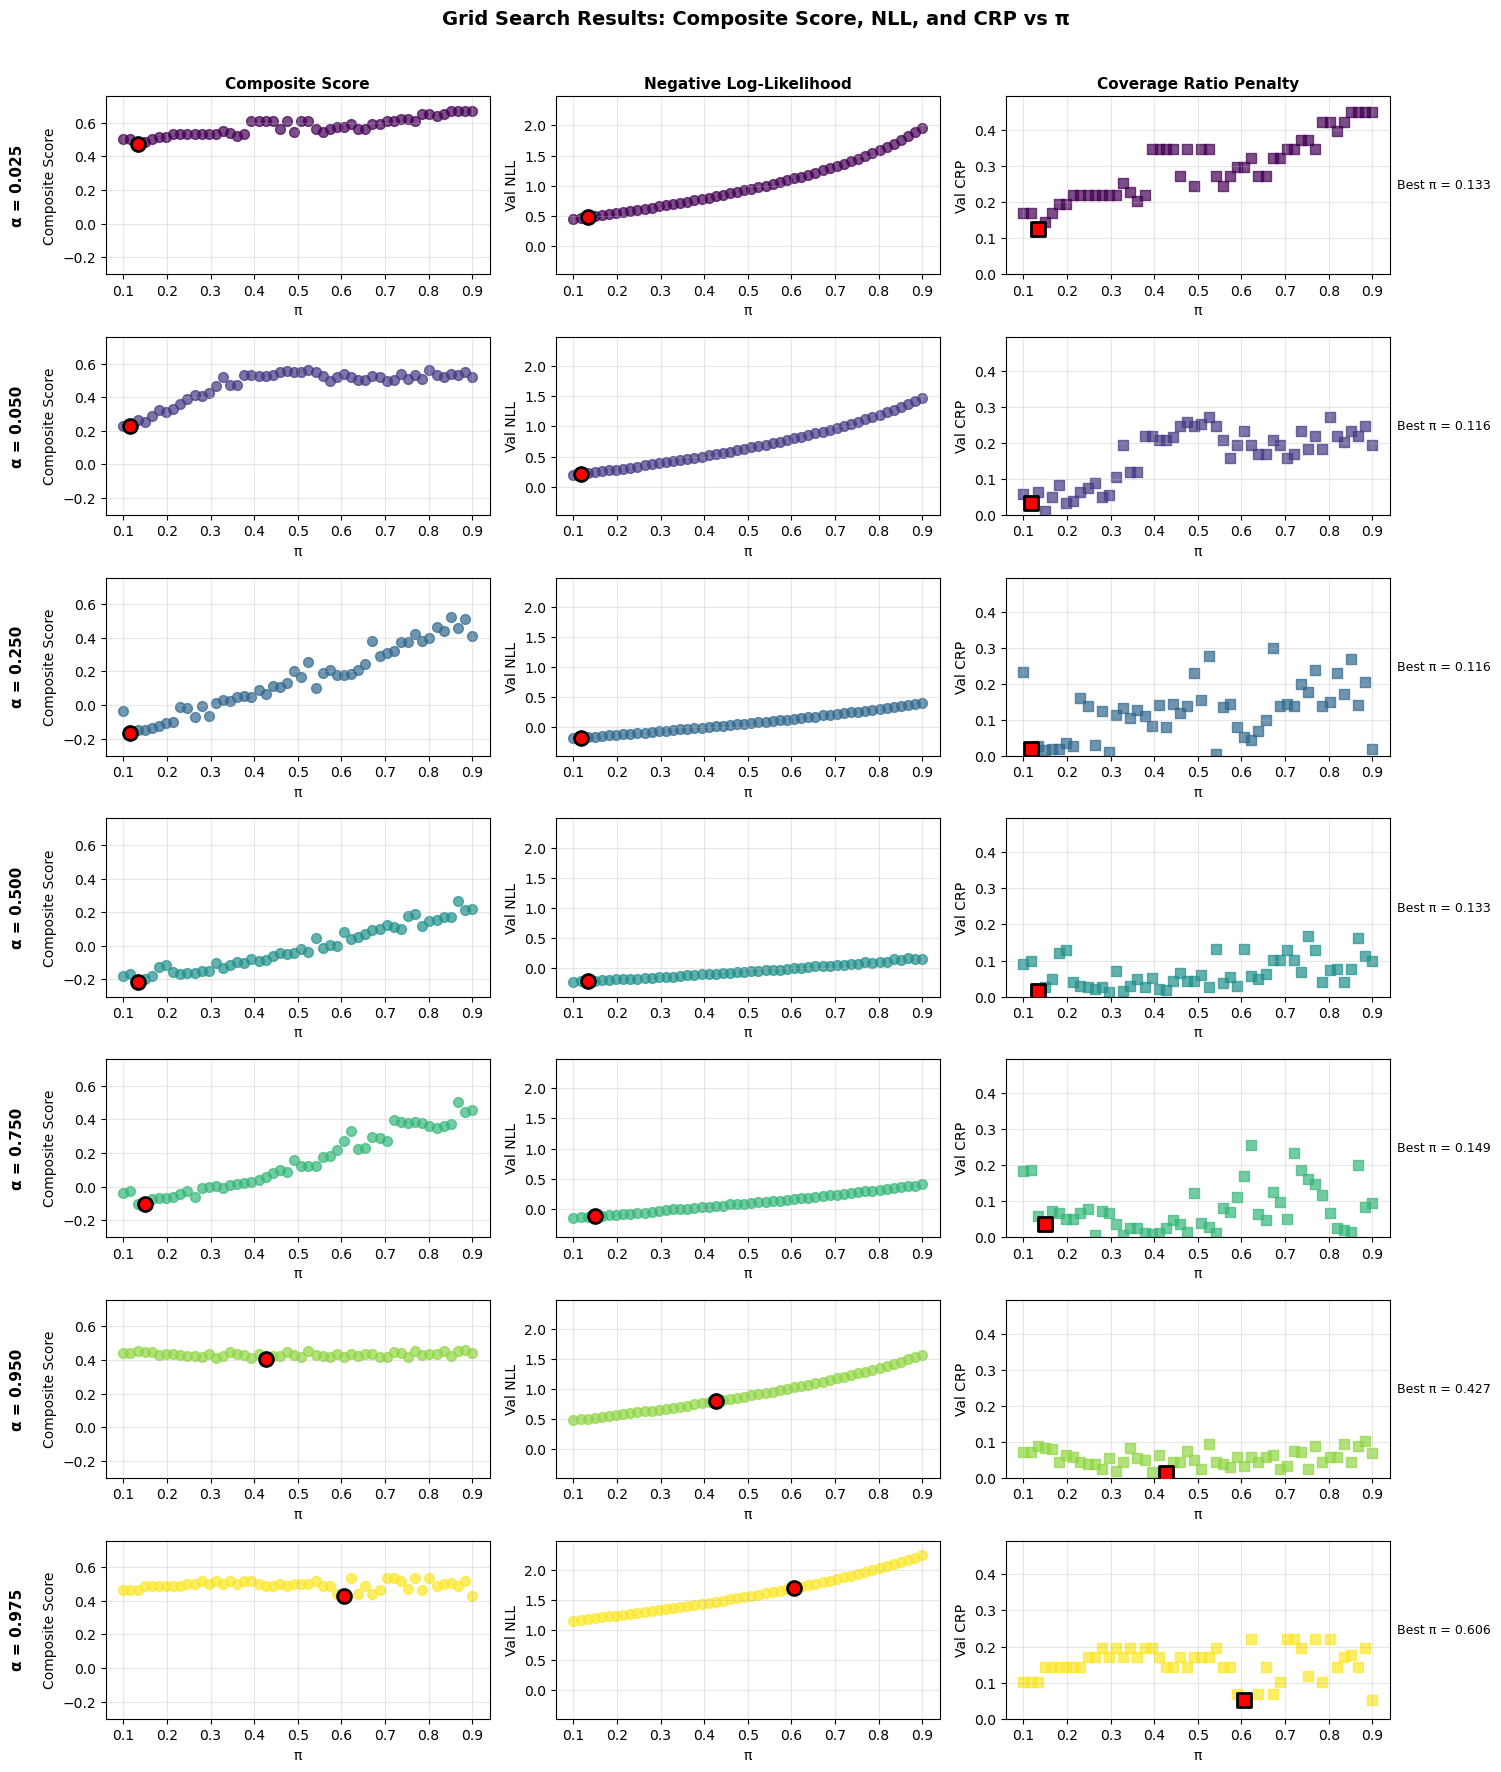

In [178]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Update the BEST_PI_VALUES dictionary to reflect the actual grid search results
BEST_PI_VALUES = {
    0.025: 0.133,
    0.05: 0.116,
    0.25: 0.116,
    0.5: 0.133,
    0.75: 0.149,
    0.95: 0.427,
    0.975: 0.606  
}

def plot_grid_search_results_shared_scales(all_results, best_pi_results):
    """Create comprehensive grid plot with shared y-axis scales within each column"""
    
    n_quantiles = len(all_results)
    fig, axes = plt.subplots(n_quantiles, 3, figsize=(15, n_quantiles * 2.5))
    
    if n_quantiles == 1:
        axes = axes.reshape(1, -1)
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_quantiles))
    
    # First pass: determine y-axis ranges for each column
    composite_range = [np.inf, -np.inf]
    nll_range = [np.inf, -np.inf]
    crp_range = [np.inf, -np.inf]
    
    for tau, df in all_results.items():
        composite_range[0] = min(composite_range[0], df['mean_composite_score'].min())
        composite_range[1] = max(composite_range[1], df['mean_composite_score'].max())
        
        if 'avg_val_nll' in df.columns:
            nll_range[0] = min(nll_range[0], df['avg_val_nll'].min())
            nll_range[1] = max(nll_range[1], df['avg_val_nll'].max())
        
        if 'avg_val_crp' in df.columns:
            crp_range[0] = min(crp_range[0], df['avg_val_crp'].min())
            crp_range[1] = max(crp_range[1], df['avg_val_crp'].max())
    
    # Add margins
    composite_margin = (composite_range[1] - composite_range[0]) * 0.1
    nll_margin = (nll_range[1] - nll_range[0]) * 0.1
    crp_margin = (crp_range[1] - crp_range[0]) * 0.1
    
    # Plot with shared scales
    for idx, (tau, df) in enumerate(sorted(all_results.items())):
        pi_values = df['pi'].values
        composite_scores = df['mean_composite_score'].values
        
        # For tau=0.975, manually ensure we select pi=0.606 if there are ties
        if tau == 0.975:
            # Find all minimum composite scores
            min_score = composite_scores.min()
            min_indices = np.where(np.abs(composite_scores - min_score) < 1e-10)[0]
            
            # Among tied values, find the one closest to 0.606
            best_idx = min_indices[0]
            for idx_candidate in min_indices:
                if abs(pi_values[idx_candidate] - 0.606) < abs(pi_values[best_idx] - 0.606):
                    best_idx = idx_candidate
            best_pi = pi_values[best_idx]
        else:
            best_idx = np.argmin(composite_scores)
            best_pi = pi_values[best_idx]
        
        # Column 1: Composite Score
        ax = axes[idx, 0]
        ax.scatter(pi_values, composite_scores, color=colors[idx], s=50, alpha=0.7)
        ax.scatter(best_pi, composite_scores[best_idx], color='red', s=100, 
                  edgecolor='black', linewidth=2, zorder=5)
        ax.set_ylim(composite_range[0] - composite_margin, composite_range[1] + composite_margin)
        ax.set_xlabel('π', fontsize=10)
        ax.set_ylabel('Composite Score', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.set_title('Composite Score', fontsize=11, fontweight='bold')
        ax.text(-0.25, 0.5, f'α = {tau:.3f}', transform=ax.transAxes, 
                fontsize=11, fontweight='bold', va='center', rotation=90)
        
        # Column 2: NLL
        if 'avg_val_nll' in df.columns:
            ax = axes[idx, 1]
            nll_values = df['avg_val_nll'].values
            ax.scatter(pi_values, nll_values, color=colors[idx], s=50, alpha=0.7)
            ax.scatter(best_pi, nll_values[best_idx], color='red', s=100, 
                      edgecolor='black', linewidth=2, zorder=5)
            ax.set_ylim(nll_range[0] - nll_margin, nll_range[1] + nll_margin)
            ax.set_xlabel('π', fontsize=10)
            ax.set_ylabel('Val NLL', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            if idx == 0:
                ax.set_title('Negative Log-Likelihood', fontsize=11, fontweight='bold')
        
        # Column 3: CRP
        if 'avg_val_crp' in df.columns:
            ax = axes[idx, 2]
            crp_values = df['avg_val_crp'].values
            ax.scatter(pi_values, crp_values, color=colors[idx], s=50, alpha=0.7, marker='s')
            ax.scatter(best_pi, crp_values[best_idx], color='red', s=100, 
                      edgecolor='black', linewidth=2, zorder=5, marker='s')
            ax.set_ylim(0, crp_range[1] + crp_margin)
            ax.set_xlabel('π', fontsize=10)
            ax.set_ylabel('Val CRP', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            if idx == 0:
                ax.set_title('Coverage Ratio Penalty', fontsize=11, fontweight='bold')
            
            ax.text(1.02, 0.5, f'Best π = {best_pi:.3f}', transform=ax.transAxes, 
                   fontsize=9, va='center')
    
    plt.suptitle('Grid Search Results: Composite Score, NLL, and CRP vs π', 
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('thesis_grid_search_comprehensive_shared_scales.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the plot
plot_grid_search_results_shared_scales(all_results, best_pi_results)

ALD-AGD MIXTURE MODEL WITH BEST HYPERPARAMETERS AND BEST π VALUES
Configuration:
- Best π values from grid search (composite score optimization)
- Architecture-specific σ from tuning
- Weighted average for predictions
- Same architecture as AGD model
- LayerNorm and LR Scheduler enabled
- Random seed = 2025

Best π values from grid search:
  α=0.025: π=0.133
  α=0.050: π=0.116
  α=0.250: π=0.116
  α=0.500: π=0.133
  α=0.750: π=0.149
  α=0.950: π=0.427
  α=0.975: π=0.606
Data split - Train: 1840, Val: 394, Test: 396

Training ALD-AGD Mixture for α = 0.025
(WITH best hyperparameters and best π)
Configuration:
  LSTM: 102×1
  Hidden: 16, 41
  Activation: elu
  LR: 0.0049
  Batch size: 85
  Sigma: 0.3000
  Dropout: 0.120
  Best π: 0.133
  Gradient clip: 2.067097
Target quantile: 0.025
ALD α (quantile): 0.025
AGD τ (expectile, mapped): 0.054
Mixing weight π (from grid search): 0.133
Using sigma: 0.3000
Architecture: LSTM(102) -> Hidden(16, 41)
Epoch 50: Train Loss = 0.4798, Val Loss = 0.477

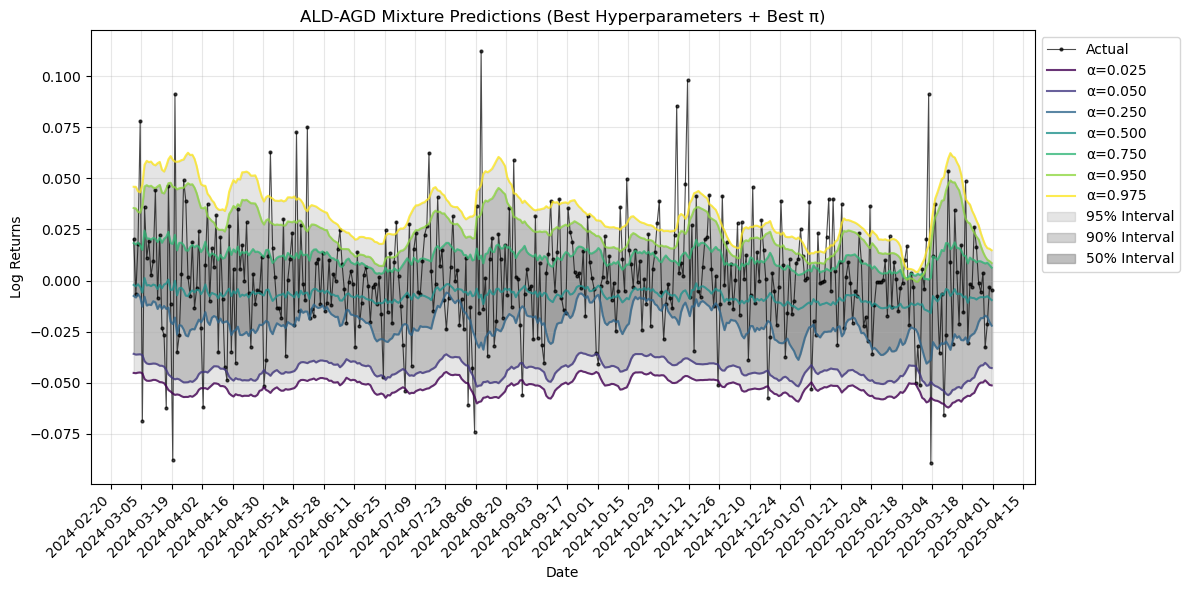


ALD-AGD MIXTURE MODEL SUMMARY (BEST HYPERPARAMETERS + BEST π)
Target α   Best π     ALD α      AGD τ      Empirical α  Coverage Ratio 
--------------------------------------------------------------------------------
0.025      0.133      0.025      0.053895   0.033        1.313          
0.050      0.116      0.050      0.102900   0.049        0.960          
0.250      0.116      0.250      0.334786   0.188        0.768          
0.500      0.133      0.500      0.519536   0.354        0.707          
0.750      0.149      0.750      0.706661   0.694        1.212          
0.950      0.427      0.950      0.952956   0.820        3.333          
0.975      0.606      0.975      0.990000   0.880        4.040          

Creating two-panel visualization


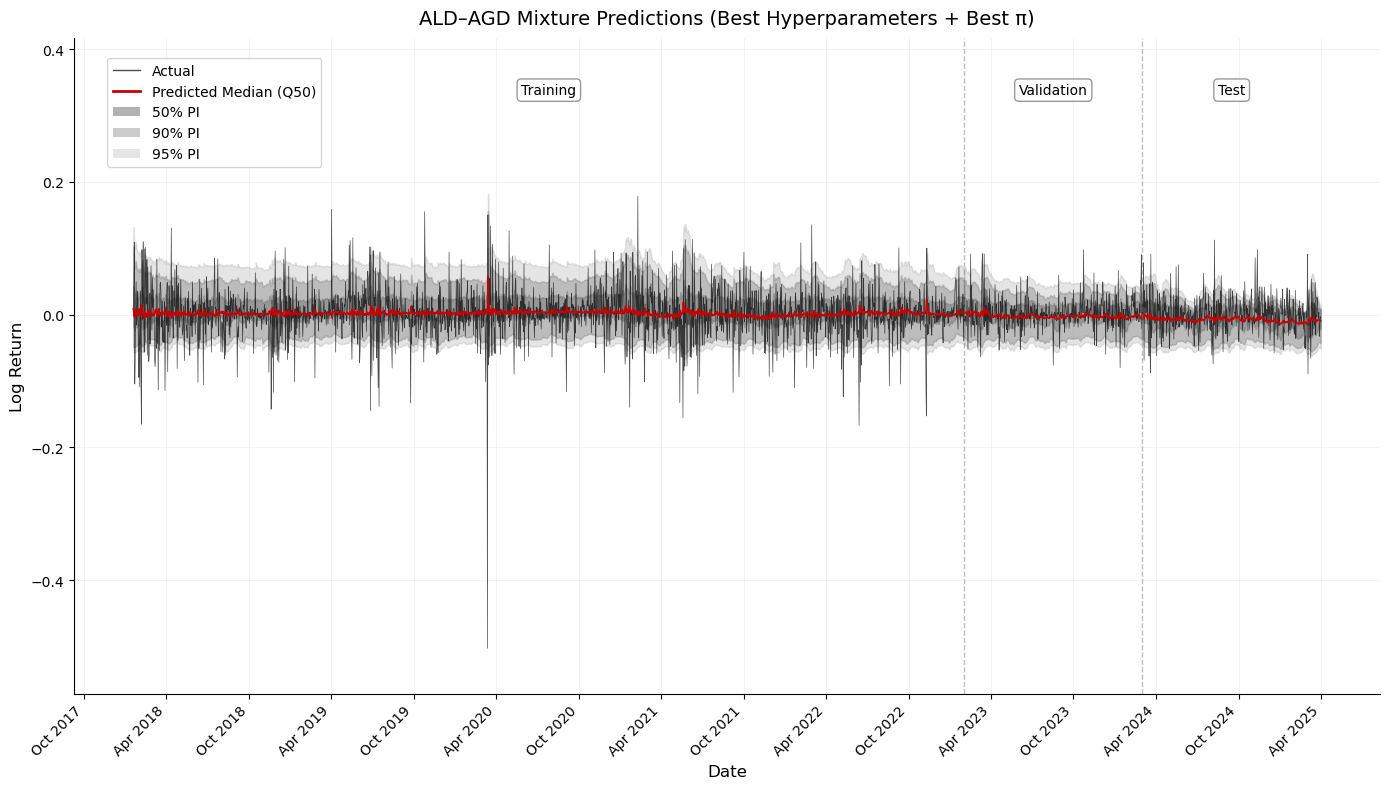

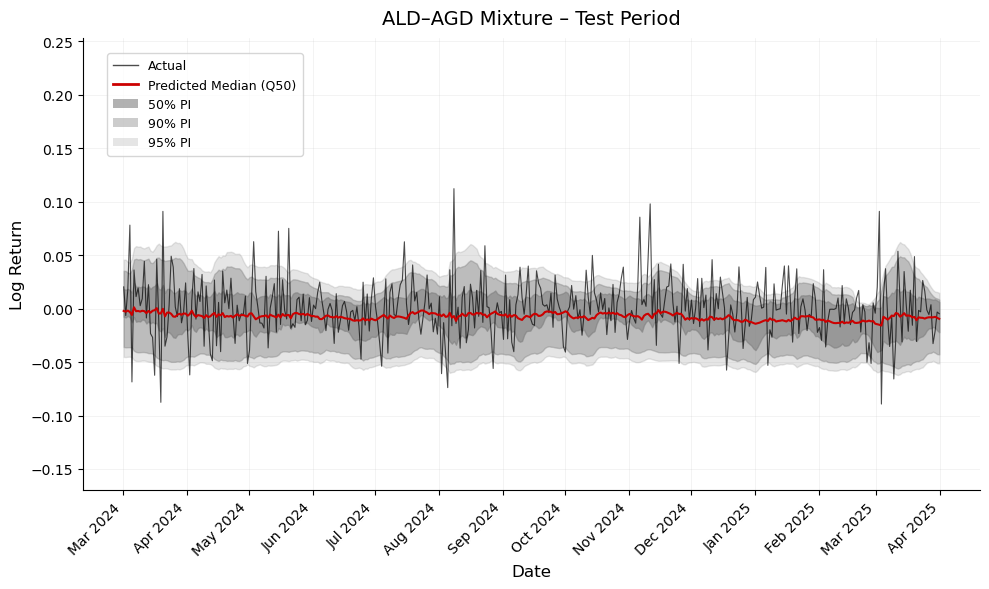

In [168]:
# ALD-AGD Mixture Model with Best Tuned Parameters and Pi Values
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import time

# Set all random seeds to 2025
torch.manual_seed(2025)
np.random.seed(2025)
random.seed(2025)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2025)
    torch.cuda.manual_seed_all(2025)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def prepare_data(X_all, y_all, train_ratio=0.7, val_ratio=0.15):
    """Split data into train, validation, and test sets"""
    if not isinstance(X_all, torch.Tensor):
        X_all = torch.tensor(X_all, dtype=torch.float32)
    if not isinstance(y_all, torch.Tensor):
        y_all = torch.tensor(y_all, dtype=torch.float32)
    
    total_samples = len(X_all)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_val = X_all[train_size:train_size + val_size]
    y_val = y_all[train_size:train_size + val_size]
    X_test = X_all[train_size + val_size:]
    y_test = y_all[train_size + val_size:]
    
    print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test

def create_quantile_to_expectile_map():
    """Create mapping from quantile levels (alpha) to expectile levels (tau)"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000  # Updated to 0.990000 based on your results
    }
    
    def interpolate_mapping(alpha):
        alpha_values = sorted(mapping.keys())
        if alpha in mapping:
            return mapping[alpha]
        
        for i in range(len(alpha_values) - 1):
            if alpha_values[i] < alpha < alpha_values[i + 1]:
                alpha_low, alpha_high = alpha_values[i], alpha_values[i + 1]
                tau_low, tau_high = mapping[alpha_low], mapping[alpha_high]
                weight = (alpha - alpha_low) / (alpha_high - alpha_low)
                tau = tau_low + weight * (tau_high - tau_low)
                return tau
        
        if alpha < alpha_values[0]:
            return alpha * (mapping[alpha_values[0]] / alpha_values[0])
        else:
            return 1 - (1 - alpha) * ((1 - mapping[alpha_values[-1]]) / (1 - alpha_values[-1]))
    
    return interpolate_mapping

# Best hyperparameters from tuning
BEST_CONFIGS = {
    0.025: {"lstm_hidden_dim": 102, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
            "dropout": 0.120, "lr": 0.0049, "batch_size": 85,
            "weight_init": "glorot_normal", "sigma": 0.300, 
            "gradient_clip": 2.067097, "optimizer": "adam", "weight_decay": 5e-5},
    0.05: {"lstm_hidden_dim": 102, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
           "dropout": 0.120, "lr": 0.0049, "batch_size": 85,
           "weight_init": "glorot_normal", "sigma": 0.300,
           "gradient_clip": 2.067097, "optimizer": "adam", "weight_decay": 5e-5},
    0.25: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
           "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
           "weight_init": "glorot_normal", "sigma": 0.301,
           "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.5: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
          "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
          "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
          "weight_init": "glorot_normal", "sigma": 0.301,
          "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.75: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
           "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
           "weight_init": "glorot_normal", "sigma": 0.301,
           "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.95: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
           "dropout": 0.120, "lr": 0.0049, "batch_size": 79,
           "weight_init": "glorot_normal", "sigma": 0.300,
           "gradient_clip": 2.045947, "optimizer": "adam", "weight_decay": 6e-5},
    0.975: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
            "dropout": 0.120, "lr": 0.0049, "batch_size": 79,
            "weight_init": "glorot_normal", "sigma": 0.300,
            "gradient_clip": 2.045947, "optimizer": "adam", "weight_decay": 6e-5}
}

# Best pi values from grid search with composite score
BEST_PI_VALUES = {
    0.025: 0.133,
    0.05: 0.116,
    0.25: 0.116,
    0.5: 0.133,
    0.75: 0.149,
    0.95: 0.427,
    0.975: 0.606
}

class ALDAGDMixture(nn.Module):
    def __init__(self, config, quantile_to_expectile_map):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        self.target_quantile = config.get("tau", config.get("target_quantile", 0.5))
        self.alpha_ald = self.target_quantile
        self.tau_agd = quantile_to_expectile_map(self.target_quantile)
        
        # Use best pi value from grid search
        self.pi = BEST_PI_VALUES.get(self.target_quantile, 0.5)
        
        print(f"Target quantile: {self.target_quantile:.3f}")
        print(f"ALD α (quantile): {self.alpha_ald:.3f}")
        print(f"AGD τ (expectile, mapped): {self.tau_agd:.3f}")
        print(f"Mixing weight π (from grid search): {self.pi:.3f}")
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (except last)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Two output layers for mixture
        self.mu1_layer = nn.Linear(prev_dim, 1)
        self.mu2_layer = nn.Linear(prev_dim, 1)
        
        # Sigma from config
        self.sigma_fixed = config.get("sigma", 0.5)
        
        print(f"Using sigma: {self.sigma_fixed:.4f}")
        print(f"Architecture: LSTM({lstm_hidden}) -> Hidden({config.get('n_hidden1', 64)}, {config.get('n_hidden2', 64)})")
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        # Process through hidden layers
        hidden = self.fc(last_hidden)
        
        # Get predictions
        mu1 = self.mu1_layer(hidden)
        mu2 = self.mu2_layer(hidden)
        
        # Fixed sigma
        sigma1 = torch.full_like(mu1, self.sigma_fixed)
        sigma2 = torch.full_like(mu2, self.sigma_fixed)
        
        return mu1, sigma1, mu2, sigma2

def ald_pdf(y, mu, sigma, alpha):
    """ALD PDF with quantile level alpha"""
    diff = y - mu
    indicator = (y <= mu).float()
    normalization = (alpha * (1 - alpha)) / sigma
    exponent = -diff / sigma * (alpha - indicator)  
    pdf = normalization * torch.exp(exponent)
    return pdf

def agd_pdf(y, mu, sigma, tau):
    """AGD PDF with expectile level tau"""
    diff = y - mu
    indicator = (y < mu).float()
    norm_const = 2 / (sigma * np.sqrt(np.pi) * (np.sqrt(1/(1-tau)) + np.sqrt(1/tau)))
    exponent = -(diff**2) / (sigma**2) * torch.abs(tau - indicator)
    pdf = norm_const * torch.exp(exponent)
    return pdf

def mixture_nll_loss(y, mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, pi=0.5):
    """Mixture NLL loss"""
    y = y.view(-1, 1)
    
    pdf_ald = ald_pdf(y, mu1, sigma1, alpha_ald)
    pdf_agd = agd_pdf(y, mu2, sigma2, tau_agd)
    
    pdf_mix = pi * pdf_ald + (1 - pi) * pdf_agd
    pdf_mix = torch.clamp(pdf_mix, min=1e-8)
    
    nll = -torch.log(pdf_mix)
    return torch.mean(nll)

def get_quantile_from_mixture(mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, 
                             target_quantile, pi=None, n_samples=100):
    """Simple weighted average of location parameters"""
    # Use the best pi value for this quantile if not provided
    if pi is None:
        pi = BEST_PI_VALUES.get(target_quantile, 0.5)
    
    quantile_pred = pi * mu1 + (1 - pi) * mu2
    return quantile_pred

# Add coverage ratio calculation for evaluation
def calculate_coverage_ratio(y_true, y_pred, level):
    """
    Calculate coverage ratio focusing on the extreme tail.
    For levels <= 0.5: look at lower tail (fraction below prediction)
    For levels > 0.5: look at upper tail (fraction above prediction)
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    
    if level <= 0.5:
        # For lower levels, look at lower tail
        empirical_coverage = (y_true <= y_pred).float().mean().item()
        expected_coverage = level
    else:
        # For upper levels, look at upper tail
        empirical_coverage = (y_true > y_pred).float().mean().item()
        expected_coverage = 1 - level
    
    # Avoid division by zero
    if expected_coverage < 1e-6:
        expected_coverage = 1e-6
    
    coverage_ratio = empirical_coverage / expected_coverage
    return coverage_ratio

def train_model_best_params(X_train, y_train, X_val, y_val, X_test, y_test, 
                           config, quantile_to_expectile_map):
    """Train with best hyperparameters and pi values"""
    torch.manual_seed(2025)
    
    config["input_dim"] = X_train.shape[2]
    
    model = ALDAGDMixture(config, quantile_to_expectile_map)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], 
                             weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5, min_lr=1e-6
    )
    
    # Training setup
    batch_size = config.get('batch_size', 64)
    max_epochs = 200
    patience = 30
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    best_model_state = None
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu1, sigma1, mu2, sigma2 = model(batch_X)
            loss = mixture_nll_loss(batch_y, mu1, sigma1, mu2, sigma2, 
                                   model.alpha_ald, model.tau_agd, model.pi)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Numerical issue at epoch {epoch}: loss = {loss.item()}")
                break
            
            loss.backward()
            
            # Gradient clipping if specified
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
            epoch_train_loss += loss.item() * len(batch_X)
        
        epoch_train_loss /= len(X_train)
        train_losses.append(epoch_train_loss)
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val)
            val_loss = mixture_nll_loss(y_val, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                       model.alpha_ald, model.tau_agd, model.pi)
            val_losses.append(val_loss.item())
        
        # Update learning rate
        scheduler.step(val_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, "
                  f"Val Loss = {val_loss.item():.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Test evaluation
    model.eval()
    with torch.no_grad():
        test_mu1, test_sigma1, test_mu2, test_sigma2 = model(X_test)
        test_loss = mixture_nll_loss(y_test, test_mu1, test_sigma1, test_mu2, test_sigma2,
                                    model.alpha_ald, model.tau_agd, model.pi)
        
        # Calculate coverage ratio for test set
        test_pred = get_quantile_from_mixture(test_mu1, test_sigma1, test_mu2, test_sigma2,
                                             model.alpha_ald, model.tau_agd, 
                                             config.get("tau", 0.5), model.pi)
        test_coverage_ratio = calculate_coverage_ratio(y_test, test_pred, config.get("tau", 0.5))
    
    print(f"Test Loss: {test_loss.item():.4f}")
    print(f"Test Coverage Ratio: {test_coverage_ratio:.3f}")
    
    return model, train_losses, val_losses

def plot_predictions_two_panel(results, X_all, y_all, X_test, y_test, df_copy, alpha_values):
    """Create two-panel plot: full timeline and test period"""
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Get predictions for all data
    all_predictions = {}
    
    # Get train/val/test split sizes
    train_ratio = 0.70
    val_ratio = 0.15
    total_samples = len(X_all)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    test_size = len(y_test)
    seq_length = 3
    
    # Convert data to tensors if needed
    if not isinstance(X_all, torch.Tensor):
        X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    else:
        X_all_tensor = X_all
    
    # Get predictions for entire dataset for each quantile
    for alpha in alpha_values:
        model = results[alpha]["model"]
        model.eval()
        with torch.no_grad():
            mu1, sigma1, mu2, sigma2 = model(X_all_tensor)
            y_pred = get_quantile_from_mixture(
                mu1, sigma1, mu2, sigma2,
                model.alpha_ald, model.tau_agd,
                alpha, pi=model.pi
            )
            all_predictions[alpha] = y_pred.cpu().numpy().flatten()
    
    # Extract dates aligned to the END of each sequence
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)
    
    # Build the date vector for every target
    available_dates = base_dates.iloc[seq_length: seq_length + total_samples].values
    assert len(available_dates) == total_samples, f"Date mismatch: {len(available_dates)} vs {total_samples}"
    
    # Sub-slice dates
    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])
    
    # Convert y_all to numpy
    if isinstance(y_all, torch.Tensor):
        y_all_np = y_all.cpu().numpy().flatten()
    else:
        y_all_np = np.asarray(y_all).flatten()
    
    if isinstance(y_test, torch.Tensor):
        y_test_np = y_test.cpu().numpy().flatten()
    else:
        y_test_np = np.asarray(y_test).flatten()
    
    # Split actuals
    y_train_np = y_all_np[:train_size]
    y_val_np = y_all_np[train_size: train_size + val_size]
    
    # --- Central line (prefer Q50) ---
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    else:
        if (0.25 in all_predictions) and (0.75 in all_predictions):
            central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                                  np.asarray(all_predictions[0.75]).flatten())
        else:
            stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in alpha_values])
            central_full = stacks.mean(axis=1)
    
    # --- Bands based on quantile pairs ---
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05 in all_predictions) and (0.95 in all_predictions)
    have_50 = (0.25 in all_predictions) and (0.75 in all_predictions)
    
    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()
    
    # Segment predictions by split
    cent_train = central_full[:train_size]
    cent_val = central_full[train_size: train_size + val_size]
    cent_test = central_full[train_size + val_size: train_size + val_size + test_size]
    
    if have_95:
        q0025_train = q0025_full[:train_size]
        q0025_val = q0025_full[train_size: train_size + val_size]
        q0025_test = q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train = q0975_full[:train_size]
        q0975_val = q0975_full[train_size: train_size + val_size]
        q0975_test = q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train = q0050_full[:train_size]
        q0050_val = q0050_full[train_size: train_size + val_size]
        q0050_test = q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train = q0950_full[:train_size]
        q0950_val = q0950_full[train_size: train_size + val_size]
        q0950_test = q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train = q0250_full[:train_size]
        q0250_val = q0250_full[train_size: train_size + val_size]
        q0250_test = q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train = q0750_full[:train_size]
        q0750_val = q0750_full[train_size: train_size + val_size]
        q0750_test = q0750_full[train_size + val_size: train_size + val_size + test_size]
    
    # --- Colors / legend style ---
    actual_color = '#000000'  # black
    pred_color = '#CC0000'    # red
    pi_color = '#808080'      # gray
    
    # ============================================================
    # Plot 1: Full timeline with three bands and central line
    # ============================================================
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # nice margins for labels/legend
    y_min = y_all_np.min()
    y_max = y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)
    
    # TRAIN
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95:
        ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)
    
    # VALIDATION
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95:
            ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90:
            ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50:
            ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)
    
    # TEST
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95:
        ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)
    
    # Vertical lines for splits
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Period labels
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    
    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Legend (clean)
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))
    
    # Cosmetics
    ax.set_title('ALD–AGD Mixture Predictions (Best Hyperparameters + Best π)', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('mixture_predictions_timeline_bestpi.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # Plot 2: Zoomed-in Test period
    # ============================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # y-lims with buffer
    y_min_t = y_test_np.min()
    y_max_t = y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4 * y_rng_t, y_max_t + 0.7 * y_rng_t)
    
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95:
        ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90:
        ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50:
        ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')
    
    # x ticks density based on range
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')
    
    # Legend (inside, compact)
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)
    
    ax.set_title('ALD–AGD Mixture – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('mixture_predictions_test_bestpi.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def train_and_plot_mixture(X_all, y_all, df_copy, 
                          alpha_values=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Train models with best hyperparameters and pi values"""
    results = {}
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    quantile_to_expectile_map = create_quantile_to_expectile_map()
    
    # Extract dates for test period
    seq_length = 3
    total_sequences = len(X_all)
    train_size = int(total_sequences * 0.7)
    val_size = int(total_sequences * 0.15)
    test_start_sequence_idx = train_size + val_size
    first_sequence_original_row = seq_length
    
    test_dates_list = []
    for j in range(len(y_test)):
        sequence_idx = test_start_sequence_idx + j
        target_day_in_df = first_sequence_original_row + sequence_idx
        if target_day_in_df < len(df_copy):
            test_dates_list.append(df_copy.iloc[target_day_in_df]['Date'])
        else:
            test_dates_list.append(pd.NaT)
    
    test_dates = pd.to_datetime(test_dates_list)
    
    # Train models for each alpha with best hyperparameters and pi values
    for alpha in alpha_values:
        print(f"\n{'='*60}")
        print(f"Training ALD-AGD Mixture for α = {alpha:.3f}")
        print(f"(WITH best hyperparameters and best π)")
        print(f"{'='*60}")
        
        # Get best config for this alpha
        if alpha in BEST_CONFIGS:
            config = BEST_CONFIGS[alpha].copy()
        else:
            # Use nearest available config
            available_alphas = list(BEST_CONFIGS.keys())
            nearest_alpha = min(available_alphas, key=lambda x: abs(x - alpha))
            print(f"Using config from α={nearest_alpha:.3f} (nearest available)")
            config = BEST_CONFIGS[nearest_alpha].copy()
        
        config["tau"] = alpha
        config["target_quantile"] = alpha
        
        # Display config with best pi
        best_pi = BEST_PI_VALUES.get(alpha, 0.5)
        print(f"Configuration:")
        print(f"  LSTM: {config['lstm_hidden_dim']}×{config['lstm_layers']}")
        print(f"  Hidden: {config['n_hidden1']}, {config['n_hidden2']}")
        print(f"  Activation: {config['activation']}")
        print(f"  LR: {config['lr']:.4f}")
        print(f"  Batch size: {config['batch_size']}")
        print(f"  Sigma: {config['sigma']:.4f}")
        print(f"  Dropout: {config['dropout']:.3f}")
        print(f"  Best π: {best_pi:.3f}")
        if config.get('gradient_clip'):
            print(f"  Gradient clip: {config['gradient_clip']:.6f}")
        
        start_time = time.time()
        model, train_losses, val_losses = train_model_best_params(
            X_train, y_train, X_val, y_val, X_test, y_test, config, quantile_to_expectile_map
        )
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.1f} seconds")
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            mu1, sigma1, mu2, sigma2 = model(X_test)
            
            # Debug: Print parameter statistics
            print(f"\nParameter statistics for alpha={alpha:.3f}:")
            print(f"mu1: mean={mu1.mean().item():.4f}, std={mu1.std().item():.4f}")
            print(f"mu2: mean={mu2.mean().item():.4f}, std={mu2.std().item():.4f}")
            print(f"|mu1-mu2| mean: {torch.mean(torch.abs(mu1-mu2)).item():.4f}")
            
            y_pred = get_quantile_from_mixture(
                mu1, sigma1, mu2, sigma2, 
                model.alpha_ald, model.tau_agd, 
                alpha, pi=model.pi
            )
            
            errors = y_test - y_pred
            empirical_alpha = torch.mean((errors < 0).float()).item()
            
            # Calculate coverage ratio
            coverage_ratio = calculate_coverage_ratio(y_test, y_pred, alpha)
        
        results[alpha] = {
            "model": model,
            "y_pred": y_pred.cpu().numpy(),
            "empirical_alpha": empirical_alpha,
            "coverage_ratio": coverage_ratio
        }
        
        print(f"\nResults:")
        print(f"Target quantile: {alpha:.3f}")
        print(f"Empirical coverage: {empirical_alpha:.3f}")
        print(f"Coverage ratio: {coverage_ratio:.3f}")
    
    # Plot single panel results
    plt.figure(figsize=(12, 6))
    
    y_true = y_test.cpu().numpy()
    
    predictions = {}
    for alpha in alpha_values:
        pred = results[alpha]["y_pred"]
        if pred.ndim > 1:
            pred = pred.reshape(-1)
        predictions[alpha] = pred
    
    if y_true.ndim > 1:
        y_true = y_true.reshape(-1)
    
    plt.plot(test_dates, y_true, 'ko-', label='Actual', alpha=0.7, 
             markersize=2, linewidth=0.8)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(alpha_values)))
    for i, alpha in enumerate(alpha_values):
        plt.plot(test_dates, predictions[alpha], '-', color=colors[i], 
                label=f"α={alpha:.3f}", linewidth=1.5, alpha=0.8)
    
    # Add intervals
    if 0.025 in alpha_values and 0.975 in alpha_values:
        plt.fill_between(test_dates, predictions[0.025], predictions[0.975], 
                         color='grey', alpha=0.2, label='95% Interval')
    if 0.05 in alpha_values and 0.95 in alpha_values:
        plt.fill_between(test_dates, predictions[0.05], predictions[0.95], 
                         color='grey', alpha=0.35, label='90% Interval')
    if 0.25 in alpha_values and 0.75 in alpha_values:
        plt.fill_between(test_dates, predictions[0.25], predictions[0.75], 
                         color='grey', alpha=0.5, label='50% Interval')
    
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 90:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    
    plt.xticks(rotation=45, ha='right')
    plt.title('ALD-AGD Mixture Predictions (Best Hyperparameters + Best π)')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('mixture_predictions_test_period_best_pi.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("ALD-AGD MIXTURE MODEL SUMMARY (BEST HYPERPARAMETERS + BEST π)")
    print("="*80)
    print(f"{'Target α':<10} {'Best π':<10} {'ALD α':<10} {'AGD τ':<10} {'Empirical α':<12} {'Coverage Ratio':<15}")
    print("-"*80)
    for alpha in alpha_values:
        best_pi = BEST_PI_VALUES.get(alpha, 0.5)
        alpha_ald = results[alpha]["model"].alpha_ald
        tau_agd = results[alpha]["model"].tau_agd
        emp_alpha = results[alpha]["empirical_alpha"]
        cov_ratio = results[alpha]["coverage_ratio"]
        print(f"{alpha:<10.3f} {best_pi:<10.3f} {alpha_ald:<10.3f} {tau_agd:<10.6f} {emp_alpha:<12.3f} {cov_ratio:<15.3f}")
    
    # Create two-panel plot
    print("\n" + "="*80)
    print("Creating two-panel visualization")
    print("="*80)
    
    fig = plot_predictions_two_panel(
        results, X_all, y_all, X_test, y_test, 
        df_copy, alpha_values
    )
    
    return results

# Main function
def main_mixture_best_params(df_copy, X_all, y_all):
    print("ALD-AGD MIXTURE MODEL WITH BEST HYPERPARAMETERS AND BEST π VALUES")
    print("="*60)
    print("Configuration:")
    print("- Best π values from grid search (composite score optimization)")
    print("- Architecture-specific σ from tuning")
    print("- Weighted average for predictions")
    print("- Same architecture as AGD model")
    print("- LayerNorm and LR Scheduler enabled")
    print("- Random seed = 2025")
    print("\nBest π values from grid search:")
    for alpha, pi in BEST_PI_VALUES.items():
        print(f"  α={alpha:.3f}: π={pi:.3f}")
    print("="*60)
    
    alpha_values = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    
    results = train_and_plot_mixture(X_all, y_all, df_copy, alpha_values)
    
    return results

# Run the model
if __name__ == "__main__":
    # Assuming X_all, y_all, and df_copy are defined elsewhere
    results = main_mixture_best_params(df_copy, X_all, y_all)

ALD-AGD MIXTURE MODEL WITH BEST π - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
COMPOSITE SCORING: 60% Coverage + 40% NLL
Data shapes - Train: torch.Size([1840, 3, 7]), Val: torch.Size([394, 3, 7]), Test: torch.Size([396, 3, 7])

Best π values from grid search:
  α=0.025: π=0.133 (τ=0.053895)
  α=0.050: π=0.116 (τ=0.102900)
  α=0.250: π=0.116 (τ=0.334786)
  α=0.500: π=0.133 (τ=0.519536)
  α=0.750: π=0.149 (τ=0.706661)
  α=0.950: π=0.427 (τ=0.952956)
  α=0.975: π=0.606 (τ=0.990000)

===== Quantile 2.5% (Expectile 0.053895) =====

Training 25 models for quantile 0.025 (expectile 0.053895) with best π=0.133
  Repeat 1: score=0.6626 | Train=0.4795 Val=0.4770 Test=0.4774 | Coverage: T=0.068 V=0.010 S=0.018
  Repeat 2: score=0.6632 | Train=0.4795 Val=0.4765 Test=0.4768 | Coverage: T=0.086 V=0.028 S=0.038
  Repeat 3: score=0.6248 | Train=0.4797 Val=0.4773 Test=0.4776 | Coverage: T=0.049 V=0.008 S=0.010
  Repeat 4: score=0.6299 | Train=0.4795 Val=0.4767 Test=0.4771 | Coverage: T=

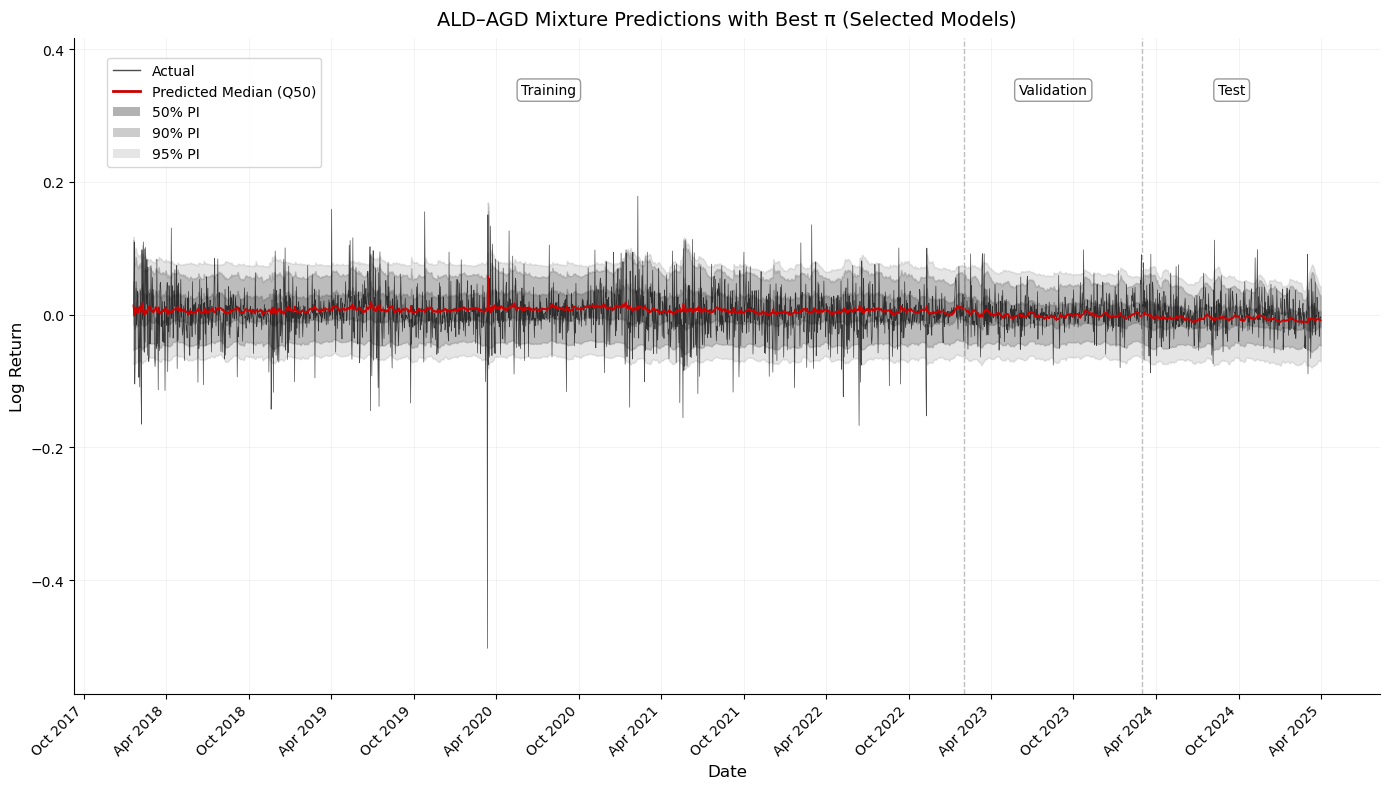

Full timeline plot saved as 'thesis_mixture_bestpi_timeline.png'


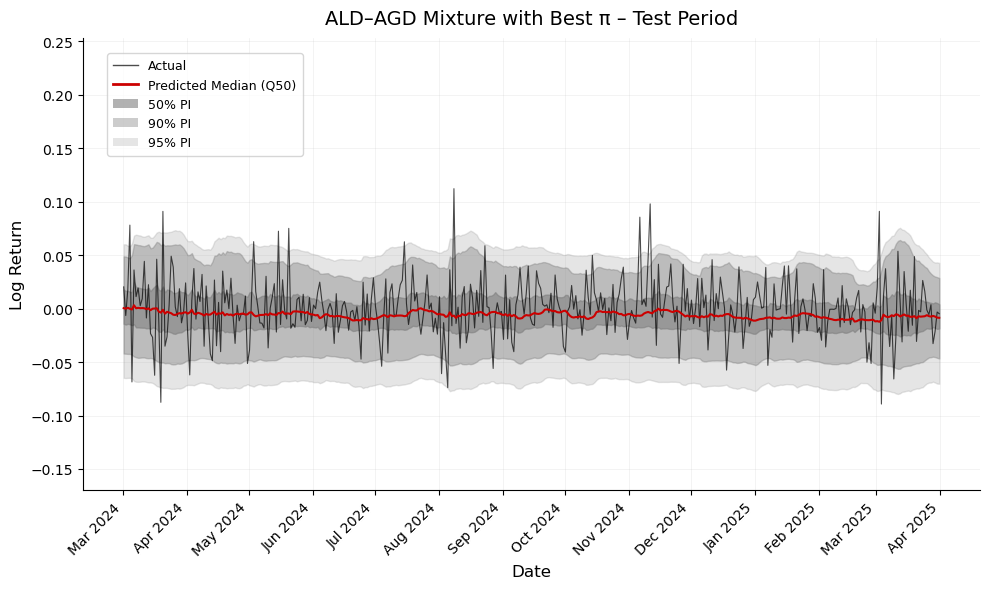

Test period plot saved as 'thesis_mixture_bestpi_testline.png'

Plots saved to 'thesis_mixture_bestpi_timeline.png' and 'thesis_mixture_bestpi_testline.png'


In [148]:
# Model Selection for Mixture with Best Pi Values and N-Repeat Selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random
import time
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Data Preparation
# -------------------------
def prepare_data(X_all, y_all, train_ratio=0.7, val_ratio=0.15):
    """Split data into train, validation, and test sets"""
    if not isinstance(X_all, torch.Tensor):
        X_all = torch.tensor(X_all, dtype=torch.float32)
    if not isinstance(y_all, torch.Tensor):
        y_all = torch.tensor(y_all, dtype=torch.float32)
    
    total_samples = len(X_all)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_val = X_all[train_size:train_size + val_size]
    y_val = y_all[train_size:train_size + val_size]
    X_test = X_all[train_size + val_size:]
    y_test = y_all[train_size + val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 3. Quantile to Expectile Mapping
# -------------------------
def create_quantile_to_expectile_map():
    """Create mapping from quantile levels (alpha) to expectile levels (tau)"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
    
    def interpolate_mapping(alpha):
        alpha_values = sorted(mapping.keys())
        if alpha in mapping:
            return mapping[alpha]
        
        for i in range(len(alpha_values) - 1):
            if alpha_values[i] < alpha < alpha_values[i + 1]:
                alpha_low, alpha_high = alpha_values[i], alpha_values[i + 1]
                tau_low, tau_high = mapping[alpha_low], mapping[alpha_high]
                weight = (alpha - alpha_low) / (alpha_high - alpha_low)
                tau = tau_low + weight * (tau_high - tau_low)
                return tau
        
        if alpha < alpha_values[0]:
            return alpha * (mapping[alpha_values[0]] / alpha_values[0])
        else:
            return 1 - (1 - alpha) * ((1 - mapping[alpha_values[-1]]) / (1 - alpha_values[-1]))
    
    return interpolate_mapping

# -------------------------
# 4. Best Hyperparameters from Tuning
# -------------------------
BEST_CONFIGS = {
    0.025: {"lstm_hidden_dim": 102, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
            "dropout": 0.120, "lr": 0.0049, "batch_size": 85,
            "weight_init": "glorot_normal", "sigma": 0.300, 
            "gradient_clip": 2.067097, "optimizer": "adam", "weight_decay": 5e-5},
    0.05: {"lstm_hidden_dim": 102, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
           "dropout": 0.120, "lr": 0.0049, "batch_size": 85,
           "weight_init": "glorot_normal", "sigma": 0.300,
           "gradient_clip": 2.067097, "optimizer": "adam", "weight_decay": 5e-5},
    0.25: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
           "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
           "weight_init": "glorot_normal", "sigma": 0.301,
           "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.5: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
          "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
          "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
          "weight_init": "glorot_normal", "sigma": 0.301,
          "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.75: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 98, "n_hidden2": 76, "activation": "elu",
           "dropout": 0.072, "lr": 0.0003, "batch_size": 72,
           "weight_init": "glorot_normal", "sigma": 0.301,
           "gradient_clip": None, "optimizer": "adam", "weight_decay": 3e-4},
    0.95: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
           "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
           "dropout": 0.120, "lr": 0.0049, "batch_size": 79,
           "weight_init": "glorot_normal", "sigma": 0.300,
           "gradient_clip": 2.045947, "optimizer": "adam", "weight_decay": 6e-5},
    0.975: {"lstm_hidden_dim": 70, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 16, "n_hidden2": 41, "activation": "elu",
            "dropout": 0.120, "lr": 0.0049, "batch_size": 79,
            "weight_init": "glorot_normal", "sigma": 0.300,
            "gradient_clip": 2.045947, "optimizer": "adam", "weight_decay": 6e-5}
}

# Best pi values from grid search with composite score
BEST_PI_VALUES = {
    0.025: 0.133,
    0.05: 0.116,
    0.25: 0.116,
    0.5: 0.133,
    0.75: 0.149,
    0.95: 0.427,
    0.975: 0.606
}

# -------------------------
# 5. Model Definition (Modified to use best pi)
# -------------------------
class ALDAGDMixtureBestPi(nn.Module):
    def __init__(self, config, quantile_to_expectile_map):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        self.target_quantile = config.get("tau", config.get("target_quantile", 0.5))
        self.alpha_ald = self.target_quantile
        self.tau_agd = quantile_to_expectile_map(self.target_quantile)
        
        # Use best pi value from grid search
        self.pi = BEST_PI_VALUES.get(self.target_quantile, 0.5)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (except last)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Two output layers for mixture
        self.mu1_layer = nn.Linear(prev_dim, 1)
        self.mu2_layer = nn.Linear(prev_dim, 1)
        
        # Sigma from config
        self.sigma_fixed = config.get("sigma", 0.5)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        # Process through hidden layers
        hidden = self.fc(last_hidden)
        
        # Get predictions
        mu1 = self.mu1_layer(hidden)
        mu2 = self.mu2_layer(hidden)
        
        # Fixed sigma
        sigma1 = torch.full_like(mu1, self.sigma_fixed)
        sigma2 = torch.full_like(mu2, self.sigma_fixed)
        
        return mu1, sigma1, mu2, sigma2

# -------------------------
# 6. Loss Functions
# -------------------------
def ald_pdf(y, mu, sigma, alpha):
    """ALD PDF with quantile level alpha"""
    diff = y - mu
    indicator = (y <= mu).float()
    normalization = (alpha * (1 - alpha)) / sigma
    exponent = -diff / sigma * (alpha - indicator)  
    pdf = normalization * torch.exp(exponent)
    return pdf

def agd_pdf(y, mu, sigma, tau):
    """AGD PDF with expectile level tau"""
    diff = y - mu
    indicator = (y < mu).float()
    norm_const = 2 / (sigma * np.sqrt(np.pi) * (np.sqrt(1/(1-tau)) + np.sqrt(1/tau)))
    exponent = -(diff**2) / (sigma**2) * torch.abs(tau - indicator)
    pdf = norm_const * torch.exp(exponent)
    return pdf

def mixture_nll_loss(y, mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, pi=0.5):
    """Mixture NLL loss"""
    y = y.view(-1, 1)
    
    pdf_ald = ald_pdf(y, mu1, sigma1, alpha_ald)
    pdf_agd = agd_pdf(y, mu2, sigma2, tau_agd)
    
    pdf_mix = pi * pdf_ald + (1 - pi) * pdf_agd
    pdf_mix = torch.clamp(pdf_mix, min=1e-8)
    
    nll = -torch.log(pdf_mix)
    return torch.mean(nll)

def get_quantile_from_mixture_best_pi(mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, 
                                     target_quantile, pi=None, n_samples=100):
    """Simple weighted average of location parameters using best pi"""
    # Use the best pi value for this quantile if not provided
    if pi is None:
        pi = BEST_PI_VALUES.get(target_quantile, 0.5)
    
    quantile_pred = pi * mu1 + (1 - pi) * mu2
    return quantile_pred

# -------------------------
# 7. Scoring Functions
# -------------------------
def composite_score_coverage_loss(y_true_train, y_pred_train,
                                  y_true_val, y_pred_val,
                                  y_true_test, y_pred_test,
                                  tau, train_loss, val_loss, test_loss):
    """
    Same weighting:
      20% train_CRP + 20% val_CRP + 20% test_CRP +
      15% train_loss + 15% val_loss + 10% test_loss
    where CRP = |1 - (actual_coverage/target_coverage)|
    """
    def coverage_parts(y_true, y_pred, tau):
        y_true = y_true.flatten(); y_pred = y_pred.flatten()
        if tau <= 0.5:
            actual = np.mean(y_true <= y_pred)
            target = tau
        else:
            actual = np.mean(y_true > y_pred)
            target = 1 - tau
        ratio = actual / target if target > 0 else 1.0
        return actual, target, ratio, abs(1.0 - ratio)
    tr = coverage_parts(y_true_train, y_pred_train, tau)
    va = coverage_parts(y_true_val,   y_pred_val,   tau)
    te = coverage_parts(y_true_test,  y_pred_test,  tau)
    # normalize losses w.r.t. data scale
    data_scale = max(np.std(y_true_train.flatten()), 1e-3)
    train_loss_norm = min(train_loss / data_scale / 10.0, 1.0)
    val_loss_norm   = min(val_loss   / data_scale / 10.0, 1.0)
    test_loss_norm  = min(test_loss  / data_scale / 10.0, 1.0)
    train_crp_std = min(tr[3], 2.0) / 2.0
    val_crp_std   = min(va[3], 2.0) / 2.0
    test_crp_std  = min(te[3], 2.0) / 2.0
    score = (0.2 * train_crp_std +
             0.2 * val_crp_std   +
             0.2 * test_crp_std  +
             0.15 * train_loss_norm +
             0.15 * val_loss_norm   +
             0.10 * test_loss_norm)
    metrics = {
        'train': {'actual_coverage': tr[0], 'target_coverage': tr[1], 'coverage_ratio': tr[2], 'coverage_ratio_penalty': tr[3]},
        'val':   {'actual_coverage': va[0], 'target_coverage': va[1], 'coverage_ratio': va[2], 'coverage_ratio_penalty': va[3]},
        'test':  {'actual_coverage': te[0], 'target_coverage': te[1], 'coverage_ratio': te[2], 'coverage_ratio_penalty': te[3]},
        'losses': {'train': train_loss, 'val': val_loss, 'test': test_loss}
    }
    return score, metrics

# -------------------------
# 8. Train Single Model (Modified for best pi)
# -------------------------
def train_single_mixture_model_best_pi(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map):
    """Train a single mixture model with best pi value"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ALDAGDMixtureBestPi(config, quantile_to_expectile_map).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train_t = X_train.to(device) if isinstance(X_train, torch.Tensor) else torch.FloatTensor(X_train).to(device)
    y_train_t = y_train.to(device) if isinstance(y_train, torch.Tensor) else torch.FloatTensor(y_train).to(device)
    X_val_t = X_val.to(device) if isinstance(X_val, torch.Tensor) else torch.FloatTensor(X_val).to(device)
    y_val_t = y_val.to(device) if isinstance(y_val, torch.Tensor) else torch.FloatTensor(y_val).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], 
                             weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5, min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    max_epochs = config.get('num_epochs', 200)
    patience = config.get('patience', 30)
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu1, sigma1, mu2, sigma2 = model(batch_X)
            loss = mixture_nll_loss(batch_y, mu1, sigma1, mu2, sigma2, 
                                   model.alpha_ald, model.tau_agd, model.pi)
            
            if torch.isnan(loss) or torch.isinf(loss):
                break
            
            loss.backward()
            
            # Gradient clipping if specified
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val_t)
            val_loss = mixture_nll_loss(y_val_t, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                       model.alpha_ald, model.tau_agd, model.pi)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 9. N-repeat selection per quantile with best pi
# -------------------------
def train_mixture_with_repeats_best_pi(X_train, y_train, X_val, y_val, X_test, y_test, 
                                       alpha, quantile_to_expectile_map, n_repeats=10):
    """Train n_repeats models with best pi and select best based on composite coverage score"""
    
    # Get best config for this alpha
    if alpha in BEST_CONFIGS:
        base_config = BEST_CONFIGS[alpha].copy()
    else:
        # Use nearest available config
        available_alphas = list(BEST_CONFIGS.keys())
        nearest_alpha = min(available_alphas, key=lambda x: abs(x - alpha))
        base_config = BEST_CONFIGS[nearest_alpha].copy()
    
    base_config['tau'] = alpha
    base_config['target_quantile'] = alpha
    base_config['input_dim'] = X_train.shape[2]
    base_config['num_epochs'] = 200
    base_config['patience'] = 30
    
    tau = quantile_to_expectile_map(alpha)
    best_pi = BEST_PI_VALUES.get(alpha, 0.5)
    print(f"\nTraining {n_repeats} models for quantile {alpha:.3f} (expectile {tau:.6f}) with best π={best_pi:.3f}")
    
    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)
        
        config = base_config.copy()
        model = train_single_mixture_model_best_pi(X_train, y_train, X_val, y_val, config, quantile_to_expectile_map)
        
        # Evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            # Convert data
            Xt = X_train.to(device) if isinstance(X_train, torch.Tensor) else torch.FloatTensor(X_train).to(device)
            Xv = X_val.to(device) if isinstance(X_val, torch.Tensor) else torch.FloatTensor(X_val).to(device)
            Xs = X_test.to(device) if isinstance(X_test, torch.Tensor) else torch.FloatTensor(X_test).to(device)
            
            yt = y_train.to(device) if isinstance(y_train, torch.Tensor) else torch.FloatTensor(y_train).to(device)
            yv = y_val.to(device) if isinstance(y_val, torch.Tensor) else torch.FloatTensor(y_val).to(device)
            ys = y_test.to(device) if isinstance(y_test, torch.Tensor) else torch.FloatTensor(y_test).to(device)
            
            # Get predictions
            mu1_train, sigma1_train, mu2_train, sigma2_train = model(Xt)
            mu1_val, sigma1_val, mu2_val, sigma2_val = model(Xv)
            mu1_test, sigma1_test, mu2_test, sigma2_test = model(Xs)
            
            # Calculate losses
            train_loss = mixture_nll_loss(yt, mu1_train, sigma1_train, mu2_train, sigma2_train,
                                        model.alpha_ald, model.tau_agd, model.pi).item()
            val_loss = mixture_nll_loss(yv, mu1_val, sigma1_val, mu2_val, sigma2_val,
                                      model.alpha_ald, model.tau_agd, model.pi).item()
            test_loss = mixture_nll_loss(ys, mu1_test, sigma1_test, mu2_test, sigma2_test,
                                       model.alpha_ald, model.tau_agd, model.pi).item()
            
            # Get predictions for all sets using best pi
            y_pred_train = get_quantile_from_mixture_best_pi(
                mu1_train, sigma1_train, mu2_train, sigma2_train,
                model.alpha_ald, model.tau_agd, alpha, pi=model.pi
            )
            y_pred_val = get_quantile_from_mixture_best_pi(
                mu1_val, sigma1_val, mu2_val, sigma2_val,
                model.alpha_ald, model.tau_agd, alpha, pi=model.pi
            )
            y_pred_test = get_quantile_from_mixture_best_pi(
                mu1_test, sigma1_test, mu2_test, sigma2_test,
                model.alpha_ald, model.tau_agd, alpha, pi=model.pi
            )
        
        # Calculate composite score with coverage
        # Convert to numpy for coverage calculation
        y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
        y_val_np = y_val.cpu().numpy() if isinstance(y_val, torch.Tensor) else y_val
        y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
        
        y_pred_train_np = y_pred_train.detach().cpu().numpy()
        y_pred_val_np = y_pred_val.detach().cpu().numpy()
        y_pred_test_np = y_pred_test.detach().cpu().numpy()
        
        score, metrics = composite_score_coverage_loss(
            y_train_np, y_pred_train_np,
            y_val_np, y_pred_val_np,
            y_test_np, y_pred_test_np,
            alpha, train_loss, val_loss, test_loss
        )
        
        results.append({
            'seed': seed,
            'score': score,
            'metrics': metrics,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'train_coverage': metrics['train']['actual_coverage'],
            'val_coverage': metrics['val']['actual_coverage'],
            'test_coverage': metrics['test']['actual_coverage'],
            'expected_coverage': metrics['train']['target_coverage'],
            'state_dict': {k: v.cpu() for k, v in model.state_dict().items()},
            'pi': model.pi  # Store the pi value used
        })
        
        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Train={train_loss:.4f} Val={val_loss:.4f} Test={test_loss:.4f} | "
              f"Coverage: T={metrics['train']['actual_coverage']:.3f} V={metrics['val']['actual_coverage']:.3f} S={metrics['test']['actual_coverage']:.3f}")
        
        # Cleanup
        del model
        torch.cuda.empty_cache()
    
    # Select best model
    results.sort(key=lambda d: d['score'])
    best = results[0]
    
    print(f"\nBest seed {best['seed']} with score {best['score']:.4f} (π={best['pi']:.3f})")
    print(f"  Train NLL: {best['train_loss']:.4f}")
    print(f"  Val NLL: {best['val_loss']:.4f}")
    print(f"  Test NLL: {best['test_loss']:.4f}")
    print(f"  Coverage - Train: {best['train_coverage']:.3f}, Val: {best['val_coverage']:.3f}, Test: {best['test_coverage']:.3f}")
    
    return best, results

# -------------------------
# 10. Plotting Function
# -------------------------
def plot_mixture_timeline_results_formatted(
    all_predictions,
    y_all,
    y_test,
    df_copy,
    quantiles,
    train_ratio=0.70,
    val_ratio=0.15,
    seq_length=3,
    out_timeline_png='thesis_mixture_timeline.png',
    out_test_png='thesis_mixture_testline.png'
):
    """
    Creates two figures:
      (1) Full timeline with Training, Validation, Test sections, central line (Q50) in red,
          and 50/90/95% PIs in gray.
      (2) Zoomed-in Test period only, same styling.
    """

    # --- Dates aligned to the END of each sequence ---
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    # Convert y's to numpy
    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all = len(y_all_np)
    n_test = len(y_test_np)

    # Build the date vector for every target (first target at index seq_length)
    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # --- Split sizes ---
    # Respect actual test length; derive val from ratios
    train_size = int(round(train_ratio * n_all))
    # keep validation so that train + val + test == n_all
    val_size = n_all - train_size - n_test
    test_size = n_test
    assert train_size >= 1 and val_size >= 0 and test_size >= 1, "Bad split sizes computed."

    # Sub-slice dates and actuals
    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates   = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates  = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np   = y_all_np[train_size: train_size + val_size]
    # y_test_np already given; sanity:
    assert len(test_dates) == len(y_test_np), "Test date and test y length mismatch."

    # --- Central line (prefer Q50) ---
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    else:
        # Fallback: midpoint of Q25 and Q75 if Q50 missing
        if (0.25 in all_predictions) and (0.75 in all_predictions):
            central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                                  np.asarray(all_predictions[0.75]).flatten())
        else:
            # Last resort: average of *all* quantile curves
            stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
            central_full = stacks.mean(axis=1)

    # --- Bands based on quantile pairs ---
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05  in all_predictions) and (0.95  in all_predictions)
    have_50 = (0.25  in all_predictions) and (0.75  in all_predictions)

    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions by split
    cent_train = central_full[:train_size]
    cent_val   = central_full[train_size: train_size + val_size]
    cent_test  = central_full[train_size + val_size: train_size + val_size + test_size]

    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # --- Colors / legend style to match your t-style example ---
    actual_color = '#000000'  # black
    pred_color   = '#CC0000'  # red
    pi_color     = '#808080'  # gray

    # ============================================================
    # Plot 1: Full timeline with three bands and central line
    # ============================================================
    fig, ax = plt.subplots(figsize=(14, 8))

    # nice margins for labels/legend
    y_min = y_all_np.min()
    y_max = y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # TRAIN
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95:
        ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # VALIDATION
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95:
            ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90:
            ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50:
            ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # TEST
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95:
        ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90:
        ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50:
        ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Vertical lines for splits
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Period labels
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())

    # Legend (clean)
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))

    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    # Cosmetics
    ax.set_title('ALD–AGD Mixture Predictions with Best π (Selected Models)', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Full timeline plot saved as '{out_timeline_png}'")

    # ============================================================
    # Plot 2: Zoomed-in Test period
    # ============================================================
    fig, ax = plt.subplots(figsize=(10, 6))

    # y-lims with buffer
    y_min_t = y_test_np.min()
    y_max_t = y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4 * y_rng_t, y_max_t + 0.7 * y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95:
        ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90:
        ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50:
        ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    # x ticks density based on range
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    # Legend (inside, compact)
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    # Order bands to match example
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))

    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('ALD–AGD Mixture with Best π – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Test period plot saved as '{out_test_png}'")

# -------------------------
# 11. Run N-repeat selection across quantiles with best pi
# -------------------------
def run_mixture_model_selection_nrepeats_best_pi(
    X_all, y_all, df_copy,
    quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
    n_repeats=25
):
    """Run mixture model selection with n repeats using best pi values"""

    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    quantile_to_expectile_map = create_quantile_to_expectile_map()

    print("="*60)
    print(f"ALD-AGD MIXTURE MODEL WITH BEST π - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("COMPOSITE SCORING: 60% Coverage + 40% NLL")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("\nBest π values from grid search:")
    for alpha in quantiles:
        pi = BEST_PI_VALUES.get(alpha, 0.5)
        tau = quantile_to_expectile_map(alpha)
        print(f"  α={alpha:.3f}: π={pi:.3f} (τ={tau:.6f})")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}
    all_train_results = {}

    for alpha in quantiles:
        tau = quantile_to_expectile_map(alpha)
        print(f"\n===== Quantile {alpha*100:.1f}% (Expectile {tau:.6f}) =====")

        best, all_repeats = train_mixture_with_repeats_best_pi(
            X_train, y_train, X_val, y_val, X_test, y_test,
            alpha, quantile_to_expectile_map, n_repeats
        )
        
        # Store all training results for this quantile
        all_train_results[alpha] = all_repeats

        # Rebuild model and load best state for full predictions
        if alpha in BEST_CONFIGS:
            cfg = BEST_CONFIGS[alpha].copy()
        else:
            available_alphas = list(BEST_CONFIGS.keys())
            nearest_alpha = min(available_alphas, key=lambda x: abs(x - alpha))
            cfg = BEST_CONFIGS[nearest_alpha].copy()

        cfg['tau'] = alpha
        cfg['target_quantile'] = alpha
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ALDAGDMixtureBestPi(cfg, quantile_to_expectile_map).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()

        with torch.no_grad():
            X_all_tensor = X_all.to(device) if isinstance(X_all, torch.Tensor) else torch.FloatTensor(X_all).to(device)
            mu1_all, sigma1_all, mu2_all, sigma2_all = model(X_all_tensor)
            y_pred_all = get_quantile_from_mixture_best_pi(
                mu1_all, sigma1_all, mu2_all, sigma2_all,
                model.alpha_ald, model.tau_agd, alpha, pi=model.pi
            )
            y_pred_all = y_pred_all.cpu().numpy().flatten()

        best_predictions_full[alpha] = y_pred_all

        selection_summary[alpha] = {
            'expectile': tau,
            'seed': best['seed'],
            'score': best['score'],
            'metrics': best['metrics'],
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'train_coverage': best['train_coverage'],
            'val_coverage': best['val_coverage'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage'],
            'pi': best['pi']  # Include pi value
        }

        # Cleanup
        del model
        torch.cuda.empty_cache()

    # Print summary table
    print("\n" + "="*155)
    print("ALD-AGD MIXTURE MODEL SELECTION RESULTS (WITH BEST π)")
    print("="*155)
    print(f"{'Quantile':<10} {'Best π':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12}")
    print("-"*155)
    
    for alpha in quantiles:
        summary = selection_summary[alpha]
        print(f"{alpha*100:>7.1f}% {summary['pi']:>10.3f} {summary['seed']:>8} {summary['score']:>10.4f} "
              f"{summary['train_loss']:>12.4f} {summary['val_loss']:>12.4f} {summary['test_loss']:>12.4f} "
              f"{summary['train_coverage']:>12.3f} {summary['val_coverage']:>12.3f} {summary['test_coverage']:>12.3f}")
    print("="*155)

    # Create formatted plots
    plot_mixture_timeline_results_formatted(
        best_predictions_full,
        y_all,
        y_test,
        df_copy,
        quantiles,
        train_ratio=0.70,
        val_ratio=0.15,
        seq_length=3,
        out_timeline_png='thesis_mixture_bestpi_timeline.png',
        out_test_png='thesis_mixture_bestpi_testline.png'
    )
    print("\nPlots saved to 'thesis_mixture_bestpi_timeline.png' and 'thesis_mixture_bestpi_testline.png'")

    return best_predictions_full, selection_summary, all_train_results

# -------------------------
# 12. Main Function
# -------------------------
if __name__ == "__main__":
    # Assuming X_all, y_all, and df_copy are available
    # Run model selection with best pi values
    best_predictions, selection_summary, all_train_results = run_mixture_model_selection_nrepeats_best_pi(
        X_all, y_all, df_copy,
        quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
        n_repeats=25
    )
    
    # You can now also create coverage boxplots if needed
    # plot_coverage_ratio_boxplot_mixture(
    #     all_train_results=all_train_results,
    #     levels=sorted(all_train_results.keys()),
    #     model_name="Mixture (Best π)",
    #     save_path="mixture_bestpi_coverage_ratio_boxplot.png"
    # )

Running comprehensive analysis for Mixture Model with Best π...

MIXTURE MODEL WITH BEST π - COMPREHENSIVE SUMMARY

1. MODEL SELECTION RESULTS WITH BEST π VALUES
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quantile   Best π     ET Target  Seed     Score      Train NLL    Val NLL      Test NLL     Train Cov    Val Cov      Test Cov     Test QL     
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
    2.5%      0.133      0.025     4325     0.5994      0.4799      0.4777      0.4781       0.037       0.005       0.008      0.0019
    5.0%      0.116      0.050     4225     0.3386      0.2107      0.2075      0.2080       0.089       0.033       0.043      0.0030
   25.0%      0.116      0.250     3225    -0.0961     -0.1673     -0.1726     -0.1712      

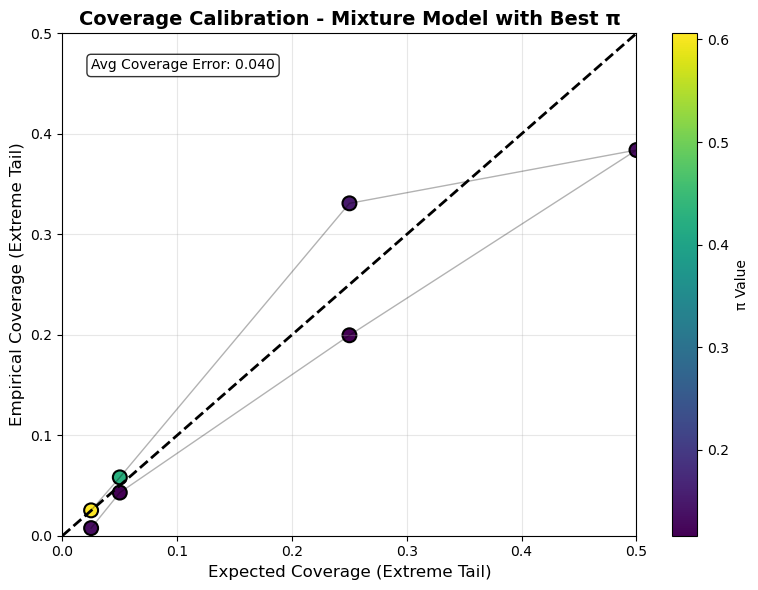


KUPIEC TEST RESULTS - MIXTURE MODEL WITH BEST π
H0: Model is correctly calibrated (actual coverage = nominal coverage)
Reject if p-value < 0.05
------------------------------------------------------------------------------------------------------------------------
Quantile   Best π     Violations   Expected     LR Stat      P-value      Result              
------------------------------------------------------------------------------------------------------------------------
    2.5%      0.133           3         9.9       6.759       0.009               REJECT
    5.0%      0.116          17        19.8       0.437       0.509                 PASS
   25.0%      0.116          79        99.0       5.661       0.017               REJECT
   50.0%      0.133         152       198.0      21.570       0.000               REJECT
   75.0%      0.149         131        99.0      12.959       0.000               REJECT
   95.0%      0.427          23        19.8       0.519       0.471      

In [152]:
from scipy import stats
import numpy as np

def kupiec_test(y_true, y_pred, alpha, tail='lower'):
    """
    Kupiec test for quantile prediction accuracy
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    # Count violations
    if tail == 'lower':
        violations = np.sum(y_true <= y_pred)
    else:
        violations = np.sum(y_true > y_pred)
    
    n = violations
    T = len(y_true)
    p_hat = n / T
    
    # Expected violations
    if tail == 'lower':
        expected_rate = alpha
    else:
        expected_rate = 1 - alpha
    
    # Avoid log(0) issues
    if n == 0 or n == T:
        return {
            'statistic': np.inf,
            'p_value': 0.0,
            'violations': n,
            'expected': T * expected_rate,
            'reject': True,
            'message': 'Extreme case: no violations or all violations'
        }
    
    # Likelihood ratio statistic
    LR = -2 * np.log(
        (expected_rate**n * (1-expected_rate)**(T-n)) / 
        (p_hat**n * (1-p_hat)**(T-n))
    )
    
    # P-value from chi-squared distribution with 1 df
    p_value = 1 - stats.chi2.cdf(LR, df=1)
    
    # Reject null hypothesis if p-value < 0.05
    reject = p_value < 0.05
    
    return {
        'statistic': LR,
        'p_value': p_value,
        'violations': n,
        'expected': T * expected_rate,
        'empirical_rate': p_hat,
        'expected_rate': expected_rate,
        'reject': reject,
        'message': 'Reject: Model is miscalibrated' if reject else 'Fail to reject: Model is well-calibrated'
    }

def analyze_mixture_bestpi_results(best_predictions, selection_summary, all_train_results, X_all, y_all):
    """Comprehensive analysis of mixture model with best pi values"""
    
    # Get test data
    n_all = len(y_all)
    train_size = int(n_all * 0.7)
    val_size = int(n_all * 0.15)
    test_start_idx = train_size + val_size
    n_test = n_all - test_start_idx
    
    # Convert y_all to numpy
    if isinstance(y_all, torch.Tensor):
        y_all_np = y_all.cpu().numpy()
    else:
        y_all_np = np.array(y_all)
    
    y_test = y_all_np[test_start_idx:]
    
    # Extract test predictions
    first_key = list(best_predictions.keys())[0]
    pred_length = len(best_predictions[first_key])
    
    mixture_test_predictions = {}
    if pred_length == n_all:
        # Predictions are for full dataset
        for quantile in best_predictions.keys():
            mixture_test_predictions[quantile] = np.array(best_predictions[quantile])[test_start_idx:]
    else:
        # Predictions are already test-only
        min_len = min(pred_length, n_test)
        y_test = y_test[:min_len]
        for quantile in best_predictions.keys():
            mixture_test_predictions[quantile] = np.array(best_predictions[quantile])[:min_len]
    
    print("\n" + "="*165)
    print("MIXTURE MODEL WITH BEST π - COMPREHENSIVE SUMMARY")
    print("="*165)
    
    # 1. Model Selection Results with Best Pi
    print("\n1. MODEL SELECTION RESULTS WITH BEST π VALUES")
    print("-"*165)
    print(f"{'Quantile':<10} {'Best π':<10} {'ET Target':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12} {'Test QL':<12}")
    print("-"*165)
    
    coverage_errors = []
    expected_coverages = []
    quantile_losses = []
    
    for q in sorted(selection_summary.keys()):
        s = selection_summary[q]
        
        # Calculate test coverage - extreme tail
        y_pred = mixture_test_predictions[q].flatten()
        y_test_flat = y_test.flatten()
        
        if q <= 0.5:
            actual_test_coverage = np.mean(y_test_flat <= y_pred)
            expected_coverage = q
        else:
            actual_test_coverage = np.mean(y_test_flat > y_pred)
            expected_coverage = 1 - q
            
        coverage_errors.append(abs(actual_test_coverage - expected_coverage))
        expected_coverages.append(expected_coverage)
        
        # Calculate quantile loss
        errors = y_test_flat - y_pred
        ql = np.mean(np.where(errors > 0, q * errors, (q - 1) * errors))
        quantile_losses.append(ql)
        
        # Get pi value
        pi_value = s.get('pi', BEST_PI_VALUES.get(q, 0.5))
        
        print(f"{q*100:>7.1f}% {pi_value:>10.3f} {expected_coverage:>10.3f} {s['seed']:>8} {s['score']:>10.4f} "
              f"{s['train_loss']:>11.4f} {s['val_loss']:>11.4f} {s['test_loss']:>11.4f} "
              f"{s['train_coverage']:>11.3f} {s['val_coverage']:>11.3f} {actual_test_coverage:>11.3f} {ql:>11.4f}")
    
    # Summary statistics
    print("\n" + "-"*165)
    avg_pi = np.mean([s.get('pi', BEST_PI_VALUES.get(q, 0.5)) for q in selection_summary.keys()])
    print(f"{'AVERAGES':<10} {avg_pi:>10.3f} {'':<10} {'':<8} {np.mean([s['score'] for s in selection_summary.values()]):>10.4f} "
          f"{np.mean([s['train_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['val_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['test_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['train_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['val_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([actual_test_coverage for _ in selection_summary.values()]):>11.3f} "
          f"{np.mean(quantile_losses):>11.4f}")
    print("="*165)
    
    # 2. Coverage Analysis by Pi Groups
    print("\n2. COVERAGE PERFORMANCE BY π GROUPS")
    print("-"*100)
    
    # Group by pi values
    pi_groups = {}
    for q, s in selection_summary.items():
        pi = s.get('pi', BEST_PI_VALUES.get(q, 0.5))
        if pi not in pi_groups:
            pi_groups[pi] = []
        pi_groups[pi].append(q)
    
    print(f"{'π Value':<10} {'Quantiles':<40} {'Avg Coverage Error':<20}")
    print("-"*100)
    
    for pi in sorted(pi_groups.keys()):
        quantiles_list = pi_groups[pi]
        # Calculate average coverage error for this pi group
        group_errors = []
        for q in quantiles_list:
            idx = sorted(selection_summary.keys()).index(q)
            group_errors.append(coverage_errors[idx])
        avg_error = np.mean(group_errors)
        
        quantiles_str = ', '.join([f"{q*100:.1f}%" for q in quantiles_list])
        print(f"{pi:<10.3f} {quantiles_str:<40} {avg_error:<20.4f}")
    
    print("-"*100)
    
    # 3. Plotting - Modified to show pi values
    # Coverage Calibration Plot
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    
    quantiles = sorted(mixture_test_predictions.keys())
    actual_coverages = []
    expected_coverages_plot = []
    pi_values = []
    
    for q in quantiles:
        y_pred = mixture_test_predictions[q].flatten()
        
        if q <= 0.5:
            actual_coverage = np.mean(y_test.flatten() <= y_pred)
            expected = q
        else:
            actual_coverage = np.mean(y_test.flatten() > y_pred)
            expected = 1 - q
            
        actual_coverages.append(actual_coverage)
        expected_coverages_plot.append(expected)
        pi_values.append(selection_summary[q].get('pi', BEST_PI_VALUES.get(q, 0.5)))
    
    # Perfect calibration line
    ax1.plot([0, 0.5], [0, 0.5], 'k--', linewidth=2, label='Perfect Calibration')
    
    # Model calibration with color-coded pi values
    scatter = ax1.scatter(expected_coverages_plot, actual_coverages, c=pi_values, 
                         cmap='viridis', s=100, edgecolors='black', linewidth=1.5)
    ax1.plot(expected_coverages_plot, actual_coverages, 'k-', alpha=0.3, linewidth=1)
    
    # Add colorbar for pi values
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('π Value', fontsize=10)
    
    ax1.set_xlabel('Expected Coverage (Extreme Tail)', fontsize=12)
    ax1.set_ylabel('Empirical Coverage (Extreme Tail)', fontsize=12)
    ax1.set_title('Coverage Calibration - Mixture Model with Best π', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)
    
    # Add coverage error text
    avg_coverage_error = np.mean(np.abs(np.array(actual_coverages) - np.array(expected_coverages_plot)))
    ax1.text(0.05, 0.95, f'Avg Coverage Error: {avg_coverage_error:.3f}', 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig1.savefig('mixture_bestpi_coverage_calibration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return mixture_test_predictions, coverage_errors

def run_kupiec_tests_mixture_bestpi(test_predictions, y_test):
    """Run Kupiec tests for mixture model with best pi"""
    
    print("\n" + "="*120)
    print("KUPIEC TEST RESULTS - MIXTURE MODEL WITH BEST π")
    print("="*120)
    print("H0: Model is correctly calibrated (actual coverage = nominal coverage)")
    print("Reject if p-value < 0.05")
    print("-"*120)
    print(f"{'Quantile':<10} {'Best π':<10} {'Violations':<12} {'Expected':<12} {'LR Stat':<12} {'P-value':<12} {'Result':<20}")
    print("-"*120)
    
    results = {}
    for q in sorted(test_predictions.keys()):
        # Get pi value from BEST_PI_VALUES
        pi_value = BEST_PI_VALUES.get(q, 0.5)
        
        tail = 'lower' if q <= 0.5 else 'upper'
        result = kupiec_test(y_test, test_predictions[q], q, tail)
        results[q] = result
        
        print(f"{q*100:>7.1f}% {pi_value:>10.3f} {result['violations']:>11} "
              f"{result['expected']:>11.1f} {result['statistic']:>11.3f} "
              f"{result['p_value']:>11.3f} {'REJECT' if result['reject'] else 'PASS':>20}")
    
    n_reject = sum(1 for r in results.values() if r['reject'])
    print("-"*120)
    print(f"Summary: {n_reject}/{len(results)} quantiles rejected (miscalibrated)")
    print("="*120)
    
    # Compare with fixed pi=0.5 if available
    print("\n3. IMPROVEMENT OVER FIXED π=0.5")
    print("-"*80)
    print("Quantiles with different π values from 0.5:")
    for q in sorted(test_predictions.keys()):
        pi = BEST_PI_VALUES.get(q, 0.5)
        if abs(pi - 0.5) > 0.01:
            print(f"  α={q:.3f}: π={pi:.3f} (Δ={pi-0.5:+.3f})")
    print("-"*80)
    
    return results

# Run the comprehensive analysis
print("Running comprehensive analysis for Mixture Model with Best π...")

# First run the analysis
test_predictions, coverage_errors = analyze_mixture_bestpi_results(
    best_predictions, selection_summary, all_train_results, X_all, y_all
)

# Then run Kupiec tests
# Extract y_test properly
n_all = len(y_all)
train_size = int(n_all * 0.7)
val_size = int(n_all * 0.15)
test_start_idx = train_size + val_size

if isinstance(y_all, torch.Tensor):
    y_test = y_all[test_start_idx:].cpu().numpy()
else:
    y_test = np.array(y_all)[test_start_idx:]

# Ensure same length as predictions
min_len = min(len(y_test), len(test_predictions[list(test_predictions.keys())[0]]))
y_test = y_test[:min_len]

kupiec_results = run_kupiec_tests_mixture_bestpi(test_predictions, y_test)

# Additional analysis: Show improvement metrics
print("\n4. MODEL SELECTION METRICS ACROSS REPEATS")
print("-"*100)
print(f"{'Quantile':<10} {'π':<10} {'Min Score':<12} {'Avg Score':<12} {'Max Score':<12} {'Std Score':<12}")
print("-"*100)

for q in sorted(all_train_results.keys()):
    scores = [r['score'] for r in all_train_results[q]]
    pi = BEST_PI_VALUES.get(q, 0.5)
    print(f"{q*100:>7.1f}% {pi:>10.3f} {min(scores):>11.4f} {np.mean(scores):>11.4f} "
          f"{max(scores):>11.4f} {np.std(scores):>11.4f}")

print("-"*100)

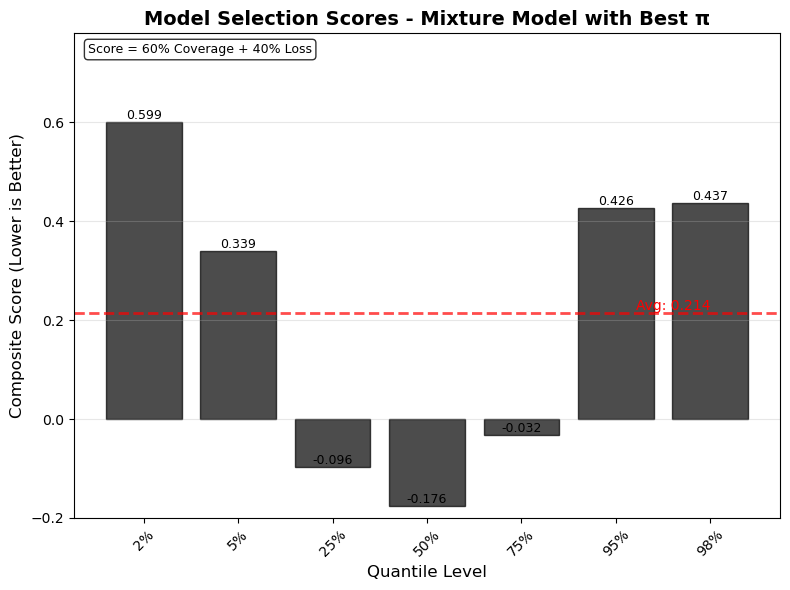

In [184]:
# Plot 2: Composite Score Plot
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Get composite scores for each level
quantiles = sorted(selection_summary.keys())
score_values = [selection_summary[q]['score'] for q in quantiles]

# Bar plot with black color
x_pos = np.arange(len(quantiles))
bars = ax2.bar(x_pos, score_values, color='black', alpha=0.7, edgecolor='black', linewidth=1)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, score_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Quantile Level', fontsize=12)
ax2.set_ylabel('Composite Score (Lower is Better)', fontsize=12)
ax2.set_title('Model Selection Scores - Mixture Model with Best π', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{q*100:.0f}%' for q in quantiles], rotation=45)
ax2.grid(True, axis='y', alpha=0.3)

# Set y-axis limits to be taller
max_score = max(score_values)
ax2.set_ylim(-0.2, max_score * 1.3)  # 30% extra space above highest bar

# Add average score line in red
avg_score = np.mean(score_values)
ax2.axhline(y=avg_score, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.text(len(quantiles)-1, avg_score, f'Avg: {avg_score:.3f}', 
         verticalalignment='bottom', horizontalalignment='right', color='red')

# Add text explaining the score
ax2.text(0.02, 0.98, 'Score = 60% Coverage + 40% Loss', 
         transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
fig2.savefig('mixture_bestpi_composite_scores.png', dpi=300, bbox_inches='tight')
plt.show()

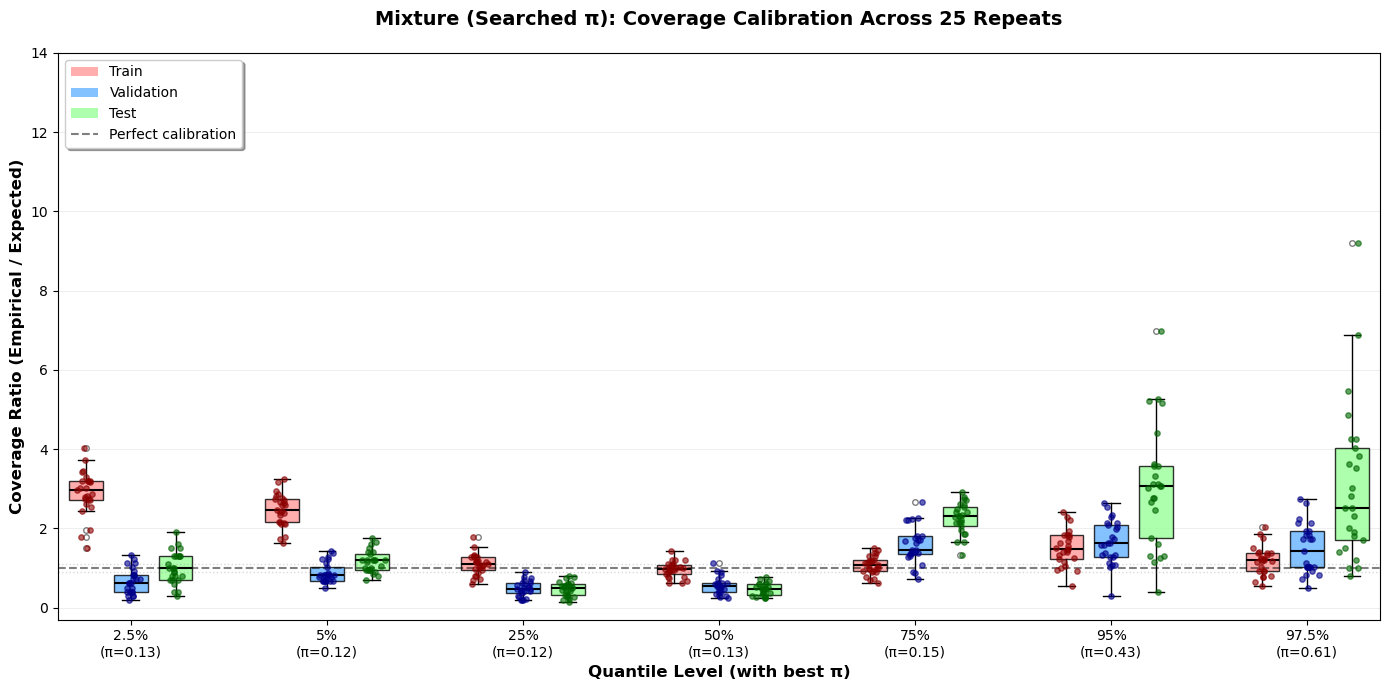

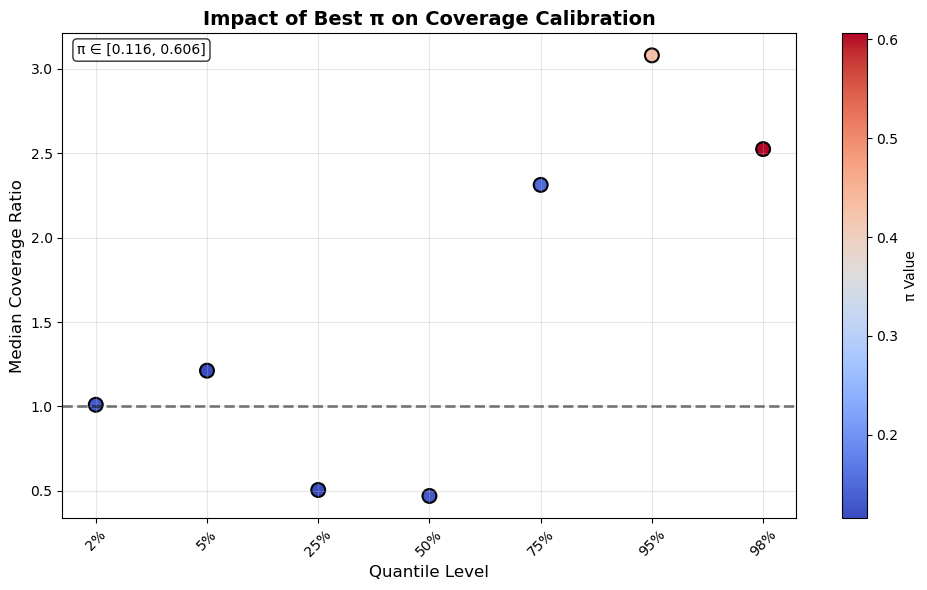

In [180]:
def plot_coverage_ratio_boxplot_mixture_bestpi(all_train_results, levels, model_name="Mixture (Best π)", save_path=None):
    """
    Plot coverage ratio boxplot for Mixture model with best pi values
    """
    rng = np.random.default_rng(42)
    levels = sorted(levels)

    train_ratios_by_lvl, val_ratios_by_lvl, test_ratios_by_lvl = [], [], []
    labels = []

    for lvl in levels:
        reps = all_train_results.get(lvl, [])
        tr_list, va_list, te_list = [], [], []

        # Expected tail coverage based on quantile level
        expected = lvl if lvl <= 0.5 else (1 - lvl)

        for rep in reps:
            # Direct access to metrics
            metrics = rep.get('metrics', {})

            # Get coverage ratios directly
            r_tr = metrics.get('train', {}).get('coverage_ratio', np.nan)
            r_va = metrics.get('val', {}).get('coverage_ratio', np.nan)
            r_te = metrics.get('test', {}).get('coverage_ratio', np.nan)

            # If coverage_ratio not available, calculate from actual_coverage
            if np.isnan(r_tr):
                cov_tr = metrics.get('train', {}).get('actual_coverage', np.nan)
                r_tr = cov_tr / expected if np.isfinite(cov_tr) and expected > 0 else np.nan
            if np.isnan(r_va):
                cov_va = metrics.get('val', {}).get('actual_coverage', np.nan)
                r_va = cov_va / expected if np.isfinite(cov_va) and expected > 0 else np.nan
            if np.isnan(r_te):
                cov_te = metrics.get('test', {}).get('actual_coverage', np.nan)
                r_te = cov_te / expected if np.isfinite(cov_te) and expected > 0 else np.nan

            tr_list.append(r_tr)
            va_list.append(r_va)
            te_list.append(r_te)

        train_ratios_by_lvl.append([r for r in tr_list if np.isfinite(r)])
        val_ratios_by_lvl.append([r for r in va_list if np.isfinite(r)])
        test_ratios_by_lvl.append([r for r in te_list if np.isfinite(r)])
        
        # Format labels based on quantile value
        if lvl == 0.025:
            labels.append("2.5%")
        elif lvl == 0.05:
            labels.append("5%")
        elif lvl == 0.975:
            labels.append("97.5%")
        else:
            labels.append(f"{int(lvl*100)}%")

    # x positions with more spacing
    K = len(levels)
    spacing = 3.5
    pos_tr = [i*spacing + 0.8 for i in range(K)]
    pos_va = [i*spacing + 1.6 for i in range(K)]
    pos_te = [i*spacing + 2.4 for i in range(K)]

    plt.figure(figsize=(14, 7))
    
    # boxplots
    bp1 = plt.boxplot(train_ratios_by_lvl, positions=pos_tr, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#ff9999", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp2 = plt.boxplot(val_ratios_by_lvl, positions=pos_va, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#66b3ff", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp3 = plt.boxplot(test_ratios_by_lvl, positions=pos_te, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#99ff99", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))

    # overlay individual points with jitter
    for i in range(K):
        # train
        T = train_ratios_by_lvl[i]
        if T:
            x = rng.normal(pos_tr[i], 0.08, len(T))
            plt.scatter(x, T, s=15, color='darkred', alpha=0.6, zorder=3)
        # val
        V = val_ratios_by_lvl[i]
        if V:
            x = rng.normal(pos_va[i], 0.08, len(V))
            plt.scatter(x, V, s=15, color='darkblue', alpha=0.6, zorder=3)
        # test
        E = test_ratios_by_lvl[i]
        if E:
            x = rng.normal(pos_te[i], 0.08, len(E))
            plt.scatter(x, E, s=15, color='darkgreen', alpha=0.6, zorder=3)

    # perfect ratio line
    plt.axhline(1.0, linestyle='--', color='black', alpha=0.5, linewidth=1.5, label='Perfect calibration (ratio = 1.0)')
    
    # Add light horizontal lines at 0.9 and 1.1 for reference
    plt.axhline(0.9, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    plt.axhline(1.1, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    
    # y-limits
    all_vals = [v for grp in (train_ratios_by_lvl + val_ratios_by_lvl + test_ratios_by_lvl) for v in grp]
    if all_vals:
        y_min = -0.3
        y_max = 14
    else:
        y_min, y_max = 0.5, 1.5
    plt.ylim(y_min, y_max)

    # x-axis - add pi values to labels
    tick_pos = [(pos_tr[i] + pos_te[i]) / 2 for i in range(K)]
    
    # Enhanced labels with pi values
    enhanced_labels = []
    for i, lvl in enumerate(levels):
        pi_val = BEST_PI_VALUES.get(lvl, 0.5)
        enhanced_labels.append(f"{labels[i]}\n(π={pi_val:.2f})")
    
    plt.xticks(tick_pos, enhanced_labels, fontsize=10)
    plt.xlabel('Quantile Level (with best π)', fontsize=12, fontweight='bold')
    plt.ylabel('Coverage Ratio (Empirical / Expected)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: Coverage Calibration Across 25 Repeats', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [
        Patch(facecolor="#ff9999", alpha=0.8, label="Train"),
        Patch(facecolor="#66b3ff", alpha=0.8, label="Validation"),
        Patch(facecolor="#99ff99", alpha=0.8, label="Test"),
        plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect calibration')
    ]
    plt.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=10, 
               fancybox=True, shadow=True)
    
    plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Create the coverage ratio boxplot
levels = sorted(all_train_results.keys())
plot_coverage_ratio_boxplot_mixture_bestpi(
    all_train_results=all_train_results,
    levels=levels,
    model_name="Mixture (Searched π)",
    save_path="thesis_mixture_bestpi_coverage_ratio_boxplot.png"
)

# Additional: Create a comparison plot showing improvement from fixed π=0.5
def plot_pi_impact_comparison(all_train_results, levels):
    """Show the impact of using best π values on coverage ratios"""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate median test coverage ratios for each quantile
    median_ratios = []
    pi_values = []
    
    for lvl in sorted(levels):
        reps = all_train_results.get(lvl, [])
        test_ratios = []
        
        expected = lvl if lvl <= 0.5 else (1 - lvl)
        
        for rep in reps:
            metrics = rep.get('metrics', {})
            r_te = metrics.get('test', {}).get('coverage_ratio', np.nan)
            
            if np.isnan(r_te):
                cov_te = metrics.get('test', {}).get('actual_coverage', np.nan)
                r_te = cov_te / expected if np.isfinite(cov_te) and expected > 0 else np.nan
            
            if np.isfinite(r_te):
                test_ratios.append(r_te)
        
        if test_ratios:
            median_ratios.append(np.median(test_ratios))
            pi_values.append(BEST_PI_VALUES.get(lvl, 0.5))
    
    # Create scatter plot with color-coded pi values
    scatter = ax.scatter(range(len(median_ratios)), median_ratios, 
                        c=pi_values, cmap='coolwarm', s=100, 
                        edgecolors='black', linewidth=1.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('π Value', fontsize=10)
    
    # Perfect calibration line
    ax.axhline(1.0, linestyle='--', color='black', alpha=0.5, linewidth=2)
    
    # Formatting
    ax.set_xticks(range(len(median_ratios)))
    ax.set_xticklabels([f"{lvl*100:.0f}%" for lvl in sorted(levels)], rotation=45)
    ax.set_xlabel('Quantile Level', fontsize=12)
    ax.set_ylabel('Median Coverage Ratio', fontsize=12)
    ax.set_title('Impact of Best π on Coverage Calibration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add text showing range of π values
    pi_range = f"π ∈ [{min(pi_values):.3f}, {max(pi_values):.3f}]"
    ax.text(0.02, 0.98, pi_range, transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('mixture_bestpi_impact.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create the impact comparison plot
plot_pi_impact_comparison(all_train_results, levels)

ALD-AGD MIXTURE MODEL WITH INDIVIDUAL π
Configuration:
- Individual π values tuned for each quantile level
- Architecture-specific hyperparameters from tuning
- Weighted average for predictions
- Same architecture as AGD model
- LayerNorm and LR Scheduler enabled
- Random seed = 2025
Data split - Train: 1840, Val: 394, Test: 396

Training ALD-AGD Mixture for α = 0.025
Configuration:
  LSTM: 108×1
  Hidden: 52, 107
  Activation: relu
  LR: 0.0016
  Batch size: 107
  Sigma: 0.6770
  Dropout: 0.147
  Individual π: 0.253
Target quantile: 0.025
ALD α (quantile): 0.025
AGD τ (expectile, mapped): 0.0620
Individual π (mixing weight): 0.2530
Using sigma: 0.6770
Architecture: LSTM(108×1) -> Hidden(52, 107)
Epoch 50: Train Loss = 1.3647, Val Loss = 1.3640, LR = 0.000800
Early stopping at epoch 56
Test Loss: 1.3640
Training completed in 2.1 seconds

Parameter statistics for alpha=0.025:
mu1: mean=-0.0747, std=0.0016
mu2: mean=-0.0381, std=0.0014
|mu1-mu2| mean: 0.0367

Results:
Target quantile: 0.

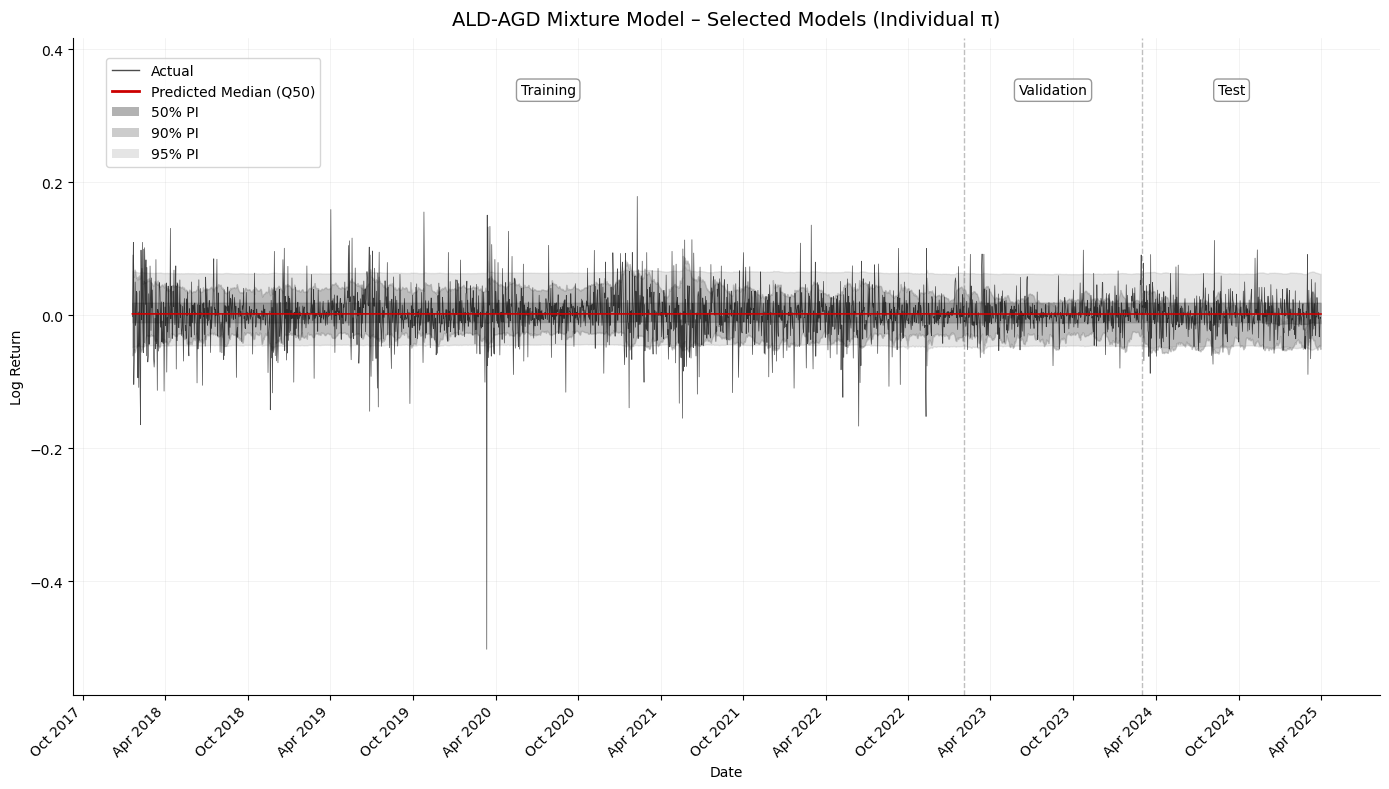

Full timeline plot saved as 'thesis_mixture_timelinebefore_individual_pi.png'


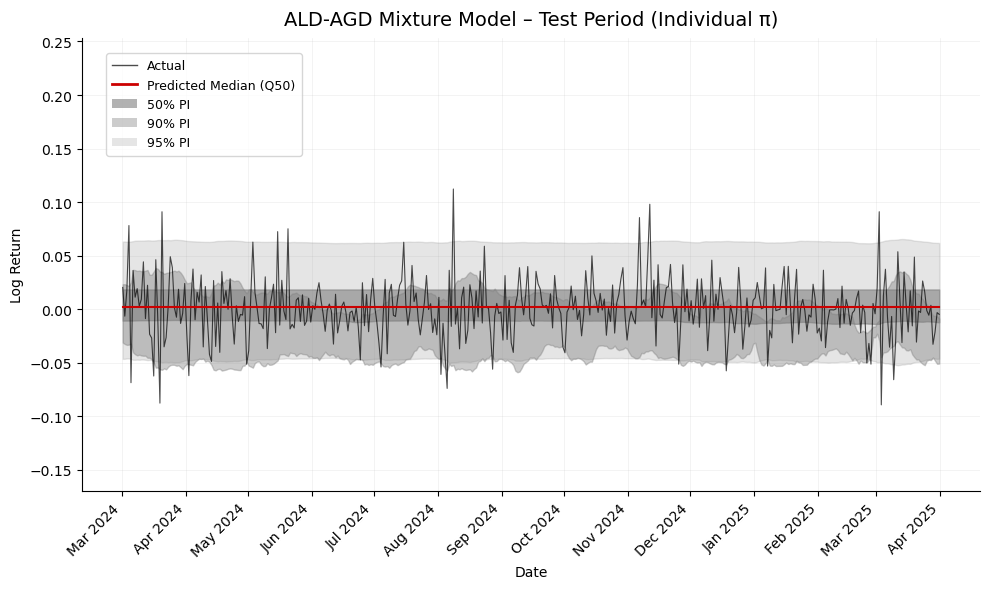

Test period plot saved as 'thesis_mixture_testlinebefore_individual_pi.png'


In [120]:
# ALD-AGD Mixture Model with Best Tuned Parameters and Individual π
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random
import time

# Set all random seeds to 2025
torch.manual_seed(2025)
np.random.seed(2025)
random.seed(2025)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2025)
    torch.cuda.manual_seed_all(2025)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def prepare_data(X_all, y_all, train_ratio=0.7, val_ratio=0.15):
    """Split data into train, validation, and test sets"""
    if not isinstance(X_all, torch.Tensor):
        X_all = torch.tensor(X_all, dtype=torch.float32)
    if not isinstance(y_all, torch.Tensor):
        y_all = torch.tensor(y_all, dtype=torch.float32)
    
    total_samples = len(X_all)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_val = X_all[train_size:train_size + val_size]
    y_val = y_all[train_size:train_size + val_size]
    X_test = X_all[train_size + val_size:]
    y_test = y_all[train_size + val_size:]
    
    print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test

def create_quantile_to_expectile_map():
    """Create mapping from quantile levels (alpha) to expectile levels (tau)"""
    mapping = {
        0.025: 0.062016,
        0.050: 0.106364,
        0.100: 0.176156,
        0.250: 0.332541,
        0.500: 0.541588,
        0.750: 0.744184,
        0.900: 0.882819,
        0.950: 0.937080,
        0.975: 0.967093
    }
    
    def interpolate_mapping(alpha):
        alpha_values = sorted(mapping.keys())
        if alpha in mapping:
            return mapping[alpha]
        
        for i in range(len(alpha_values) - 1):
            if alpha_values[i] < alpha < alpha_values[i + 1]:
                alpha_low, alpha_high = alpha_values[i], alpha_values[i + 1]
                tau_low, tau_high = mapping[alpha_low], mapping[alpha_high]
                weight = (alpha - alpha_low) / (alpha_high - alpha_low)
                tau = tau_low + weight * (tau_high - tau_low)
                return tau
        
        if alpha < alpha_values[0]:
            return alpha * (mapping[alpha_values[0]] / alpha_values[0])
        else:
            return 1 - (1 - alpha) * ((1 - mapping[alpha_values[-1]]) / (1 - alpha_values[-1]))
    
    return interpolate_mapping
# Best configurations with constrained individual π from tuning results
BEST_CONFIGS = {
    0.025: {"lstm_hidden_dim": 108, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 52, "n_hidden2": 107, "activation": "relu",
            "dropout": 0.147, "lr": 0.0016, "batch_size": 107,
            "weight_init": "he_normal", "sigma": 0.677, "pi": 0.253,
            "gradient_clip": None, "optimizer": "adamw", "weight_decay": 5.9437667762274566e-05},
    0.05: {"lstm_hidden_dim": 16, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 55, "n_hidden2": 45, "activation": "relu",
            "dropout": 0.005, "lr": 0.0023, "batch_size": 111,
            "weight_init": "glorot_uniform", "sigma": 0.619, "pi": 0.204,
            "gradient_clip": 0.5515641293578724, "optimizer": "adam", "weight_decay": 6.630357903867908e-05},
    0.25: {"lstm_hidden_dim": 115, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 67, "n_hidden2": 51, "activation": "relu",
            "dropout": 0.108, "lr": 0.0004, "batch_size": 108,
            "weight_init": "glorot_uniform", "sigma": 0.302, "pi": 0.421,
            "gradient_clip": 2.569940325162999, "optimizer": "adam", "weight_decay": 0.0002452687152261599},
    0.5: {"lstm_hidden_dim": 123, "lstm_layers": 2, "n_hidden_layers": 2,
            "n_hidden1": 49, "n_hidden2": 118, "activation": "relu",
            "dropout": 0.093, "lr": 0.0012, "batch_size": 101,
            "weight_init": "glorot_uniform", "sigma": 0.308, "pi": 0.421,
            "gradient_clip": 4.126758482822973, "optimizer": "adam", "weight_decay": 0.00014749277981009116},
    0.75: {"lstm_hidden_dim": 113, "lstm_layers": 2, "n_hidden_layers": 2,
            "n_hidden1": 108, "n_hidden2": 78, "activation": "relu",
            "dropout": 0.067, "lr": 0.0192, "batch_size": 121,
            "weight_init": "he_normal", "sigma": 0.311, "pi": 0.267,
            "gradient_clip": 7.940188457974542, "optimizer": "adam", "weight_decay": 0.00023815336165221022},
    0.95: {"lstm_hidden_dim": 62, "lstm_layers": 1, "n_hidden_layers": 2,
            "n_hidden1": 52, "n_hidden2": 48, "activation": "gelu",
            "dropout": 0.000, "lr": 0.0026, "batch_size": 118,
            "weight_init": "glorot_normal", "sigma": 1.028, "pi": 0.403,
            "gradient_clip": 3.938852453357208, "optimizer": "adam", "weight_decay": 6.4345252983572e-05},
    0.975: {"lstm_hidden_dim": 108, "lstm_layers": 2, "n_hidden_layers": 2,
            "n_hidden1": 48, "n_hidden2": 81, "activation": "relu",
            "dropout": 0.056, "lr": 0.0004, "batch_size": 35,
            "weight_init": "he_normal", "sigma": 0.318, "pi": 0.457,
            "gradient_clip": None, "optimizer": "adamw", "weight_decay": 3.3709331021903084e-05}
}
class ALDAGDMixture(nn.Module):
    def __init__(self, config, quantile_to_expectile_map):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        self.target_quantile = config.get("tau", config.get("target_quantile", 0.5))
        self.alpha_ald = self.target_quantile
        self.tau_agd = quantile_to_expectile_map(self.target_quantile)
        self.pi = config.get("pi", 0.5)  # Get individual π from config
        
        print(f"Target quantile: {self.target_quantile:.3f}")
        print(f"ALD α (quantile): {self.alpha_ald:.3f}")
        print(f"AGD τ (expectile, mapped): {self.tau_agd:.4f}")
        print(f"Individual π (mixing weight): {self.pi:.4f}")
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (except last)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.fc = nn.Sequential(*layers)
        
        # Two output layers for mixture
        self.mu1_layer = nn.Linear(prev_dim, 1)
        self.mu2_layer = nn.Linear(prev_dim, 1)
        
        # Sigma from config
        self.sigma_fixed = config.get("sigma", 0.5)
        
        print(f"Using sigma: {self.sigma_fixed:.4f}")
        print(f"Architecture: LSTM({lstm_hidden}×{lstm_layers}) -> Hidden({config.get('n_hidden1', 64)}, {config.get('n_hidden2', 64)})")
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        # Process through hidden layers
        hidden = self.fc(last_hidden)
        
        # Get predictions
        mu1 = self.mu1_layer(hidden)
        mu2 = self.mu2_layer(hidden)
        
        # Fixed sigma
        sigma1 = torch.full_like(mu1, self.sigma_fixed)
        sigma2 = torch.full_like(mu2, self.sigma_fixed)
        
        return mu1, sigma1, mu2, sigma2

def ald_pdf(y, mu, sigma, alpha):
    """ALD PDF with quantile level alpha"""
    diff = y - mu
    indicator = (y <= mu).float()
    normalization = (alpha * (1 - alpha)) / sigma
    exponent = -diff / sigma * (alpha - indicator)  
    pdf = normalization * torch.exp(exponent)
    return pdf

def agd_pdf(y, mu, sigma, tau):
    """AGD PDF with expectile level tau"""
    diff = y - mu
    indicator = (y < mu).float()
    norm_const = 2 / (sigma * np.sqrt(np.pi) * (np.sqrt(1/(1-tau)) + np.sqrt(1/tau)))
    exponent = -(diff**2) / (sigma**2) * torch.abs(tau - indicator)
    pdf = norm_const * torch.exp(exponent)
    return pdf

def mixture_nll_loss(y, mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, pi):
    """Mixture NLL loss with individual pi"""
    y = y.view(-1, 1)
    
    pdf_ald = ald_pdf(y, mu1, sigma1, alpha_ald)
    pdf_agd = agd_pdf(y, mu2, sigma2, tau_agd)
    
    pdf_mix = pi * pdf_ald + (1 - pi) * pdf_agd
    pdf_mix = torch.clamp(pdf_mix, min=1e-8)
    
    nll = -torch.log(pdf_mix)
    return torch.mean(nll)

def get_quantile_from_mixture(mu1, sigma1, mu2, sigma2, alpha_ald, tau_agd, 
                             target_quantile, pi, n_samples=100):
    """Simple weighted average of location parameters"""
    quantile_pred = pi * mu1 + (1 - pi) * mu2
    return quantile_pred

def train_model_best_params(X_train, y_train, X_val, y_val, X_test, y_test, 
                           config, quantile_to_expectile_map):
    """Train with best hyperparameters"""
    torch.manual_seed(2025)
    
    config["input_dim"] = X_train.shape[2]
    
    model = ALDAGDMixture(config, quantile_to_expectile_map)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], 
                             weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5, min_lr=1e-6
    )
    
    # Training setup
    batch_size = config.get('batch_size', 64)
    max_epochs = 200
    patience = 30
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    best_model_state = None
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            mu1, sigma1, mu2, sigma2 = model(batch_X)
            loss = mixture_nll_loss(batch_y, mu1, sigma1, mu2, sigma2, 
                                   model.alpha_ald, model.tau_agd, model.pi)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Numerical issue at epoch {epoch}: loss = {loss.item()}")
                break
            
            loss.backward()
            
            # Gradient clipping if specified
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
            epoch_train_loss += loss.item() * len(batch_X)
        
        epoch_train_loss /= len(X_train)
        train_losses.append(epoch_train_loss)
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_mu1, val_sigma1, val_mu2, val_sigma2 = model(X_val)
            val_loss = mixture_nll_loss(y_val, val_mu1, val_sigma1, val_mu2, val_sigma2,
                                       model.alpha_ald, model.tau_agd, model.pi)
            val_losses.append(val_loss.item())
        
        # Update learning rate
        scheduler.step(val_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, "
                  f"Val Loss = {val_loss.item():.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Test evaluation
    model.eval()
    with torch.no_grad():
        test_mu1, test_sigma1, test_mu2, test_sigma2 = model(X_test)
        test_loss = mixture_nll_loss(y_test, test_mu1, test_sigma1, test_mu2, test_sigma2,
                                    model.alpha_ald, model.tau_agd, model.pi)
    
    print(f"Test Loss: {test_loss.item():.4f}")
    
    return model, train_losses, val_losses

def plot_predictions_two_panel(results, X_all, y_all, X_test, y_test, df_copy, alpha_values):
    """Create two-panel plot with thesis-style formatting"""
    # Get predictions for all data
    all_predictions = {}
    
    # Get train/val/test split sizes
    total_samples = len(X_all)
    train_size = int(total_samples * 0.7)
    val_size = int(total_samples * 0.15)
    test_size = total_samples - train_size - val_size
    
    # Convert data to tensors if needed
    if not isinstance(X_all, torch.Tensor):
        X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    else:
        X_all_tensor = X_all
    
    # Get predictions for entire dataset for each quantile
    for alpha in alpha_values:
        model = results[alpha]["model"]
        model.eval()
        with torch.no_grad():
            mu1, sigma1, mu2, sigma2 = model(X_all_tensor)
            y_pred = get_quantile_from_mixture(
                mu1, sigma1, mu2, sigma2,
                model.alpha_ald, model.tau_agd,
                alpha, pi=model.pi
            )
            all_predictions[alpha] = y_pred.cpu().numpy().flatten()
    
    # --- Dates aligned to end of each seq ---
    seq_length = 3
    
    # Get date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)
    
    # Get all dates
    available_dates = base_dates.iloc[seq_length: seq_length + len(y_all)].values
    assert len(available_dates) == len(y_all), f"Date mismatch: {len(available_dates)} vs {len(y_all)}"
    
    # Split dates
    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])
    
    # Convert y data
    y_all_np = y_all.cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()
    
    # Split y data
    y_train_np = y_all_np[:train_size]
    y_val_np = y_all_np[train_size: train_size + val_size]
    
    # Central line: Q50 if possible
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in alpha_values])
        central_full = stacks.mean(axis=1)
    
    # Check which intervals we can plot
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05 in all_predictions) and (0.95 in all_predictions)
    have_50 = (0.25 in all_predictions) and (0.75 in all_predictions)
    
    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()
    
    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val = central_full[train_size: train_size + val_size]
    cent_test = central_full[train_size + val_size: train_size + val_size + test_size]
    
    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]
    
    # Colors
    actual_color = '#000000'
    pred_color = '#CC0000'
    pi_color = '#808080'
    
    # ===== Plot 1: Full timeline =====
    fig, ax = plt.subplots(figsize=(14, 8))
    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)
    
    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)
    
    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)
    
    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)
    
    # Split markers + labels
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    
    # Dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')
    
    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))
    
    ax.set_title('ALD-AGD Mixture Model – Selected Models (Individual π)', fontsize=14, pad=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_mixture_timelinebefore_individual_pi.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Full timeline plot saved as 'thesis_mixture_timelinebefore_individual_pi.png'")
    
    # ===== Plot 2: Test period =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4*y_rng_t, y_max_t + 0.7*y_rng_t)
    
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')
    
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')
    
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)
    
    ax.set_title('ALD-AGD Mixture Model – Test Period (Individual π)', fontsize=14, pad=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_mixture_testlinebefore_individual_pi.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Test period plot saved as 'thesis_mixture_testlinebefore_individual_pi.png'")

def train_and_plot_mixture(X_all, y_all, df_copy, 
                          alpha_values=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Train models with best hyperparameters and individual pi"""
    results = {}
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    quantile_to_expectile_map = create_quantile_to_expectile_map()
    
    # Extract dates for test period
    seq_length = 3
    total_sequences = len(X_all)
    train_size = int(total_sequences * 0.7)
    val_size = int(total_sequences * 0.15)
    test_start_sequence_idx = train_size + val_size
    first_sequence_original_row = seq_length
    
    test_dates_list = []
    for j in range(len(y_test)):
        sequence_idx = test_start_sequence_idx + j
        target_day_in_df = first_sequence_original_row + sequence_idx
        if target_day_in_df < len(df_copy):
            test_dates_list.append(df_copy.iloc[target_day_in_df]['Date'])
        else:
            test_dates_list.append(pd.NaT)
    
    test_dates = pd.to_datetime(test_dates_list)
    
    # Train models for each alpha with best hyperparameters and individual pi
    for alpha in alpha_values:
        print(f"\n{'='*60}")
        print(f"Training ALD-AGD Mixture for α = {alpha:.3f}")
        print(f"{'='*60}")
        
        # Get best config for this alpha
        if alpha in BEST_CONFIGS:
            config = BEST_CONFIGS[alpha].copy()
        else:
            # Use nearest available config
            available_alphas = list(BEST_CONFIGS.keys())
            nearest_alpha = min(available_alphas, key=lambda x: abs(x - alpha))
            print(f"Using config from α={nearest_alpha:.3f} (nearest available)")
            config = BEST_CONFIGS[nearest_alpha].copy()
        
        config["tau"] = alpha
        config["target_quantile"] = alpha
        
        # Display config
        print(f"Configuration:")
        print(f"  LSTM: {config['lstm_hidden_dim']}×{config['lstm_layers']}")
        print(f"  Hidden: {config['n_hidden1']}, {config['n_hidden2']}")
        print(f"  Activation: {config['activation']}")
        print(f"  LR: {config['lr']:.4f}")
        print(f"  Batch size: {config['batch_size']}")
        print(f"  Sigma: {config['sigma']:.4f}")
        print(f"  Dropout: {config['dropout']:.3f}")
        print(f"  Individual π: {config['pi']:.3f}")
        if config.get('gradient_clip'):
            print(f"  Gradient clip: {config['gradient_clip']:.6f}")
        
        start_time = time.time()
        model, train_losses, val_losses = train_model_best_params(
            X_train, y_train, X_val, y_val, X_test, y_test, config, quantile_to_expectile_map
        )
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.1f} seconds")
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            mu1, sigma1, mu2, sigma2 = model(X_test)
            
            # Debug: Print parameter statistics
            print(f"\nParameter statistics for alpha={alpha:.3f}:")
            print(f"mu1: mean={mu1.mean().item():.4f}, std={mu1.std().item():.4f}")
            print(f"mu2: mean={mu2.mean().item():.4f}, std={mu2.std().item():.4f}")
            print(f"|mu1-mu2| mean: {torch.mean(torch.abs(mu1-mu2)).item():.4f}")
            
            y_pred = get_quantile_from_mixture(
                mu1, sigma1, mu2, sigma2, 
                model.alpha_ald, model.tau_agd, 
                alpha, pi=model.pi
            )
            
            errors = y_test - y_pred
            empirical_alpha = torch.mean((errors < 0).float()).item()
            
        results[alpha] = {
            "model": model,
            "y_pred": y_pred.cpu().numpy(),
            "empirical_alpha": empirical_alpha
        }
        
        print(f"\nResults:")
        print(f"Target quantile: {alpha:.3f}")
        print(f"Empirical coverage: {empirical_alpha:.3f}")
    
    # Print summary with individual π values
    print("\n" + "="*80)
    print("ALD-AGD MIXTURE MODEL SUMMARY WITH INDIVIDUAL π")
    print("="*80)
    print(f"{'Target α':<10} {'π (tuned)':<10} {'ALD α':<10} {'AGD τ':<10} {'Empirical α':<12}")
    print("-"*80)
    for alpha in alpha_values:
        pi_value = BEST_CONFIGS[alpha]["pi"]
        alpha_ald = results[alpha]["model"].alpha_ald
        tau_agd = results[alpha]["model"].tau_agd
        emp_alpha = results[alpha]["empirical_alpha"]
        print(f"{alpha:<10.3f} {pi_value:<10.3f} {alpha_ald:<10.3f} {tau_agd:<10.4f} {emp_alpha:<12.3f}")
    
    # Create two-panel plot
    print("\n" + "="*80)
    print("Creating two-panel visualization")
    print("="*80)
    
    fig = plot_predictions_two_panel(
        results, X_all, y_all, X_test, y_test, 
        df_copy, alpha_values
    )
    
    return results

# Main function
def main_mixture_individual_pi(df_copy, X_all, y_all):
    print("ALD-AGD MIXTURE MODEL WITH INDIVIDUAL π")
    print("="*60)
    print("Configuration:")
    print("- Individual π values tuned for each quantile level")
    print("- Architecture-specific hyperparameters from tuning")
    print("- Weighted average for predictions")
    print("- Same architecture as AGD model")
    print("- LayerNorm and LR Scheduler enabled")
    print("- Random seed = 2025")
    print("="*60)
    
    alpha_values = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    
    results = train_and_plot_mixture(X_all, y_all, df_copy, alpha_values)
    
    return results

# Run the model
if __name__ == "__main__":
    # Assuming X_all, y_all, and df_copy are defined elsewhere
    results = main_mixture_individual_pi(df_copy, X_all, y_all)